# predict_retinotopy analyses

The is is the notebook associated with the paper "Movies reveal the fine-grained organization of infant visual cortex" by Ellis, Yates, Arcaro, & Turk-Browne. 

The code expects that you have two directories downloaded into the infant neuropipe `data` folder. If you want to use different paths, you will have to change the directories listed in the `utils.py` file in this directory:  
`predict_dir = './data/predict_retinotopy/'` - This folder must be downloaded from the data release (see the README). It will contain the `concat_movies` directory which includes all of the movie data from a participant as a single run. It also contains the results of the ICA analyses that has been run on these movies. The folder will also hold the intermediate and final files created by running this notebook.    
`retinotopy_dir = './data/Retinotopy/'` — This is the [retinotopy data](https://doi.org/10.5061/dryad.7h44j0ztm) folder that was released as part of Ellis et al., 2021  

Note that the `Movies` directory, which contains the raw data, has not been supplied in the data release. These data would be needed to fully recreate the SRM analyses, but are too large to supply here. This folder would contain the following movie directories: 'Child_Play', 'Catepillar', 'Meerkats', 'Mouseforsale', and 'Aeronaut'.  

The first time you run this, three directories will be populated that transform volume data into surface space. This is quite slow and requires software like AFNI. If you don't wish to recreate these files, you can set the parameter `skip_surf_generation` to `1`. The notebook should still run since these are intermediate files, and the end products are already stored.

The notebook should be run in the order provided in order to recreate the figures from the paper. p values may differ from those reported in the manuscript because of random seeds.

**Table of contents**
>[Set up](#setup)  
>[Homotopy analyses](#homology)  
>[Independent components analyses](#ica)  
>[Shared response modelling analyses](#srm)  
>[Statistical analyses](#stats)

# Set up <a id='setup'></a>
Set up the libraries, functions and parameters to be able to run all other sections. After you have set up this section, you should be able to jump to another. 

In [1]:
# Import the necessary libaries
from utils import * # This file contains various parameters and functions that are called by multiple scripts in this directory
from sklearn.manifold import MDS as mds
from sklearn.manifold import TSNE as tsne
from brainiak.utils.fmrisim import convolve_hrf
import seaborn as sns
sys.path.append("..")
import pickle

%matplotlib inline

np.random.seed(0)

/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


Preset variables and parameters that are used throughout

In [2]:
# What are the ROI names
rois = ['vV1', 'vV2', 'vV3', 'vV4', 'dV1', 'dV2', 'dV3', 'dV3AB'] 

# Do you want to include ROIs you werent sure about?
use_uncertain_ROIs = False

# What mask do you want to use for SRM? Could be 'occipital' or 'Wang'
mask_type = 'occipital'

# How long is each movie in seconds?
movie_length = {'Child_Play-ball_play': 84, 'Child_Play-banana_blend': 64, 'Child_Play-doctors_visit': 115, 'Child_Play-helping_chores': 143, 'MM-Drop_Ballet_Audio': 180, 'MM-Drop_Catepillar_Audio': 180, 'MM-Drop_Clocky_Audio': 180, 'MM-Drop_Elephant_Audio': 180, 'MM-Drop_Foxmouse_Audio': 180, 'MM-Drop_MadeinFrance_Audio': 180, 'MM-Drop_Meerkats_Audio': 180, 'MM-Drop_Mouseforsale_Audio': 180, 'MM-Full_Aeronaut_NoAudio': 180, 'MM-Full_Catepillar_Audio': 180, 'MM-Full_Clocky_Audio': 180, 'MM-Full_Elephant_Audio': 180, 'MM-Full_Foxmouse_Audio': 180, 'MM-Full_Gopher_Audio': 180, 'MM-Full_MadeinFrance_Audio': 180, 'MM-Full_Meerkats_Audio': 180, 'MM-Full_Mouseforsale_Audio': 180}

# What is the resolution of the gradient lines drawn
max_len=200

# What are the names of the conditions that were made from retinotopy
GLM_conditions = ['meridian', 'sf']

# What features will you consider for SRM in the time segment matching analysis?
features_list = np.arange(1,26) 
chosen_features = 10 # This is decided based on the data, but is set here so it can be easily changed for relevant analyses

# Do you want to include IPS regions in your homotopy analyses
include_IPS = False

# Do you want to skip the creation of surfs? Surfaces take a long time to make and are intermediate products for the analysis here
skip_surf_generation = 0

# Do you want to plot a bar chart summarizing the mean of the points at the edge of the graphs?
add_bar_plot = True

# Do you want to use the ideal gradients rather than the ground truth gradients from retinotopy when comparing to ICs/SRM?
use_ideal_lines = False

# Do you want to take the mean or the max value of the group?
stat_type = 'mean' 

# Based on the above, specify the operator
if stat_type == 'mean':
    stat_func = np.mean
elif stat_type == 'max':
    stat_func = np.max

# Where does the predict_retinotopy specific data get stored
IC_vol_dir = '%s/IC_vols/' % predict_dir
IC_surf_dir = '%s/IC_surfs/' % predict_dir
IC_code_dir = '%s/IC_codes/' % predict_dir
concat_timing_dir = '%s/concat_movies_timing_file/' % predict_dir
concat_movie_dir = '%s/concat_movies/' % predict_dir
SRM_surf_dir = '%s/SRM_surfs/' % predict_dir


### Define functions that are used only in this script

In [3]:
def save_pickle(output_name, obj):
    # Save the pickle
    output = open(output_name, 'wb')
    pickle.dump(obj, output)
    output.close()

def compute_line_oscillation_area(ppt, hemi, prefix, func_file, use_ortho=False, is_standard=False):
    # Pull out the node from the lines specified and store. Interpolates the data so that it is is all the same length within an ROI
    
    coder_name = 'areas_CE'
    
    # Load in the vector files
    func_vec = load_1D(func_file, expected_length=-1)
    
    max_len_quarter = max_len / 4
    
    SUMA_folder = '%s/iBEAT/%s/SUMA/' % (retinotopy_dir, ppt)
    
    # Get the file names
    if is_standard == False:
        padded_1D_file = '%s/%s.%s_padded.1D.dset' % (SUMA_folder, hemi, coder_name)
    else:
        padded_1D_file = '%s/std.141.%s.%s.1D' % (SUMA_folder, hemi, coder_name)

    # Print the nodes that overlap between two files or arrays
    ROIs_array = load_1D(padded_1D_file, expected_length=-1)
    
    # Is this a standard prefix or not
    if is_standard == True:
        standard_prefix = 'std.141.'
        line_suffix = '1D'
    else:
        standard_prefix = ''
        line_suffix = 'niml.roi'
    
    # Specify the file with lines
    if use_ortho == True:
        lines_file = '%s/%s%s%s.ortho_lines.%s' % (SUMA_folder, standard_prefix, prefix, hemi, line_suffix)
    else:
        lines_file = '%s/%s%s%s.lines.%s' % (SUMA_folder, standard_prefix, prefix, hemi, line_suffix)

    # Load the roi file (different format)
    if is_standard == False:
        line_vecs = load_roi(lines_file)
    else:

        # Load the data as an array
        line_array = load_1D(lines_file)

        # Loop through line numbers and store
        line_vecs = []
        for line_counter in range(int(line_array[:, 1].max())):

            # Get all the indexes that correspond to this line
            line_idxs = np.where(line_array[:, 1] == (line_counter + 1))[0]

            # Get the order of the indexes for this
            ordered_line_idxs = list(line_idxs[np.argsort(line_array[line_idxs, 2])])

            # Order the line vecs
            line_vecs += [ordered_line_idxs]
        
    # Cycle through the line vectors (should be five per file)
    func_vals_interp = np.ones((max_len, len(line_vecs))) * np.nan
    for line_counter, line_vec in enumerate(line_vecs):
        
        # Cycle through the 4 regions that are drawn in ventral (1–4) or dorsal (5-8) cortex. +4 is added to the dorsal ROIs to make them in the appropriate range
        for ROI_counter in [1, 2, 3, 4]:
        
            # Grab the nodes for this ROI
            if prefix == 'v':
                nodes, _ = np.where(ROIs_array[:, 1:] == (ROI_counter))
            else:
                nodes, _ = np.where(ROIs_array[:, 1:] == (ROI_counter + 4))
            
            from_idx = int((ROI_counter - 1) * max_len_quarter)
            to_idx = int(ROI_counter * max_len_quarter)
            
            # If there are nodes then fill in, otherwise skip
            if len(nodes) > 0:

                # Get the usable nodes for this line_vec
                usable_nodes = []
                for node in line_vec:
                    if node in nodes:
                        usable_nodes += [node]
                
                # For some lines there are none (but other lines some) and so skip those
                if len(usable_nodes) > 1:

                    # Line vec contains the idxs to be considered, going posterior to anterior
                    func_vals = func_vec[usable_nodes]
                    
                    # Replace zeros with nans. This will mean the interpolation of values on either end of the nan are removed
                    func_vals[func_vals == 0] = np.nan
                    
                    # Interpolate these values so that there are equivalent numbers regardless of the length of line_vec
                    finterp_func = scipy.interpolate.interp1d(np.linspace(0, max_len_quarter - 1, len(usable_nodes)), func_vals)
                    
                    # Store interpolated values
                    func_vals_interp[from_idx:to_idx, line_counter] = finterp_func(np.arange(max_len_quarter))

    return func_vals_interp


def convert_line_2_1D(SUMA_folder, hemi, prefix, use_ortho):
    # Convert the lines to standard space
    # First spoof a 1D file from the ROI that has the first column as the index of the node, the second column would be the nth line that was drawn and the third column would be the nth element in the node that is listed. 
    # Second transform it into standard space using the normal M2M script. 
    # Finally, use those other 2 columns to reconstruct the order of what I should create.

    coder_name = 'areas_CE'

    # Number of rois for this hemisphere
    padded_1D_file = '%s/%s.%s_padded.1D.dset' % (SUMA_folder, hemi, coder_name)

    # Specify the files to be loaded
    number_nodes = load_1D(padded_1D_file, expected_length=-1).shape[0]
    if use_ortho == True:
        lines_file = '%s/%s%s.ortho_lines.niml.roi' % (SUMA_folder, prefix, hemi)
        out_file = '%s/%s%s.ortho_lines.1D' % (SUMA_folder, prefix, hemi)
    else:
        lines_file = '%s/%s%s.lines.niml.roi' % (SUMA_folder, prefix, hemi)
        out_file = '%s/%s%s.lines.1D' % (SUMA_folder, prefix, hemi)

    # Load the roi file (different format)
    line_vecs = load_roi(lines_file)

    # Preset the output file
    output_1D = np.zeros((number_nodes, 3))

    # Cycle through lines and pull out each line
    for line_counter, line_vec in enumerate(line_vecs):

        # Cycle through the node indexes
        for node_counter, node in enumerate(line_vec):

            # Specify where the lines are
            output_1D[node, 0] = node
            output_1D[node, 1] = line_counter + 1 # Add 1 so the range is 1 to something
            output_1D[node, 2] = node_counter

    # Save the file
    np.savetxt(out_file, output_1D, fmt='%d')       
    
def get_area_nodes(ppt, hemi, prefix, func_file, coder_name = 'areas_CE', is_standard=False):
    # Pull out the nodes for this func file from the areas that were labelled.
    
    # Load in the vector files
    func_vec = load_1D(func_file, expected_length=-1)
        
    SUMA_folder = '%s/iBEAT/%s/SUMA/' % (retinotopy_dir, ppt)
    
    # Get the file names
    if is_standard == False:
        padded_1D_file = '%s/%s.%s_padded.1D.dset' % (SUMA_folder, hemi, coder_name)
    else:
        padded_1D_file = '%s/std.141.%s.%s.1D' % (SUMA_folder, hemi, coder_name)
    
    # Print the nodes that overlap between two files or arrays
    ROIs_array = load_1D(padded_1D_file, expected_length=-1)
    
    func_vals = []
    for ROI_counter in [1, 2, 3, 4]:

        # Grab the nodes for this array
        if prefix == 'v':
            nodes, _ = np.where(ROIs_array[:, 1:] == (ROI_counter))
        else:
            nodes, _ = np.where(ROIs_array[:, 1:] == (ROI_counter + 4))

        # If there are nodes then fill in, otherwise skip
        if len(nodes) > 0:

            # Get all the nodes that are usable
            func_vals = func_vec[nodes]
                    
    return func_vals


def generate_data_vals(ppt, GLM_condition, file_identifier, output_name, adults_or_infants=-1, mask_type='occipital', is_line_output=1, func_folder_prefix=''):
    # Take a functional file identifier and get a summary statistic of the data. This summary is either the response of each node along lines that are drawn or it is a list of all nodes in all of the traced regions
    
    # Are the lines parallel or perpendicular to the boundaries
    if GLM_condition == 'sf':
        use_ortho = True
    else:
        use_ortho = False

    SUMA_folder = '%s/iBEAT/%s/SUMA/' % (retinotopy_dir, ppt)
    
    # File extensions differ slightly, so set that up here
    if (func_folder_prefix == '') and (file_identifier == 'real'):
        file_suffix = '1D.dset'
        is_standard = False
        line_suffix = 'niml.roi'
    elif func_folder_prefix == '':
        file_suffix = '1d.dset'
        is_standard = False
        line_suffix = 'niml.roi'
    elif func_folder_prefix == 'std.141.':
        file_suffix = '1D'
        is_standard = True
        line_suffix = '1D'
    else:
        print('file_suffix not set, check code')
    
    # Get all the files you want to use
    if file_identifier is not 'real':
        
        # If IC, load the codes corresponding to the chosen ICs, if SRM load the data from either adults or infants, depending on what you said
        files = []
        if file_identifier.find('IC') > -1:
            

            # If you have specified the IC then don't do this, otherwise, get the IC codes to figure out which IC to load
            
            if file_identifier == 'IC_all':
                # If the name is IC_all then you are going to analyze all ICs
                
                # Get all the files
                files_temp = glob.glob('%s/%sIC_surfs/%s/lh.IC_*.%s' % (predict_dir, func_folder_prefix, ppt, file_suffix))

                # Cycle through the ICs so that you get them all in order
                for chosen_IC in range(len(files_temp)):
                    files += ['%s/%sIC_surfs/%s/lh.IC_%d.%s' % (predict_dir, func_folder_prefix, ppt, chosen_IC, file_suffix)]
                    
            elif len(file_identifier) > 2:
                
                # If it is longer then you probably are specifying
                files += ['%s/%sIC_surfs/%s/lh.%s.%s' % (predict_dir, func_folder_prefix, ppt, file_identifier, file_suffix)]
            
            else:

                # Load the list of labelled ICs if there are any (using 0 indexing)
                labeled_ICs_file = glob.glob('%s/IC_codes/%s*.txt' % (predict_dir, ppt))

                # Get the ICs from this file
                if len(labeled_ICs_file) == 1:
                    labeled_ICs = np.loadtxt(labeled_ICs_file[0])

                    # If it is only one IC then fix it
                    if len(labeled_ICs.shape) == 1:
                        labeled_ICs = labeled_ICs.reshape((1, 2))

                elif len(labeled_ICs_file) == 0:
                    labeled_ICs = np.zeros((0, 0))
                else:
                    print('Multiple IC_codes files detected for %s, investigate' % ppt)
                    return

                # Translate the labels of the labelled ICs into the conditions (1 means meridian, 2 means sf)
                for IC_counter in range(labeled_ICs.shape[0]):

                    # Does the labelled IC match the current condition?
                    if GLM_conditions[int(labeled_ICs[IC_counter, 1] - 1)] == GLM_condition:
                        chosen_IC = int(labeled_ICs[IC_counter, 0])

                        # Append file to the list
                        files += ['%s/%sIC_surfs/%s/lh.%s_%d.%s' % (predict_dir, func_folder_prefix, ppt, file_identifier, chosen_IC, file_suffix)]

        else:
            # Load the SRM files that either do or do not contain adults
            files_temp = glob.glob('%s/%sSRM_surfs/%s/lh.%s_%s*_%s.%s' % (predict_dir, func_folder_prefix, ppt, GLM_condition, file_identifier, mask_type, file_suffix))

            for file in files_temp:
                
                # Determine whether the file has adults in the name you do or dont want to include them
                if (adults_or_infants == 0) and (file.find('adult') > 0):
                    files+= [file]
                elif (adults_or_infants == 1) and (file.find('adult') < 0):
                    files+= [file]
                elif (adults_or_infants == -1):
                    files += [file]
    else:
        # If it is a real data, then load that hear
        files = glob.glob('%s/%s%s_zstat*.lh.%s' % (SUMA_folder, func_folder_prefix, GLM_condition, file_suffix))
    
#     print(files)
    if len(files) == 0:
        print('No IC data found for %s, skipping' % ppt)
        return

    # Cycle through hemisphere and ventral/dorsal
    data_vals_all = None
    for hemi_counter, hemi in enumerate(['lh', 'rh']):
        for ventral_dorsal_counter, ventral_or_dorsal in enumerate(['v', 'd']):
                       
            if use_ortho == False:
                lines_file = '%s/%s%s%s.lines.%s' % (SUMA_folder, func_folder_prefix, ventral_or_dorsal, hemi, line_suffix)
            else:
                lines_file = '%s/%s%s%s.ortho_lines.%s' % (SUMA_folder, func_folder_prefix, ventral_or_dorsal, hemi, line_suffix)
            
            # Cycle through the files that match this name
            for file_counter, func_file in enumerate(files):

                # Change the file name to include the hemisphere
                if file_identifier is not 'real':
                    start_idx = func_file.find('/lh.')
                    func_file = func_file[:start_idx + 1] + hemi + func_file[start_idx + 3:]
                else:
                    func_file = '%s/%s%s_zstat3.%s.%s' % (SUMA_folder, func_folder_prefix, GLM_condition, hemi, file_suffix)
                
                # Only proceed if the file exists
                if os.path.exists(lines_file) > 0:

                    # Pull out the meridian and sf values for this data
                    if is_line_output == 1:
                        
                        data_vals = compute_line_oscillation_area(ppt, hemi, ventral_or_dorsal, func_file, use_ortho=use_ortho, is_standard=is_standard)

                        # Aggregate across the lines
                        data_vals = np.nanmean(data_vals, 1)
                        
                        # If this doesn't exist, set here
                        if data_vals_all is None:
                            data_vals_all = np.zeros((len(files), len(data_vals), 2, 2)) * np.nan
                        
                        # Store the data for all ppts
                        data_vals_all[file_counter, :, hemi_counter, ventral_dorsal_counter] = data_vals
                    else:
                        
                        # Pull out the meridian and sf values for this data
                        data_vals = get_area_nodes(ppt, hemi, ventral_or_dorsal, func_file, is_standard=is_standard)
                        
                        # If this doesn't exist, set here
                        if data_vals_all is None:
                            data_vals_all = [[[], []], [[], []]]
                        
                        # Store the data for all ppts
                        data_vals_all[hemi_counter][ventral_dorsal_counter] += [data_vals]
                        
    
    # Store the ooutput data
    output_dict = {'data_vals_all': data_vals_all, 'files': files}
    
    # Save the pickle
    save_pickle(output_name, output_dict)
    

def rotate_coordinates(p, origin=(0, 0), degrees=0):
    # Rotate points on graph. Useful for fine tuning the MDS (only works because the seed is set)
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)    
    
def plot_line_oscillations(ppt, GLM_condition, file_identifier, output_name='', plot_mean=0, adults_or_infants=-1, mask_type='occipital', is_standard=False, flip_sign=False):
    # Plot the values of the contrast map provided along a drawn gradient line. This will save the files used for plotting, so that on subsequent runs it is faster to load
#     ppt = 's1607_1_4' # What participant are you plotting
#     GLM_condition = 'sf' # What condition are you plotting?
#     file_identifier = 'f-' # How do you want to identify files? Set to 'f-' for SRM and 'IC' for ICA. You could be very precise (e.g., f-24_180181_4_MM-Full_Pilot_NoAudio). If set to 'real'  it will load the real data
#     max_len = 200 # What is the max list length (used for interpolation) and trimmed if fewer ROIs are found
#     mask_type = 'occipital' # What mask do you want to use? Only relevant for SRM since different files are loaded

    plt.figure()
    plt.title('%s %s %s' % (ppt, GLM_condition, file_identifier))
    
    # Are the lines parallel or perpendicular to the boundaries
    if GLM_condition == 'sf':
        use_ortho = True
    else:
        use_ortho = False
    
    # What is the prefix for standard files
    if is_standard == True:
        standard_prefix = 'std.141.'
    else:
        standard_prefix = ''
    
    # Find the expected pickle name
    pkl_file = '%s/%sfunc_summaries_line/%s_%s_%s_%s.pkl' % (predict_dir, standard_prefix, ppt, GLM_condition, file_identifier, mask_type)
    
    # If this file doesn't exist, store that here
    if os.path.exists(pkl_file) == 0:
        print('Creating', pkl_file)
        generate_data_vals(ppt, GLM_condition, file_identifier, pkl_file, adults_or_infants, mask_type, is_line_output=1, func_folder_prefix=standard_prefix)
    
    # If it still doesn't exist, quit
    if os.path.exists(pkl_file) == 0:
        return
    
    # Load the pickle dictionary
    fid = open(pkl_file, 'rb')
    pkl_dict = pickle.load(fid)
    fid.close()
    
    # Pull out the information from this dictionary
    data_vals_all = pkl_dict['data_vals_all'] 
    files = pkl_dict['files'] 
    
    # If you elected to flip the sign, do that here
    if flip_sign == True:
        data_vals_all *= -1
    
    # collapse the hemisphere and the ventral dorsal
    data_vals_all = np.nanmean(data_vals_all, 3)
    data_vals_all = np.nanmean(data_vals_all, 2)
    
    # Get the list of colors to be used 
    color_list = []
    for func_counter, func_file in enumerate(files):

        # Get the color for this experiment. Default to 'k' if movie not listed or is IC
        if file_identifier is not 'real':
            temp_color = [func_counter / len(files)] * 3
            for movie_name in experiment_colors.keys():
                if func_file.find(movie_name) > 0:
                    temp_color = experiment_colors[movie_name]
        else:
            temp_color = 'k'

        color_list += [temp_color]
    
    # Do bootstrap resampling
    resamples = 10000

    # Compute the bounds of the data
    shuffled_time_course = np.zeros((resamples, data_vals_all.shape[1]))
    for resample_counter in range(resamples):
        resampled_ppts = np.random.choice(np.arange(data_vals_all.shape[0]), size=data_vals_all.shape[0])
        shuffled_time_course[resample_counter, :] = np.nanmean(data_vals_all[resampled_ppts, :], 0)

    # Plot the data
    if use_ortho == False:
        
        if plot_mean == 1:
            # For each index, get the 2.5 and 97.5 percentile
            lower_shuffle_bound = []
            upper_shuffle_bound = []

            for node_counter in range(data_vals_all.shape[1]):
                lower_shuffle_bound += [np.percentile(shuffled_time_course[:, node_counter], 2.5)]
                upper_shuffle_bound += [np.percentile(shuffled_time_course[:, node_counter], 97.5)]    

            # Plot the distribution
            plt.fill_between(np.arange(max_len), lower_shuffle_bound, upper_shuffle_bound, color=[0, 0, 0.8], alpha=0.25)
            
            for movie_counter in range(data_vals_all.shape[0]):
                plt.plot(data_vals_all[movie_counter, :], color=color_list[movie_counter], linewidth=3)
            plt.plot(np.nanmean(data_vals_all, 0), color='k', linewidth=3)
            
        else:
            for movie_counter in range(data_vals_all.shape[0]):
                plt.plot(data_vals_all[movie_counter, :], color=color_list[movie_counter], linewidth=3)

        ortho_name = ''
    else:

        # Increment through the segments
        for segment_counter in range(4):

            # What indexes to pull from
            from_idx = int(segment_counter * max_len / 4)
            to_idx = int((segment_counter + 1) * max_len / 4)
            
            if plot_mean == 1:
                # For each index, get the 2.5 and 97.5 percentile
                lower_shuffle_bound = []
                upper_shuffle_bound = []

                for node_counter in np.arange(from_idx, to_idx):
                    lower_shuffle_bound += [np.percentile(shuffled_time_course[:, node_counter], 2.5)]
                    upper_shuffle_bound += [np.percentile(shuffled_time_course[:, node_counter], 97.5)]    

                # Plot the distribution
                plt.fill_between(np.arange(from_idx, to_idx), lower_shuffle_bound, upper_shuffle_bound, color=[0, 0, 0.8], alpha=0.25)
                
                for movie_counter in range(data_vals_all.shape[0]):
                    plt.plot(np.arange(from_idx, to_idx), data_vals_all[movie_counter, from_idx:to_idx], color=color_list[movie_counter], linewidth=1)
                
                plt.plot(np.arange(from_idx, to_idx), np.nanmean(data_vals_all, 0)[from_idx:to_idx], color='k', linewidth=3)
            else:
                for movie_counter in range(data_vals_all.shape[0]):
                    plt.plot(np.arange(from_idx, to_idx), data_vals_all[movie_counter, from_idx:to_idx], color=color_list[movie_counter], linewidth=3)
                
                
        ortho_name = '_ortho'

    # Plot the lines between ROIs
    plt.vlines(50, np.nanmin(data_vals_all), np.nanmax(data_vals_all))    
    plt.vlines(100, np.nanmin(data_vals_all), np.nanmax(data_vals_all))  
    plt.vlines(150, np.nanmin(data_vals_all), np.nanmax(data_vals_all))  
    
    plt.xticks(color='w')
    
    # Output file
    if output_name is not '':
        plt.savefig(output_name)

            
    
def plot_CV_results(ppts, file_name_fmt, features_list, pick_movie = '', ref_group = 'adult'):
    # Plot the results of the cross-validation test for SRM performance. In our case, this is time segment matching performance.
    # The figure will be a series of lines for each participant/movie
    
    result_pds = []
    for features in features_list:
        result_pds += [pd.read_csv(file_name_fmt % features, delimiter=' ', header=None)] 

    # Make a dictionary with all the results
    accuracy_df = {}  

    # Use the first pandas array as a reference
    for row_counter in range(len(result_pds[0][0])):
        
        if result_pds[0][1][row_counter] == ref_group:
            key_name = result_pds[0][0][row_counter] + '-' + result_pds[0][2][row_counter][:-1]

            accuracy_df[key_name] = []

    average_val = []  
    chance_val = []
    for val_counter, result_pd in enumerate(result_pds):
        average_val_temp = []
        chance_val_temp = []
        for row_counter in range(len(result_pd[0])):
            # Get their name
            ppt_name = result_pd[0][row_counter]
            
            if result_pd[1][row_counter] == ref_group:
                if ppt_name in ppts:


                    # make the key you are going to store
                    key_name = ppt_name + '-' + result_pd[2][row_counter][:-1]

                    # Check only one value has been added
                    if (val_counter + 1) > len(accuracy_df[key_name]):

                        # Check the movie name is selected
                        if key_name.find(pick_movie) >= 0: 
                            accuracy_df[key_name] += [result_pd[3][row_counter]]
                            average_val_temp += [result_pd[3][row_counter]]

                            # If there are 5 columns then the last is chance so grab it
                            if result_pds[0].shape[1] == 5:
                                chance_val_temp += [np.nanmean(result_pd[4])]
        
        # Check that this participant has had data added
        for key_name in accuracy_df:

            if (val_counter + 1) > len(accuracy_df[key_name]):
                accuracy_df[key_name] += [np.nan]
        
        average_val += [np.nanmean(average_val_temp)]
        chance_val += [np.mean(chance_val_temp)]
        
    plt.figure()
    for key_name in accuracy_df:

        # Get the color for this line
        movie_name = key_name[key_name.find('-') + 1:]

        plt.plot(features_list, accuracy_df[key_name], color=experiment_colors[movie_name], linewidth = 1)
        
        plt.hlines(chance_val, features_list[0], features_list[-1], colors=[0.8, 0.8, 0.8])
        

    plt.plot(features_list, average_val, 'k', linewidth=4)   
    plt.xlabel('Features')
    plt.ylabel('Accuracy')
    plt.title('Ref group: %s' % ref_group)
    plt.ylim([-0.05, 1.05])
    
    print('Ref group: %s' % ref_group)
    print('Max feature: %d (M=%0.2f). This might not be the best since more features lead to overfitting' % (features_list[np.argmax(average_val)], np.max(average_val)))
    print('Chosen feature: %d (M=%0.2f)\n' % (chosen_features, average_val[np.where(features_list == chosen_features)[0][0]]))

    print('Legend:')
    for counter, movie in enumerate(experiment_colors):
        print('%s %s' % (movie, experiment_colors[movie]))
        

def homotopy_corr_mat(prefix = '', coder = '.areas_CE', sf_median_split=0):
    # Create an area by area matrix by using the whole functional data
    
    if sf_median_split == 1:
        median_name = '_median_split'
    else:
        median_name = ''
    
    # Get the participants included, in the right order
    ppts = ppts_ordered
    
    out_name = '%s/movie_1d/homotopy%s%s%s.npy' % (predict_dir, prefix, coder, median_name)
    
    # If the file doesn't exist, make it
    if os.path.exists(out_name) == 0:

        if coder == 'Wang':
            chosen_ROIs = Wang_rois # Use the Wang ROIs
            
            # When cycling through ROIs, you will look for this index to match for that name
            idx_order = np.arange(1, len(chosen_ROIs) + 1)
            
        elif coder == 'Wang_reduced': 
            # Use only the ROIs that match and reorder them
            idx_order = np.asarray([0, 2, 4, 6, 1, 3, 5, 16])
            chosen_ROIs = list(np.asarray(Wang_rois)[idx_order]) # Use the subset of Wang ROIs
            
            # Increment because everything is 1 indexed
            idx_order = idx_order + 1
            
        else:
            chosen_ROIs = rois # Use the retinotopy ROIs
            
            # When cycling through ROIs, you will look for this index to match for that name
            idx_order = np.arange(1, len(chosen_ROIs) + 1)

        # Preset the correlation matrix, which requires that you know the number of samples you will have
        n_samples = len(ppts)
        corr_mats = np.zeros((2 * len(chosen_ROIs) * (sf_median_split + 1), 2 * len(chosen_ROIs) * (sf_median_split + 1), n_samples)) * np.nan
        
        n_sample = 0
        for ppt in ppts:

            TR_matrix = []
            area_counter = 0
            for hemi_counter, hemi in enumerate(['lh', 'rh']):
                if prefix == '':
                    func_file = '%s/movie_1d/%s.%s.1d.dset' % (predict_dir, hemi, ppt)
                else:
                    func_file = '%s/movie_1d/std.141.%s.%s.1D' % (predict_dir, hemi, ppt)

                func_vec = load_1D(func_file, expected_length=-1)

                # Get the file for the masks
                if coder == 'Wang':
                    area_file = '%s/subj_surf_all/maxprob_surf_%s.std141.1D.dset' % (Wang_atlas_dir, hemi)
                elif coder == 'Wang_reduced':
                    area_file = '%s/subj_surf_all/maxprob_surf_%s.std141.1D.dset' % (Wang_atlas_dir, hemi)
                else:
                    # Use the retinotopy ROIs
                    if prefix == '':
                        area_file = '%s/iBEAT/%s/SUMA/%s%s_padded.1D.dset' % (retinotopy_dir, ppt, hemi, coder)
                    else:
                        area_file = '%s/iBEAT/%s/SUMA/std.141.%s%s.1D' % (retinotopy_dir, ppt, hemi, coder)
                
                # Load the vector that says the area
                print(area_file)
                area_vec = load_1D(area_file, expected_length=-1)
                
                # preset the matrix to store the data
                if len(TR_matrix) == 0:
                    TR_matrix = np.zeros((2 * len(chosen_ROIs) * (sf_median_split + 1), func_vec.shape[1]))

                # If you need to load this, do it here to save space
                if sf_median_split != 0:
                    sf_file = '%s/iBEAT/%s/SUMA/sf_zstat3.%s.1D.dset' % (retinotopy_dir, ppt, hemi)
                    sf_vec = load_1D(sf_file, expected_length=-1)

                # Cycle through the mask indexes. Average all voxels within the mask 
                for mask_idx in idx_order:
                    
                    # If using the ROIs that you werent sure about, fix it here
                    if use_uncertain_ROIs == True:
                        print('Functionality for using uncertain ROIs not created. Quitting')
                        return
                    
                    mask_idxs = np.where(area_vec[:, 1:] == mask_idx)[0]
                    
                    # Did you find any voxels that have this value
                    if len(mask_idxs) > 0:
                        mask_idxs = np.where(area_vec[:, 1:] == mask_idx)[0]
                        
                        # If this should be upper and lower median then pull it out here
                        if sf_median_split == 0:
                            
                            # Get the masked data
                            mask_vec = func_vec[mask_idxs, :]
                            
                            # Which voxels are in the brain
                            brain_idxs = np.sum(mask_vec, 1) != 0
                            
                            # Store the average data in the matrix
                            TR_matrix[area_counter, :] = np.mean(mask_vec[brain_idxs, :], 0)

                        else:

                            # Get the median for the values in the mask
                            median_split = np.median(sf_vec[mask_idxs])
                            upper_median = sf_vec > median_split

                            # Cycle through the meridian
                            for is_upper_meridian in [0, 1]: 

                                included_median_idxs = np.where(upper_median == is_upper_meridian)

                                # Get the subset of the mask_idxs that should be included
                                meridian_mask_idxs = np.intersect1d(mask_idxs, included_median_idxs)
                                
                                # Get the masked data
                                mask_vec = func_vec[meridian_mask_idxs, :]

                                # Which voxels are in the brain
                                brain_idxs = np.sum(mask_vec, 1) != 0

                                # Store the data in the matrix
                                TR_matrix[area_counter, :] = np.mean(mask_vec[brain_idxs, :], 0)

                                area_counter += 1
                                
                    # Increment area counter (regardless of whether you found any voxels in the mask)
                    area_counter += 1

            # Get the correlation matrix across regions and store it
            corr_mats[:, :, n_sample] = np.arctanh(np.corrcoef(TR_matrix))
            #corr_mats[:, :, n_sample] = np.corrcoef(TR_matrix)
            n_sample += 1
            print('Finished %s' % (ppt))
        
        np.save(out_name, corr_mats)
    else:
        
        # Load data if it exists
        corr_mats = np.load(out_name)
        
    return corr_mats     


def create_corr_vals_dict(file_identifier='f-10_infant_avg', is_control=0, use_ideal_lines=False):
    # Create the correlation between the real and SRM prediction data

    # Sort by age
    sorted_age_idxs = np.argsort(infant_df['Age'])
    
    if is_control == 1:
        control_name = '_control'
    else:
        control_name = ''

    # Compute correlation of chosen ICs with all possible ICs
    #SRM_corr_vals_dict  = {'ID': list(np.asarray(infant_df['ID'])[sorted_age_idxs]), 'Age': list(np.asarray(infant_df['Age'])[sorted_age_idxs]), 'meridian': [np.nan] * len(infant_df['ID']), 'meridian_movies': [np.nan] * len(infant_df['ID']), 'sf': [np.nan] * len(infant_df['ID']), 'sf_movies': [np.nan] * len(infant_df['ID'])}
    SRM_corr_vals_dict = {'ID': ppts_ordered, 'Age': ages_ordered, 'meridian': [np.nan] * len(ppts_ordered), 'meridian_movies': [np.nan] * len(ppts_ordered), 'sf': [np.nan] * len(ppts_ordered), 'sf_movies': [np.nan] * len(ppts_ordered)}

    for ppt_counter, ppt in enumerate(SRM_corr_vals_dict['ID']):

        print('\n' + ppt)

        # Get the ICs for the condition         
        for condition_counter, GLM_condition in enumerate(['meridian', 'sf']):        

            # Get all the file names
            SRM_lines_file = '%s/func_summaries_line/%s_%s_%s_%s%s.pkl' % (predict_dir, ppt, GLM_condition, file_identifier, mask_type, control_name)
            real_file = '%s/func_summaries_line/%s_%s_real_%s.pkl' % (predict_dir, ppt, GLM_condition, mask_type)

            if os.path.exists(SRM_lines_file):

                # Get the IC lines
                fid = open(SRM_lines_file, 'rb')
                pkl_dict = pickle.load(fid)
                fid.close()
                all_SRM_lines_ = pkl_dict['data_vals_all']
                movie_files = pkl_dict['files']

                # Get the real lines (or maybe the ideal lines)
                if use_ideal_lines is False:
                    fid = open(real_file, 'rb')
                    pkl_dict = pickle.load(fid)
                    fid.close()
                    real_lines_ = pkl_dict['data_vals_all']
                else:
                    if GLM_condition == 'sf':
                        real_lines_ = sf_ideal
                    else:
                        real_lines_ = meridian_ideal

                print(GLM_condition)
                for area_counter, area in enumerate(['All']): #['V1', 'V2', 'V3', 'V4', 'V3A/B', 'All']):

                    # Report the area
                    print(area)

                    # Pull the backup
                    all_SRM_lines = np.copy(all_SRM_lines_)
                    real_lines = np.copy(real_lines_)

                    # Compute the averages (do it differently if it is just V4 or V3A/B being considered)
                    if area is 'V4':
                        all_SRM_lines = np.nanmean(all_SRM_lines[:, :, :, 0], 2)
                        real_lines = np.nanmean(real_lines[:, :, :, 0], 2)
                        area_counter = 3 # Override
                    elif area is 'V3A/B':
                        all_SRM_lines = np.nanmean(all_SRM_lines[:, :, :, 1], 2)
                        real_lines = np.nanmean(real_lines[:, :, :, 1], 2)
                        area_counter = 3 # Override
                    else:
                        all_SRM_lines = np.nanmean(np.nanmean(all_SRM_lines, 3), 2)
                        real_lines = np.nanmean(np.nanmean(real_lines, 3), 2)

                    # trim the lines if necessary
                    if area is not 'All':
                        all_SRM_lines = all_SRM_lines[:, int(area_counter * (max_len / 4)):int((area_counter + 1) * (max_len / 4))]
                        real_lines = real_lines[:, int(area_counter * (max_len / 4)):int((area_counter + 1) * (max_len / 4))]

                    # Cross correlate the data
                    corr_vals = []
                    movie_names = []
                    for movie_counter in range(all_SRM_lines.shape[0]):
                        corr_vals += [np.corrcoef(all_SRM_lines[movie_counter, :], real_lines)[0, 1]]
                        
                        movie_names += [movie_files[movie_counter][movie_files[movie_counter].find(file_identifier) + len(file_identifier) + 1:movie_files[movie_counter].find(mask_type) - 1]]
                        
                        print('%s: r=%0.2f' % (movie_names[-1], corr_vals[-1]))

                    # Plot the real, choosen and best ICs
                    if area is 'All':
                        plt.figure()
                        plt.title('%s %s %s' % (ppt, GLM_condition, file_identifier))
                        plt.plot(real_lines.T, 'k')
                        for movie_counter in range(all_SRM_lines.shape[0]):
                            plt.plot(all_SRM_lines[int(movie_counter), :], color=[0.8, 0.8, 0.8])

                        # Store the participant data
                        SRM_corr_vals_dict[GLM_condition][ppt_counter] = corr_vals
                        SRM_corr_vals_dict[GLM_condition + '_movies'][ppt_counter] = movie_names
                            
    return SRM_corr_vals_dict


def plot_SRM_corr_vals(SRM_corr_vals_dict, SRM_corr_vals_control_dict, file_identifier, plot_lollipop=0):
    # Make a plot of the SRM data. This separates the data by movie and participant. Each dot represents the correlation to the ground truth. 
    # If plot_lollipop == 0 then the end of the bottom point will be the similarity of the control SRM value, to provide a reference point of the real fit 
    
    # Make the figure    
    for GLM_condition in ['meridian', 'sf']:
        plt.figure()
        plot_counter = 0
        temp_age = []
        summary_val = []
        for ppt_counter, ppt in enumerate(SRM_corr_vals_dict['ID']):

            # Add this participant to the list if appropriate
            if np.all(np.isnan(SRM_corr_vals_dict[GLM_condition][ppt_counter])) == 0:

                # Get the colors for the movies
                movie_num = len(SRM_corr_vals_dict[GLM_condition][ppt_counter])
                color_list = []
                x_val = []
                for movie_counter in range(movie_num):
                    movie_name = SRM_corr_vals_dict[GLM_condition + '_movies'][ppt_counter][movie_counter]
                    color_list += [experiment_colors[movie_name]]
                    
                    # Jitter the values if drawing lollipops
                    if plot_lollipop:
                        x_val += [plot_counter + (movie_counter * 0.15) - ((movie_num - 1) * 0.075)] 
                    else:
                        x_val += [plot_counter]
                
                plt.scatter(x_val, SRM_corr_vals_dict[GLM_condition][ppt_counter], color=color_list, s=100)
                
                summary_val += [stat_func(np.arctanh(SRM_corr_vals_dict[GLM_condition][ppt_counter]))]
                
                # Plot the lollipop
                if plot_lollipop:
                    for movie_counter in range(movie_num):
                        y1 = SRM_corr_vals_dict[GLM_condition][ppt_counter][movie_counter]
                        y2 = SRM_corr_vals_control_dict[GLM_condition][ppt_counter][movie_counter]
                        
                        plt.plot([x_val[movie_counter], x_val[movie_counter]], [y1, y2], color=color_list[movie_counter], Zorder=0)

                temp_age += [SRM_corr_vals_dict['Age'][ppt_counter]]
                plot_counter += 1
        
        if add_bar_plot == 1:
            mean_val = np.tanh(np.mean(summary_val))
            se_val = np.tanh(np.std(summary_val) / len(summary_val))

            plt.bar([plot_counter], mean_val, yerr=se_val, width=0.6, color='gray')
    
            plt.hlines(0, 0, plot_counter + 0.5, colors='k')    
            plt.xticks(np.arange(plot_counter + 1), temp_age + ['av.'], rotation=90);    

        else:
        
            plt.hlines(0, 0, plot_counter - 1, colors='k')    
            plt.xticks(np.arange(plot_counter), temp_age, rotation=90);    

        # Set the lim
        plt.ylim([-1.05, 1.05])
        
        # Save the plot
        plt.savefig('%s/SRM_corr_vals_%s_%s_%s.svg' % (plot_dir, GLM_condition, file_identifier, real_lines_name[use_ideal_lines]))
        
        # Make plots of the bar charts that summarize the data
        plt.figure()

        # Print summary information
        print('%s: %s corr. M=%0.2f (range:%0.2f--%0.2f)' % (GLM_condition, stat_type, np.tanh(np.mean(summary_val)), np.tanh(np.min(summary_val)), np.tanh(np.max(summary_val))))
        
        # Compute correlation between age and best performance
        p_val = randomise_corr(temp_age, summary_val)
        print('Correlation between age and similarity: %0.2f, p=%0.3f' % (np.corrcoef(temp_age, summary_val)[0, 1], p_val)) 

        
def compare_dict(dict_1, dict_2, is_between=0):
    # Compare two dictionaries that were produced by comparing the real and predicted data (e.g., SRM_corr_vals_dict)

    for GLM_condition in GLM_conditions:
        dict_1_vals = []
        dict_2_vals = []
        for ppt_counter, ppt in enumerate(dict_1['ID']):

            # Get the IC and SRM values. Pick the best value or match for each movie and then average
            if stat_type == 'max':
                dict_1_val = np.max(dict_1[GLM_condition][ppt_counter])
                dict_2_val = np.max(dict_2[GLM_condition][ppt_counter])
            elif stat_type == 'mean':
                
                
                # Convert into Fisher then convert back
                if is_between == 0:
                                        
                    # Compare all individual values and average the difference. Since downstream you will compare these values again, make data_2_vals==0
                    dict_2_val = 0
                    
                    dict_1_val = np.tanh(np.mean(np.arctanh(dict_1[GLM_condition][ppt_counter]) - np.arctanh(dict_2[GLM_condition][ppt_counter])))
                else:
                    dict_1_val = np.tanh(np.mean(np.arctanh(dict_1[GLM_condition][ppt_counter])))
                    dict_2_val = np.tanh(np.mean(np.arctanh(dict_2[GLM_condition][ppt_counter])))

            # Get whether this is a nan
            is_dict_1 = np.any(np.isnan(dict_1_val)) == 0
            is_dict_2 = np.any(np.isnan(dict_2_val)) == 0

            # Add this participant to the list if appropriate
            if is_between == 0:
                if is_dict_1 and is_dict_2:
                    dict_1_vals += [dict_1_val] 
                    dict_2_vals += [dict_2_val]
                    
            else:
                if is_dict_1:
                    dict_1_vals += [dict_1_val]
                if is_dict_2:
                    dict_2_vals += [dict_2_val] 

        # Convert to array and Fisher transform        
        dict_1_vals = np.arctanh(np.asarray(dict_1_vals))
        dict_2_vals = np.arctanh(np.asarray(dict_2_vals))
        ppt_num = len(dict_1_vals)

        # Compute the stats
        if is_between == 0:
            p_val, _, CI = randomise_diff(dict_1_vals - dict_2_vals)
            mean_diff = np.mean(dict_1_vals - dict_2_vals)       

        else:
            p_val, mean_diff, CI = randomise_diff_2sample(dict_1_vals, dict_2_vals)
        
        if is_between == 1:
            print('Diff between for %s: %0.2f, N=%d, CI=[%0.2f--%0.2f], p=%0.3f' % (GLM_condition, mean_diff, ppt_num, CI[0], CI[1], p_val))
        else:
            print('Diff within for %s: %0.2f, N=%d, CI=[%0.2f--%0.2f], p=%0.3f' % (GLM_condition, mean_diff, ppt_num, CI[0], CI[1], p_val))
        
            

# Set up participant data
Create a data frame for the infant and adult participants who have retinotopy data. This reports the amount of usable data for the retinotopy session.

In [4]:
infant_df = pd.read_csv('%s/data/predict_retinotopy/infant_participants.csv' % proj_dir)
infant_df

ID   Age Sex  Vertical phases  Horizontal phases  Low phases  \
0   s8687_1_5  17.1   F                4                  4           4   
1   s8687_1_8  23.1   F                4                  5           5   
2   s6687_1_4  15.4   F                5                  6           6   
3   s6687_1_5  18.1   F                5                  4           6   
4   s6687_1_6  20.1   F                4                  3           4   
5   s4607_1_4  13.0   F                5                  5           4   
6   s4607_1_7  18.5   F                2                  3           3   
7   s1607_1_4  14.4   M                3                  2           3   
8   s7017_1_3   7.2   F                6                  6           6   
9   s8037_1_2  12.2   F                2                  2           1   
10  s7067_1_4  10.6   F                3                  3           2   
11  s4047_1_1   5.5   F                3                  3           4   
12  s8047_1_1   5.4   F                2                  3           1   
13  s7047_1_1   9.6   F                1                  1           1   
14  s2097_1_1   5.2   M                4                  4           4   
15  s2097_1_2   7.0   M                1                  1           4   
16  s2077_1_1   4.8   M                5                  4           1   

    High phases  Blocks  Runs  prop_TR_included  prop_eye_included  \
0             2       8     1          0.983957           0.893102   
1             3      10     1          0.982759           0.906358   
2             4      12     1          1.000000           0.914640   
3             5      11     1          1.000000           0.885211   
4             4       8     2          0.972973           0.915071   
5             6      12     3          0.927536           0.870712   
6             4       7     1          1.000000           0.920764   
7             4       8     1          0.936170           0.890148   
8             6      12     1          1.000000           0.947026   
9             3       5     3          0.904348           0.890300   
10            3       7     1          1.000000           0.888825   
11            4       7     1          1.000000           0.951426   
12            2       5     1          0.973913           0.925739   
13            1       2     1          1.000000           0.910472   
14            4       8     1          1.000000           0.950624   
15            2       5     1          0.991304           0.944065   
16            3       8     1          1.000000           0.917595   

    Intraframe reliability  Coder number  
0                 0.862168             2  
1                 0.764113             2  
2                 0.842136             2  
3                 0.842195             2  
4                 0.828694             2  
5                 0.723145             2  
6                 0.706016             3  
7                 0.790527             3  
8                 0.781907             2  
9                 0.747640             2  
10                0.781490             2  
11                0.816912             2  
12                0.799541             2  
13                0.767877             2  
14                0.832442             2  
15                0.811399             2  
16                0.763010             2

In [5]:
adult_df = pd.read_csv('%s/data/predict_retinotopy/adult_participants.csv' % proj_dir)
adult_df

ID  Age Sex  Vertical phases  Horizontal phases  Low phases  \
0  adult_ret_01  252   M                6                  6           6   
1  adult_ret_02  240   M                6                  6           6   
2  adult_ret_03  240   M                5                  6           5   
3  adult_ret_04  252   F                6                  6           6   
4  adult_ret_05  252   F                6                  6           6   
5  adult_ret_06  252   M                6                  6           6   
6  adult_ret_07  252   F                6                  6           6   
7  adult_ret_08  240   M                6                  6           6   

   High phases  Blocks  Runs  prop_TR_included  prop_eye_included  \
0            6      12     1               1.0                NaN   
1            6      12     1               1.0                NaN   
2            4      12     1               1.0                NaN   
3            6      12     1               1.0                NaN   
4            6      12     1               1.0                NaN   
5            6      12     1               1.0                NaN   
6            6      12     1               1.0                NaN   
7            6      12     1               1.0                NaN   

   Intraframe reliability  Coder number  
0                     NaN           NaN  
1                     NaN           NaN  
2                     NaN           NaN  
3                     NaN           NaN  
4                     NaN           NaN  
5                     NaN           NaN  
6                     NaN           NaN  
7                     NaN           NaN

Get the movies the infants in the retinotopy experiment also watched. This uses the long form of their name: the four Child_Play movies are concatenated elsewhere (e.g., SRM analyses) but they are spelled out here. Also, the MM movies (e.g., Aeronaut) have names that describe other aspects of their collection. For instance, whether it was Full (i.e., fully intact) or Drop (the screen went blank every 10s) and whether audio was played. These naming distinctions are removed for the SRM names because only Full versions of the movies are used in these analyses and the audio conditions are identical for each movie type across participants

In [6]:
# For each participant, what movie did they see. Include the long version of this name
retinotopy_ppt_movies = {}

fid = open('%s/data/predict_retinotopy/retinotopy_ppts_movies.txt' % proj_dir)
line = fid.readline()
while len(line) > 0:
    # Get the movies the participants watched?
    splt_line = line.split('\t')
    retinotopy_ppt_movies[splt_line[0]] = splt_line[1:-1]
    line = fid.readline()
fid.close()

Get the information for which participants saw which movie. This produces a mapping from movie name to participant and also reverse. Critically, this only includes the movies that were included in SRM (i.e., have a matching adult sample). Note: `SRM_movie_names` is a variable that was defined in the `utils.py` script. In this case it outputs the names of the movies as a list.

In [7]:
# Either make or save the files 
infant2movie_file = '%s/SRM_prediction/infant2movie.pkl' % predict_dir
movie2infant_file = '%s/SRM_prediction/movie2infant.pkl' % predict_dir
adult2movie_file = '%s/SRM_prediction/adult2movie.pkl' % predict_dir
movie2adult_file = '%s/SRM_prediction/movie2adult.pkl' % predict_dir

if os.path.exists(infant2movie_file) == 0:    
    # Make the data
    SRM_retinotopy_infant, movie_infant_dict = get_ppt_names(1, retinotopy_ppt_movies, SRM_movie_names)
    
    # Save the files
    save_pickle(infant2movie_file, SRM_retinotopy_infant)
    save_pickle(movie2infant_file, movie_infant_dict)
    
else:
    # Load the data
    with open(infant2movie_file, "rb") as fid:
        SRM_retinotopy_infant = pickle.load(fid)
        
    with open(movie2infant_file, "rb") as fid:
        movie_infant_dict = pickle.load(fid)
    
    
if os.path.exists(adult2movie_file) == 0:
    # Make the data
    SRM_retinotopy_adult, movie_adult_dict = get_ppt_names(0, retinotopy_ppt_movies, SRM_movie_names)
    
    # Save the files
    save_pickle(adult2movie_file, SRM_retinotopy_adult)
    save_pickle(movie2adult_file, movie_adult_dict)

else:
    # Load the data
    with open(adult2movie_file, "rb") as fid:
        SRM_retinotopy_adult = pickle.load(fid)
        
    with open(movie2adult_file, "rb") as fid:
        movie_adult_dict = pickle.load(fid)    

Report the descriptives of the infant and adult groups

In [8]:
for temp_df, group in zip([infant_df, adult_df], ['infants', 'adults']):
    
    print('Descripts for the', group)
    
    include_idx = []
    for ID in temp_df['ID']:
        if ID in retinotopy_ppt_movies:
            include_idx += [True]
        else:
            include_idx += [False]
    
    print('Sex: F=%d M=%d' % (np.sum(temp_df['Sex'][include_idx] == 'F'), np.sum(temp_df['Sex'][include_idx] == 'M')))
    print('aged %0.1f to %0.1f (M=%0.1f [SD=%0.1f])' % (np.min(temp_df['Age'][include_idx]), np.max(temp_df['Age'][include_idx]), np.mean(temp_df['Age'][include_idx]), np.std(temp_df['Age'][include_idx])))
    
    key = 'Blocks'
    print('Average blocks per participant: %0.2f (SD=%0.2f), min=%d, max=%d' % (np.mean(temp_df[key][include_idx]), np.std(temp_df[key][include_idx]), np.min(temp_df[key][include_idx]), np.max(temp_df[key][include_idx])))
    for key in ['High phases', 'Low phases', 'Horizontal phases', 'Vertical phases']:
        print('Average number of %s: %0.3f (SD=%0.3f), min=%0.3f, max=%0.3f' % (key, np.mean(temp_df[key][include_idx]), np.std(temp_df[key][include_idx]), np.min(temp_df[key][include_idx]), np.max(temp_df[key][include_idx])))
    
    print('')

Descripts for the infants
Sex: F=12 M=3
aged 4.8 to 23.1 (M=13.0 [SD=5.6])
Average blocks per participant: 8.33 (SD=2.67), min=2, max=12
Average number of High phases: 3.733 (SD=1.289), min=1.000, max=6.000
Average number of Low phases: 3.600 (SD=1.705), min=1.000, max=6.000
Average number of Horizontal phases: 3.667 (SD=1.398), min=1.000, max=6.000
Average number of Vertical phases: 3.733 (SD=1.340), min=1.000, max=6.000

Descripts for the adults
Sex: F=3 M=5
aged 240.0 to 252.0 (M=247.5 [SD=5.8])
Average blocks per participant: 12.00 (SD=0.00), min=12, max=12
Average number of High phases: 5.750 (SD=0.661), min=4.000, max=6.000
Average number of Low phases: 5.875 (SD=0.331), min=5.000, max=6.000
Average number of Horizontal phases: 6.000 (SD=0.000), min=6.000, max=6.000
Average number of Vertical phases: 5.875 (SD=0.331), min=5.000, max=6.000



Create the participant data frame after excluding those without movies

In [9]:
# All participants with some movie data
ppts = SRM_retinotopy_infant.keys()

table_df = pd.DataFrame(columns=['ID', 'Age', 'Sex', 'Areas', 'ICA_movies', 'ICA_length', 'Num_drop', 'Movie_runs', 'ICA_gaze', 'SRM_movies', 'SRM_gaze'])
gaze_exclusion_df = pd.read_csv('%s/gaze_exclusion.txt' % predict_dir, sep='\t')

for ppt in ppts:
    row_idx = np.where(infant_df['ID']== ppt)[0][0]
    
    # How many movies for ICA. 
    ICA_movies = len(retinotopy_ppt_movies[ppt])
    
    # Assess how long the runs are 
    movie_file = glob.glob('%s/%s_*.nii.gz' % (concat_movie_dir, ppt))
    ICA_length = (nib.load(movie_file[0]).shape[3]) * 2
    
    # Cycle through the movies and collect info about each
    Num_drop = 0
    for movie_name in retinotopy_ppt_movies[ppt]:
        
        # Count the number of dropped movies
        if 'Drop' in movie_name:
            Num_drop += 1
    
    # If child play is listed, subtract 3 from the total
    if 'Child_Play-ball_play' in retinotopy_ppt_movies[ppt]:
        ICA_movies -= 3
    
    # Get the SRM movies
    SRM_movies = len(SRM_retinotopy_infant[ppt])
    
    #Determine the number of runs in the movie watching data per participant
    timing_file = glob.glob('%s/%s_*.txt' % (concat_timing_dir, ppt))
    timing_df = pd.read_csv(timing_file[0], '\t', names = ['Name', 'Onset', 'Duration', 'Run'])
    
    # Get the gaze information
    ppt_idx = np.where(gaze_exclusion_df['ID'] == ppt)[0]
    ICA_gaze = int((1 - float(gaze_exclusion_df['ICA'][ppt_idx])) * 100)
    if np.isnan(float(gaze_exclusion_df['SRM'][ppt_idx])) == 0:
        SRM_gaze = int((1 - float(gaze_exclusion_df['SRM'][ppt_idx])) * 100)
    else:
        SRM_gaze = np.nan
    
    # Store the row to be appended
    row = {'ID': ppt, 'Age': infant_df['Age'][row_idx], 'Sex': infant_df['Sex'][row_idx], 'ICA_movies': ICA_movies, 'ICA_length': ICA_length, 'Num_drop': Num_drop, 'Movie_runs': len(np.unique(timing_df['Run'])), 'ICA_gaze': ICA_gaze, 'SRM_movies': SRM_movies, 'SRM_gaze': SRM_gaze}
    
    table_df = table_df.append(row, ignore_index=True)

# Reorder by age
table_df = table_df.sort_values(by='Age')    

# Store this as the order of record
ppts_ordered = list(table_df['ID'])
ages_ordered = list(table_df['Age'])
movie_length_ordered = list(table_df['ICA_length'])
SRM_number_ordered = list(table_df['SRM_movies'])

# Store the participants that have SRM
SRM_ppts = list(np.asarray(ppts_ordered)[np.asarray(SRM_number_ordered) > 0])

row = {'ID': 'Mean', 'Age': np.mean(table_df['Age']), 'Sex': '.', 'ICA_movies': np.mean(table_df['ICA_movies']), 'ICA_length': np.mean(table_df['ICA_length']), 'Num_drop': np.mean(table_df['Num_drop']), 'Movie_runs': np.mean(table_df['Movie_runs']), 'ICA_gaze': np.mean(table_df['ICA_gaze']), 'SRM_movies': np.mean(table_df['SRM_movies']), 'SRM_gaze': np.mean(table_df['SRM_gaze'])}
table_df = table_df.append(row, ignore_index=True)


Compute how many areas were traced in these participants. The plot below shows which areas were traced. Green means it was, red means it wasn't (at least not with high confidence).

Areas per participant: 7.27, range: 6.00--8.00


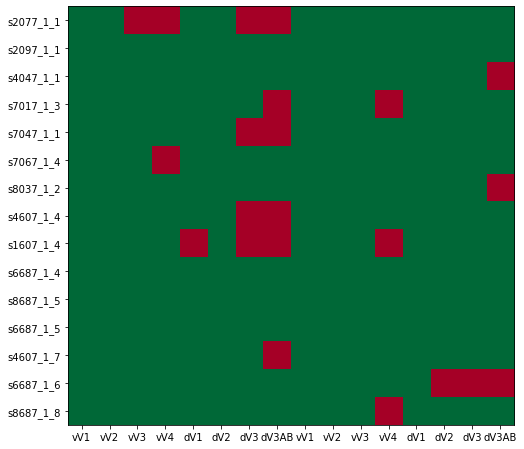

In [10]:
# Run the homotopy analysis as a way to pull out which areas are usable
homotopy_mats = homotopy_corr_mat(prefix = '', coder = '.areas_CE', sf_median_split=0)
labeled_areas = np.isnan(np.squeeze(homotopy_mats[:,0, :])) == 0

plt.figure(figsize=(8,8))
plt.imshow(labeled_areas.T, cmap='RdYlGn')

plt.yticks(np.arange(len(ppts_ordered)), ppts_ordered)
plt.xticks(np.arange(0, len(rois) * 2), rois + rois)

total_areas = np.sum(labeled_areas, 0) / 2
print('Areas per participant: %0.2f, range: %0.2f--%0.2f' % (np.mean(total_areas), np.min(total_areas), np.max(total_areas)))
      

Print the table that will be reported in the manuscript

In [11]:
table_df['Areas'] = list(total_areas) + [np.mean(total_areas)]

# Print the table    
print(table_df.to_latex(index=False, float_format=lambda x: '%.1f' % x))  

\begin{tabular}{lrlrlllllll}
\toprule
       ID &  Age & Sex &  Areas & ICA\_movies & ICA\_length & Num\_drop & Movie\_runs & ICA\_gaze & SRM\_movies & SRM\_gaze \\
\midrule
s2077\_1\_1 &  4.8 &   M &    6.0 &          1 &        430 &        0 &          1 &       97 &          1 &       97 \\
s2097\_1\_1 &  5.2 &   M &    8.0 &          1 &        186 &        0 &          1 &       96 &          1 &       96 \\
s4047\_1\_1 &  5.5 &   F &    7.5 &          1 &        186 &        0 &          1 &       99 &          1 &       99 \\
s7017\_1\_3 &  7.2 &   F &    7.0 &          4 &        744 &        2 &          2 &       97 &          2 &       98 \\
s7047\_1\_1 &  9.6 &   F &    7.0 &          1 &        432 &        0 &          1 &       91 &          1 &       91 \\
s7067\_1\_4 & 10.6 &   F &    7.5 &          6 &       1110 &        3 &          2 &       98 &          3 &       99 \\
s8037\_1\_2 & 12.2 &   F &    7.5 &          1 &        186 &        0 &          1 &       95

## Get details about the movies participants watched
Report how many infants and adults saw each movie. Break it down by whether they have or don't have retinotopy data

In [12]:
print('Total number of infants for each movie type')
total_retinotopy_ppts =[]
for movie_name in movie_infant_dict.keys():
    
    total_ppts = len(movie_infant_dict[movie_name])
    
    # Does this participant have retinotopy
    retinotopy_ppts = 0
    for ppt in SRM_retinotopy_infant.keys():
        if movie_name in SRM_retinotopy_infant[ppt]:
            retinotopy_ppts += 1
    
    print('%s\tRetinotopy: %d\tOther: %d\tTotal: %d' % (movie_name, retinotopy_ppts, total_ppts - retinotopy_ppts, total_ppts))


print('\nTotal number of adults for each movie type')
for movie_name in movie_adult_dict.keys():
    
    total_ppts = len(movie_adult_dict[movie_name])
    
    # Does this participant have retinotopy
    retinotopy_ppts = 0
    for ppt in SRM_retinotopy_adult.keys():
        if movie_name in SRM_retinotopy_adult[ppt]:
            retinotopy_ppts += 1
    
    
    print('%s\tRetinotopy: %d\tOther: %d\tTotal: %d' % (movie_name, retinotopy_ppts, total_ppts - retinotopy_ppts, total_ppts))

Total number of infants for each movie type
Child_Play	Retinotopy: 2	Other: 20	Total: 22
Catepillar	Retinotopy: 3	Other: 6	Total: 9
Meerkats	Retinotopy: 4	Other: 6	Total: 10
Mouseforsale	Retinotopy: 3	Other: 4	Total: 7
Aeronaut	Retinotopy: 8	Other: 35	Total: 43

Total number of adults for each movie type
Child_Play	Retinotopy: 8	Other: 9	Total: 17
Catepillar	Retinotopy: 8	Other: 0	Total: 8
Meerkats	Retinotopy: 8	Other: 0	Total: 8
Mouseforsale	Retinotopy: 8	Other: 0	Total: 8
Aeronaut	Retinotopy: 8	Other: 32	Total: 40


Get the age range of the participants used for SRM

In [13]:
for movie_name in SRM_movie_names:
    
    SRM_data_df = pd.read_csv('%s/SRM_participant_csv/%s.csv' % (predict_dir, movie_name), sep=',')
    ages = SRM_data_df['age']
    
    print('%s: M=%0.1f, range: %0.1f--%0.1f' % (movie_name, np.mean(ages), np.min(ages), np.max(ages)))

Child_Play: M=13.7, range: 3.3--32.0
Catepillar: M=13.0, range: 6.6--18.2
Meerkats: M=13.4, range: 7.2--18.2
Mouseforsale: M=14.7, range: 7.2--20.1
Aeronaut: M=10.1, range: 3.6--20.1


In [14]:
## Create a table that reports information about movie watching in participants

table_df = pd.DataFrame(columns=['Movie name', 'SRM', 'Ret. infants', 'Ret. adults', 'Infant SRM', 'Infant Ages', 'Adult SRM'])

# Get the movie names of everything infants saw, as well as whether there is a reference group to be used
movie_names = {'Child_Play': 1, 'Aeronaut': 1, 'Catepillar': 1, 'Meerkats': 1, 'Mouseforsale': 1, 'Elephant': 0, 'MadeinFrance': 0, 'Clocky': 0, 'Gopher': 0, 'Ballet': 0, 'Foxmouse': 0, 'Drop-Catepillar': 0, 'Drop-Meerkats': 0, 'Drop-Mouseforsale': 0, 'Drop-Elephant': 0, 'Drop-MadeinFrance': 0, 'Drop-Clocky': 0, 'Drop-Gopher': 0, 'Drop-Ballet': 0, 'Drop-Foxmouse': 0}

# Cycle through the movie names
for movie_name in movie_names.keys():
    
    # Determine whether this should be dropped or not
    if 'Drop-' in movie_name:
        is_drop = 1
        #movie_name = movie_name.split('-')[1] # Take the remaining name
    else:
        is_drop = 0
    
    # Count the number of infant and adult ppts with each movie type
    infant_ppts = []
    adult_ppts = []
    for ppt in retinotopy_ppt_movies.keys():
        for tmp_movie in retinotopy_ppt_movies[ppt]:
            
            # Skip all the other movie names
            if 'Child_Play' in tmp_movie:
                if tmp_movie != 'Child_Play-ball_play':
                    continue
            
            # Check if this is a matching movie, if so count it
            if is_drop == ('Drop' in tmp_movie):
                if is_drop == 1:
                    if movie_name.split('-')[1] in tmp_movie:
                        if ppt[0] == 's':
                            infant_ppts += [ppt]
                        else:
                            adult_ppts += [ppt]
                else:
                    if movie_name in tmp_movie:
                        if ppt[0] == 's':
                            infant_ppts += [ppt]
                        else:
                            adult_ppts += [ppt]
            
            
    # Count the number of participants that can be used per movie type
    if movie_name in movie_infant_dict:
        SRM_infant_others = len(movie_infant_dict[movie_name]) - len(infant_ppts)
        SRM_adult_others = len(movie_adult_dict[movie_name]) - len(adult_ppts)
    else:
        SRM_infant_others = 0
        SRM_adult_others = 0
    
    # Get the age range information for the other participants
    if movie_name in SRM_movie_names:
    
        SRM_data_df = pd.read_csv('%s/SRM_participant_csv/%s.csv' % (predict_dir, movie_name), sep=',')
        other_ages = SRM_data_df['age']

        age_info = '%0.1f (%0.1f--%0.1f)' % (np.mean(other_ages), np.min(other_ages), np.max(other_ages))
    else:
        age_info = ''

    # Make the row
    if len(infant_ppts) > 0:
        row = {'Movie name': movie_name, 'Ret. infants': len(infant_ppts), 'Ret. adults': len(adult_ppts), 'SRM': movie_names[movie_name], 'Infant SRM': SRM_infant_others, 'Infant Ages': age_info, 'Adult SRM': SRM_adult_others}

        table_df = table_df.append(row, ignore_index=True)

# Print the table    
print(table_df.to_latex(index=False)) 


\begin{tabular}{lllllll}
\toprule
       Movie name & SRM & Ret. infants & Ret. adults & Infant SRM &      Infant Ages & Adult SRM \\
\midrule
       Child\_Play &   1 &            2 &           8 &         20 & 13.7 (3.3--32.0) &         9 \\
         Aeronaut &   1 &            8 &           8 &         35 & 10.1 (3.6--20.1) &        32 \\
       Catepillar &   1 &            3 &           8 &          6 & 13.0 (6.6--18.2) &         0 \\
         Meerkats &   1 &            4 &           8 &          6 & 13.4 (7.2--18.2) &         0 \\
     Mouseforsale &   1 &            3 &           8 &          4 & 14.7 (7.2--20.1) &         0 \\
         Elephant &   0 &            1 &           0 &          0 &                  &         0 \\
     MadeinFrance &   0 &            1 &           0 &          0 &                  &         0 \\
           Clocky &   0 &            1 &           0 &          0 &                  &         0 \\
           Gopher &   0 &            1 &           0 &  

### Generate ideal gradient patterns
What result do you expect to find for the meridian and sf gradients? This can be used as a reference for the IC and SRM tests. To use these, set `use_ideal_lines` to `True`. These gradients are the hypothesesized optimal response, although the exact parameters (e.g. how much dampening) are just approximations.

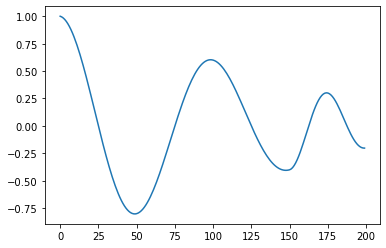

In [15]:
# 1.5 cycles plus 1 cycle
V1_V3_oscillation = np.sin((0.5 * np.pi) + np.arange(0, 1.5 * 2 * np.pi, (1.5 * 2 * np.pi) / 150))
V4_oscillation = np.sin((1.5 * np.pi) + np.arange(0, 2 * np.pi, (2 * np.pi) / 50)) 
oscillaton = np.append(V1_V3_oscillation, V4_oscillation)

# Linear function
dampening_func = np.arange(200) * (-0.8 / 200) + 1

meridian_ideal_temp = oscillaton * dampening_func

plt.plot(meridian_ideal_temp)

# Restructure it so it matches the real data
meridian_ideal = np.zeros((1, 200, 2, 2))
meridian_ideal[0, :, 0, 0] = meridian_ideal_temp
meridian_ideal[0, :, 0, 1] = meridian_ideal_temp
meridian_ideal[0, :, 1, 0] = meridian_ideal_temp
meridian_ideal[0, :, 1, 1] = meridian_ideal_temp

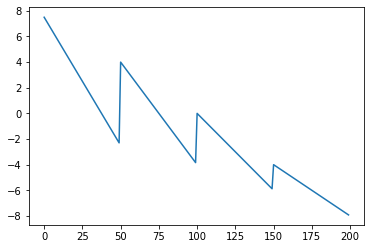

In [16]:
# 1.5 cycles plus 1 cycle
V1_slope = np.arange(50) * (-10 / 50) + 7.5
V2_slope = np.arange(50) * (-8 / 50) + 4
V3_slope = np.arange(50) * (-6 / 50)
V4_slope = np.arange(50) * (-4 / 50) - 4

sf_ideal_temp = np.hstack((V1_slope, V2_slope, V3_slope, V4_slope))
plt.plot(sf_ideal_temp)

# Restructure it so it matches the real data
sf_ideal = np.zeros((1, 200, 2, 2))
sf_ideal[0, :, 0, 0] = sf_ideal_temp
sf_ideal[0, :, 0, 1] = sf_ideal_temp
sf_ideal[0, :, 1, 0] = sf_ideal_temp
sf_ideal[0, :, 1, 1] = sf_ideal_temp


## Find out how many components were identified for each participant

In [17]:
files = glob.glob('%s/*' % (IC_code_dir))

total_TRs = []
meridian_ICs = []
SF_ICs = []
total_ICs = []
print('TRs\tSF ICs\tMeridian ICs\tTotal ICs\tParticipant\tMovie')
for file in files:
    
    # Get the IC labels
    labeled_ICs = np.loadtxt(file)

    # If it is only one IC then fix it
    if len(labeled_ICs.shape) == 1:
        labeled_ICs = labeled_ICs.reshape((1, 2))
    
    # Get the movie name
    if file.find('MM.txt') > 0:
        movie = 'MM'
    elif file.find('Child_Play.txt') > 0:
        movie = 'Child_Play'
    
    # Get the participant name
    ppt = file[file.find('IC_codes/') + 9:file.find(movie + '.txt') - 1]
    
    # Get the volume of the ICs
    IC_file = '%s/%s_%s.nii.gz' % (IC_vol_dir, ppt, movie)
    
    # Get the number of components
    meridian_IC = np.sum(labeled_ICs[:, 1] == 1)
    SF_IC = np.sum(labeled_ICs[:, 1] == 2)
    total_IC = nib.load(IC_file).shape[3]
    
    # Get the number of TRs for this participant
    concat_file = '%s/concat_movies/%s_%s.nii.gz' % (predict_dir, ppt, movie)
    total_TR = nib.load(concat_file).shape[3]
    
    print('TR=%d\tSF=%d\tMeridian=%d\tTotal=%d\t%s\t%s' % (total_TR, SF_IC, meridian_IC, total_IC, ppt, movie))
    
    # Add to the list
    total_TRs += [total_TR]
    meridian_ICs += [meridian_IC]
    SF_ICs += [SF_IC]
    total_ICs += [total_IC]

print('\n\nAverage TRs: %0.1f (%0.1f) %d-%d' % (np.nanmean(total_TRs), np.nanstd(total_TRs), np.nanmin(total_TRs), np.nanmax(total_TRs)))    
print('Average meridian ICs: %0.1f (%0.1f) %d-%d' % (np.mean(meridian_ICs), np.std(meridian_ICs), np.min(meridian_ICs), np.max(meridian_ICs)))    
print('Average SF ICs: %0.1f (%0.1f) %d-%d' % (np.mean(SF_ICs), np.std(SF_ICs), np.min(SF_ICs), np.max(SF_ICs)))    
print('Average total ICs: %0.1f (%0.1f) %d-%d' % (np.mean(total_ICs), np.std(total_ICs), np.min(total_ICs), np.max(total_ICs)))    
      

TRs	SF ICs	Meridian ICs	Total ICs	Participant	Movie
TR=186	SF=1	Meridian=0	Total=61	s1607_1_4	MM
TR=465	SF=3	Meridian=1	Total=86	s6687_1_5	MM
TR=93	SF=2	Meridian=1	Total=32	s6687_1_4	MM
TR=279	SF=3	Meridian=0	Total=86	s4607_1_4	MM
TR=372	SF=2	Meridian=0	Total=74	s7017_1_3	MM
TR=93	SF=0	Meridian=2	Total=37	s4047_1_1	MM
TR=93	SF=2	Meridian=2	Total=36	s8687_1_5	MM
TR=215	SF=2	Meridian=0	Total=61	s2077_1_1	Child_Play
TR=216	SF=4	Meridian=2	Total=74	s7047_1_1	Child_Play
TR=372	SF=2	Meridian=1	Total=78	s4607_1_7	MM
TR=558	SF=4	Meridian=0	Total=132	s6687_1_6	MM
TR=372	SF=3	Meridian=4	Total=115	s8687_1_8	MM
TR=93	SF=1	Meridian=1	Total=31	s8037_1_2	MM
TR=555	SF=5	Meridian=1	Total=167	s7067_1_4	MM


Average TRs: 283.0 (162.4) 93-558
Average meridian ICs: 1.1 (1.1) 0-4
Average SF ICs: 2.4 (1.3) 0-5
Average total ICs: 76.4 (38.4) 31-167


# Do the homotopy analysis for the movie data <a id='homology'></a>
Like in Arcaro and Livingstone (2017), compare the correlation between hemispheres for the different areas that are labeled. If a timecourse of activity in an area is correlated between hemispheres then this suggests that activity is stimulus driven. If the similarity is higher when matching areas (e.g., left V1 and right V1) vs. non-matching (left V1 and right V2) then that means the areas are functionally differentiated

Make 1d files with the func data for the movies. 1d files are text files that reshape the brain data into a surface. There are different file types, but the consistent idea is that each row is a node in surface space and each column is either info about the node (e.g., the coordinate) or the intensity value of the node. 

This code will not run if these already exist, but will take a long time if they don't exist.

In [18]:
if skip_surf_generation == 0:
    print('### THIS WILL TAKE A WHILE TO RUN THE FIRST TIME BUT ONLY NEEDS TO RUN ONCE ###\n\n')
    for ppt in ppts_ordered:

        # Make the directory for each participant
        out_dir = '%s/movie_1d/' % predict_dir

        SUMA_folder = '%s/iBEAT/%s/SUMA/' % (retinotopy_dir, ppt)

        # Doe this participant have movies
        if ppt in retinotopy_ppt_movies:

            # Get the func used for the input to ICA
            func = glob.glob('%s/concat_movies/%s_*.nii.gz' % (predict_dir, ppt))[0]

            # Get the columns to pull out
            first_TR_column = 6 # This is the column of the 1d data that contains functional data, although it could differ with different data
            movie_length = nib.load(func).shape[3] + first_TR_column - 1 # When should be the last column?

            # Cycle through the hemispheres
            for hemi in ['lh', 'rh']:

                out_file = '%s/%s.%s.1d.dset' % (out_dir, hemi, ppt)
                spec_file = '%s/iBEAT_%s.spec' % (SUMA_folder, hemi)

                if os.path.exists(out_file) == 0:

                    # Run the output
                    os.system('3dVol2Surf -spec %s -sv %s -out_1D %s -surf_A smoothwm -grid_parent %s -map_func mask' % (spec_file, func, out_file, func))

                    # Only take the last column, the data you care about
                    os.system('1dcat -sel ''[%d:%d]'' %s > temp.txt' % (first_TR_column, movie_length, out_file))

                    # Rename (doesn't work to store with this name if it already exists)
                    os.system('mv temp.txt %s' % (out_file))

                    print('Created', out_file)
else:
    print('############################################\n### Skipping the generation of surfaces! ###\n############################################')

### THIS WILL TAKE A WHILE TO RUN THE FIRST TIME BUT ONLY NEEDS TO RUN ONCE ###




Now make the surfaces for standard space (so that you can use the Wang atlas). This cell submits jobs to be run on a cluster that take the surfaces generated above and realigns them to standard space

In [19]:
if skip_surf_generation == 0:
    for ppt in ppts_ordered:
    
        out_dir = '%s/movie_1d/' % (predict_dir)
        SUMA_folder = '%s/iBEAT/%s/SUMA/' % (retinotopy_dir, ppt)

        for hemi_counter, hemi in enumerate(['lh', 'rh']):

            func_file = '%s/%s.%s.1d.dset' % (out_dir, hemi, ppt)
            output_file = '%s/std.141.%s.%s.1D' % (out_dir, hemi, ppt)
            if os.path.exists(output_file) == 0:
                os.system('sbatch ./scripts/predict_retinotopy/transform_surface_2_standard.sh %s %s %s %s std.141.' % (SUMA_folder, func_file, hemi, out_dir))

else:
    print('############################################\n### Skipping the generation of surfaces! ###\n############################################')            

Once all of the files are made, do the actual comparisons. Firstly, conduct the homotopy analysis using the task-defined retinotopy areas.

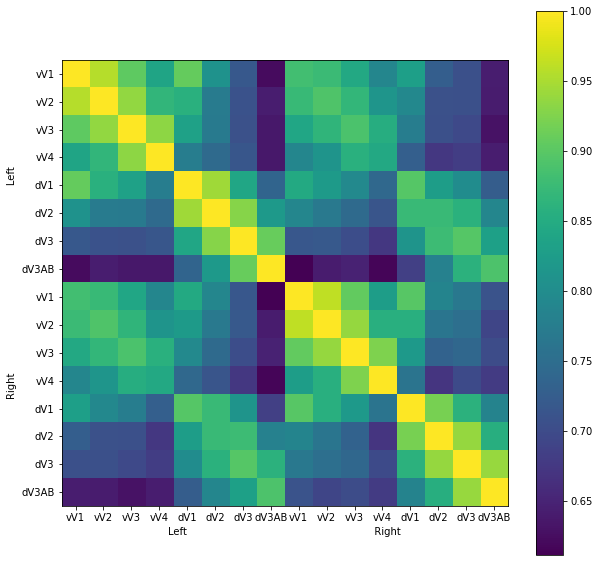

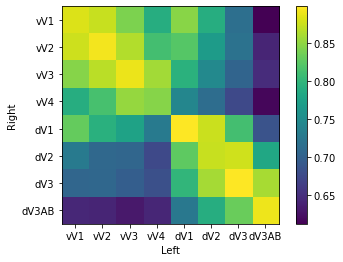

In [20]:
# Generate the homotopy correlations for the drawn areas
sf_median_split=0 # Median split the SF (for a proxy of foveal vs eccentric)
corr_mats = homotopy_corr_mat(prefix = '', coder = '.areas_CE', sf_median_split=sf_median_split)

# Average the matrices across participants
av_corr_mat = np.tanh(np.nanmean(corr_mats, 2))

# Get the overall plot
plt.figure(figsize=(10,10))
plt.imshow(av_corr_mat)
plt.yticks(np.arange(0, len(rois) * 2 * (sf_median_split + 1), (sf_median_split + 1)), rois + rois)
plt.ylabel('Right                                                            Left')
plt.xticks(np.arange(0, len(rois) * 2 * (sf_median_split + 1), (sf_median_split + 1)), rois + rois)
plt.xlabel('Left                                                            Right')
plt.colorbar()

# Get just the interhemispheric plot
plt.figure()
plt.imshow(av_corr_mat[len(rois) * (sf_median_split + 1):, :len(rois) * (sf_median_split + 1)])
plt.yticks(np.arange(0, len(rois) * (sf_median_split + 1), (sf_median_split + 1)), rois)
plt.xticks(np.arange(0, len(rois) * (sf_median_split + 1), (sf_median_split + 1)), rois)
plt.xlabel('Left')
plt.ylabel('Right')
plt.colorbar()
plt.savefig(plot_dir + '/homotopy_similarity.svg')

In [21]:
# Report the range of values on the diagonal
temp_mat = av_corr_mat[len(rois) * (sf_median_split + 1):, :len(rois) * (sf_median_split + 1)]
homotope_corrs = temp_mat[np.diag_indices(len(temp_mat))]

print('Correlation of homotopic regions: M=%0.2f (%0.2f--%0.2f)' % (np.mean(homotope_corrs), np.min(homotope_corrs), np.max(homotope_corrs)))


Correlation of homotopic regions: M=0.88 (0.85--0.90)


Are regions more similar across hemisphere within dorsal and ventral than between?

/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


Within stream > Between stream: 0.42, p=0.000
Correlation between age and difference in streams: 0.63, p=0.002
Correlation between movie length and difference in streams: 0.08, p=0.700


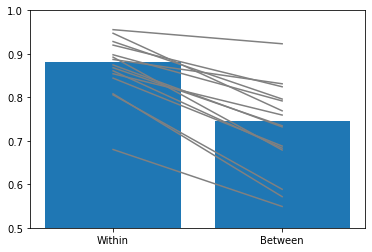

In [22]:
# Get the homotopy mat
homotopy_mats = corr_mats[len(rois):, :len(rois), :]

similarity_vals = np.zeros((homotopy_mats.shape[2], 2))

for ppt_counter in range(homotopy_mats.shape[2]):
    
    homotopy_mat = homotopy_mats[:, :, ppt_counter]
    
    within_stream = np.diag(homotopy_mat, 0)

    between_stream = np.concatenate((np.diag(homotopy_mat, 4), np.diag(homotopy_mat, -4)))

    similarity_vals[ppt_counter, :] = [np.nanmean(within_stream), np.nanmean(between_stream)]
    
plt.figure()
plt.bar(np.arange(2), np.tanh(np.nanmean(similarity_vals, 0)), Zorder=0)
plt.plot(np.tanh(similarity_vals.T), color = [0.5, 0.5, 0.5])
plt.xticks([0, 1], ['Within', 'Between'])
plt.ylim([0.5, 1])
plt.savefig(plot_dir + '/homotopy_within_between_stream_bar.svg')

diff_vals = similarity_vals[:, 0] - similarity_vals[:, 1]
diff_vals = diff_vals[np.isnan(diff_vals) == 0]
[p_val, _, _] = randomise_diff(diff_vals)
print('Within stream > Between stream: %0.2f, p=%0.3f' % (np.mean(diff_vals), p_val)) 

# Compute correlations of various things
x = ages_ordered
y = diff_vals
print('Correlation between age and difference in streams: %0.2f, p=%0.3f' % (np.corrcoef(x, y)[0, 1], randomise_corr(x, y))) 

x = movie_length_ordered
y = diff_vals
print('Correlation between movie length and difference in streams: %0.2f, p=%0.3f' % (np.corrcoef(x, y)[0, 1], randomise_corr(x, y))) 



Do homotopy analyses, comparing homotopic, adjacent and distal ROIs

/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


Homotope > Adjacent: 0.09, p=0.000
Correlation between age and difference: 0.09, p=0.741
Correlation between movie length and difference: -0.01, p=0.965
Adjacent > Distal: 0.20, p=0.000
Correlation between age and difference: 0.30, p=0.115
Correlation between movie length and difference: -0.09, p=0.740
Homotope > Distal: 0.29, p=0.000
Correlation between age and difference: 0.21, p=0.322
Correlation between movie length and difference: -0.05, p=0.799


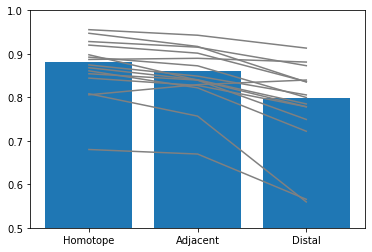

In [23]:
# Compare the similarity bilaterally for identical, adjacent, and distal ROIs
homotopy_mats = corr_mats[len(rois):, :len(rois), :]

# Preset
similarity_vals = np.zeros((homotopy_mats.shape[2], 3))

for ppt_counter in range(homotopy_mats.shape[2]):
    homotopy_mat = homotopy_mats[:, :, ppt_counter]

    # Get all of the diagonal
    identical_vals = list(np.diag(homotopy_mat, 0))

    # Get the first off diagonal but ignore values that are between ventral and dorsal
    adjacent_vals = []
    for sign in [-1, 1]:
        tmp_adjacent_vals = np.diag(homotopy_mat, 1 * sign)
        if homotopy_mats.shape[0] == 8:
            included_idxs = [0, 1, 2, 4, 5, 6] # HARD CODING 
        else:
            included_idxs = []
        adjacent_vals += list(tmp_adjacent_vals[included_idxs])

    # Get the other off diagonals but ignore values that are between ventral and dorsal
    distal_vals = []
    for sign in [-1, 1]:
        tmp_distal_vals = np.diag(homotopy_mat, 2 * sign)
        if homotopy_mats.shape[0] == 8:
            included_idxs = [0, 1, 4, 5] # HARD CODING 
        else:
            included_idxs = []
        distal_vals += list(tmp_distal_vals[included_idxs])

        tmp_distal_vals = np.diag(homotopy_mat, 3 * sign)
        if homotopy_mats.shape[0] == 8:
            included_idxs = [0, 4] # HARD CODING 
        else:
            included_idxs = []
        distal_vals += list(tmp_distal_vals[included_idxs])

    similarity_vals[ppt_counter, :] = [np.nanmean(identical_vals), np.nanmean(adjacent_vals), np.nanmean(distal_vals)]
    
plt.figure()
plt.bar(np.arange(3), np.tanh(np.nanmean(similarity_vals, 0)), Zorder=0)
plt.plot(np.tanh(similarity_vals.T), color = [0.5, 0.5, 0.5])
plt.xticks([0, 1, 2], ['Homotope', 'Adjacent', 'Distal'])
plt.ylim([0.5, 1])
plt.savefig(plot_dir + '/homotopy_distance_bar.svg')

diff_vals = similarity_vals[:, 0] - similarity_vals[:, 1]
diff_vals = diff_vals[np.isnan(diff_vals) == 0]
[p_val, _, _] = randomise_diff(diff_vals)
print('Homotope > Adjacent: %0.2f, p=%0.3f' % (np.mean(diff_vals), p_val))

# Compute correlations of various things
x = ages_ordered
y = diff_vals
print('Correlation between age and difference: %0.2f, p=%0.3f' % (np.corrcoef(x, y)[0, 1], randomise_corr(x, y))) 

x = movie_length_ordered
y = diff_vals
print('Correlation between movie length and difference: %0.2f, p=%0.3f' % (np.corrcoef(x, y)[0, 1], randomise_corr(x, y))) 

diff_vals = similarity_vals[:, 1] - similarity_vals[:, 2]
diff_vals = diff_vals[np.isnan(diff_vals) == 0]
[p_val, _, _] = randomise_diff(diff_vals)
print('Adjacent > Distal: %0.2f, p=%0.3f' % (np.mean(diff_vals), p_val))

# Compute correlations of various things
x = ages_ordered
y = diff_vals
print('Correlation between age and difference: %0.2f, p=%0.3f' % (np.corrcoef(x, y)[0, 1], randomise_corr(x, y))) 

x = movie_length_ordered
y = diff_vals
print('Correlation between movie length and difference: %0.2f, p=%0.3f' % (np.corrcoef(x, y)[0, 1], randomise_corr(x, y))) 

diff_vals = similarity_vals[:, 0] - similarity_vals[:, 2]
diff_vals = diff_vals[np.isnan(diff_vals) == 0]
[p_val, _, _] = randomise_diff(diff_vals)
print('Homotope > Distal: %0.2f, p=%0.3f' % (np.mean(diff_vals), p_val))

# Compute correlations of various things
x = ages_ordered
y = diff_vals
print('Correlation between age and difference: %0.2f, p=%0.3f' % (np.corrcoef(x, y)[0, 1], randomise_corr(x, y))) 

x = movie_length_ordered
y = diff_vals
print('Correlation between movie length and difference: %0.2f, p=%0.3f' % (np.corrcoef(x, y)[0, 1], randomise_corr(x, y))) 


Make an MDS of the data. This is not shown in the manuscript but is included here for reference

2d stress: 0.0035336413822817034


/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/sklearn/manifold/_mds.py:441: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


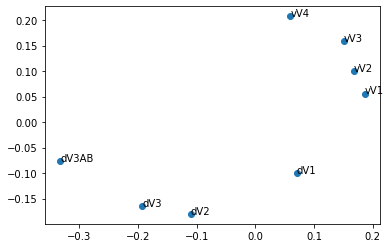

In [24]:
# Create the 2d MDS
embedding = mds(n_components=2)

# Crop ROIs
av_corr_mat = av_corr_mat[len(rois):, :len(rois)]

mds_fit = embedding.fit(av_corr_mat)
print('2d stress:', mds_fit.stress_)

plt.figure()
plt.scatter(mds_fit.embedding_[:, 0], mds_fit.embedding_[:, 1])
for i in range(len(rois)):
    plt.text(mds_fit.embedding_[i, 0], mds_fit.embedding_[i, 1], rois[i])

Use the Wang atlas (rather than traced ROIs) for each participant to conduct the homotopy analysis

In [25]:
# What category is an ROI in? 0 is dorsal, 1 is ventral, 2 is IPS
if include_IPS:
    Wang_rois_category = [1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    Wang_exclude_idx = len(Wang_rois_category) # What is the last idx to be included
else:
    Wang_rois_category = [1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2]
    Wang_exclude_idx = 17 # What is the last idx to be included

print('Dorsal ROIs:')
print(np.asarray(Wang_rois)[np.asarray(Wang_rois_category) == 0])

print('Ventral ROIs:')
print(np.asarray(Wang_rois)[np.asarray(Wang_rois_category) == 1])

print('Ignored ROIs:')
print(np.asarray(Wang_rois)[np.asarray(Wang_rois_category) == 2])


Dorsal ROIs:
['V1d' 'V2d' 'V3d' 'MST' 'hMT' 'LO2' 'LO1' 'V3b' 'V3a']
Ventral ROIs:
['V1v' 'V2v' 'V3v' 'hV4' 'VO1' 'VO2' 'PHC1' 'PHC2']
Ignored ROIs:
['IPS0' 'IPS1' 'IPS2' 'IPS3' 'IPS4' 'IPS5' 'SPL1' 'FEF']


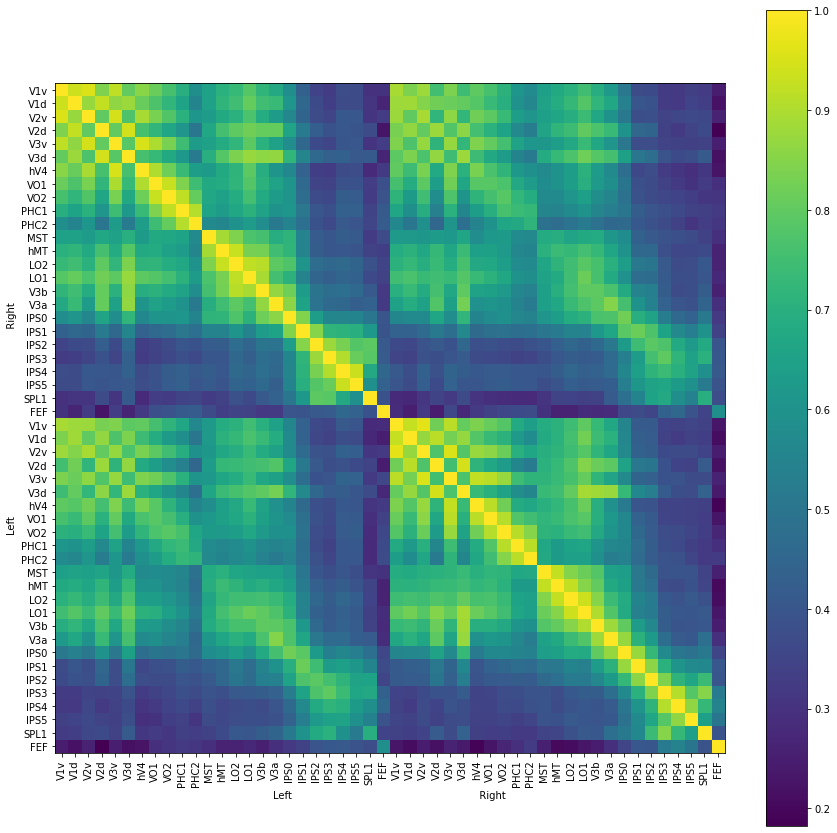

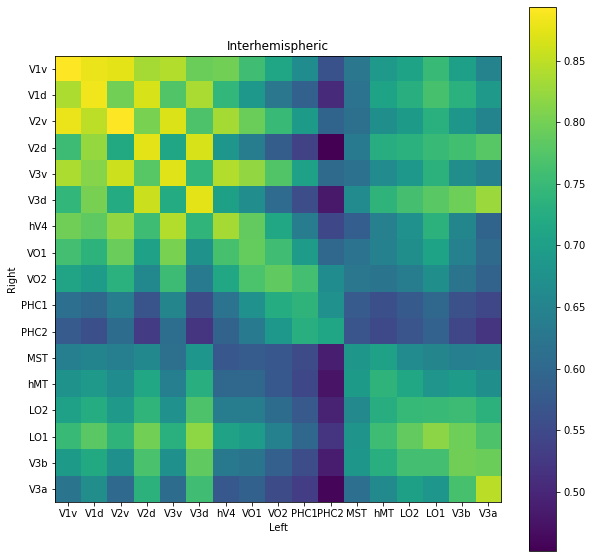

In [26]:
# Get the matrices
corr_mats = homotopy_corr_mat(prefix = 'std.141.', coder = 'Wang')

# Average the matrices across participants
av_corr_mat = np.tanh(np.nanmean(corr_mats, 2))

# Get the overall plot
plt.figure(figsize=(15,15))
plt.imshow(av_corr_mat)
plt.yticks(np.arange(len(Wang_rois) * 2), Wang_rois + Wang_rois)
plt.ylabel('Left                                                            Right')
plt.xticks(np.arange(len(Wang_rois) * 2), Wang_rois + Wang_rois, rotation=90)
plt.xlabel('Left                                                            Right')
plt.colorbar()

# Get just the interhemispheric plot
plt.figure(figsize=(10,10))

# Crop ROIs
av_corr_mat = av_corr_mat[len(Wang_rois):, :len(Wang_rois)]
av_corr_mat = av_corr_mat[:Wang_exclude_idx, :Wang_exclude_idx]

plt.imshow(av_corr_mat)
plt.yticks(np.arange(Wang_exclude_idx), Wang_rois[:Wang_exclude_idx])
plt.xticks(np.arange(Wang_exclude_idx), Wang_rois[:Wang_exclude_idx])
plt.title('Interhemispheric')
plt.xlabel('Left')
plt.ylabel('Right')
plt.colorbar()
plt.savefig(plot_dir + '/homotopy_similarity_Wang.svg')

Plot the MDS. The 2D embedding is the MDS reported in the paper. The 3d embedding is shown for reference

/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/sklearn/manifold/_mds.py:441: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/sklearn/manifold/_mds.py:441: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


2d stress: 0.07607438138303532
3d stress: 0.04657720115212184


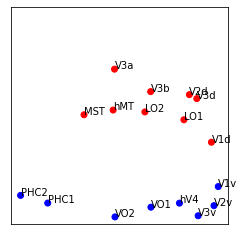

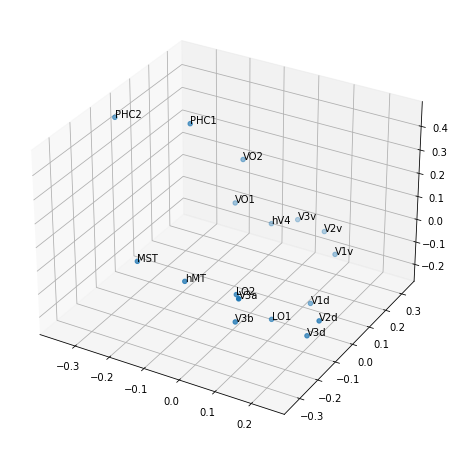

In [27]:
# Set the seed here to plan for the rotation
np.random.seed(0)

# Create the 2d MDS
embedding = mds(n_components=2)

mds_fit = embedding.fit(av_corr_mat)
print('2d stress:', mds_fit.stress_)

# Make the colors
MDS_colors = np.asarray(['r', 'b', 'g'])

coords = rotate_coordinates(mds_fit.embedding_, degrees = 60)

plt.figure()
plt.scatter(coords[:, 0], coords[:, 1], c=MDS_colors[Wang_rois_category][:Wang_exclude_idx])
for i in range(Wang_exclude_idx):
    plt.text(coords[i, 0], coords[i, 1], Wang_rois[i])

plt.xticks([])
plt.yticks([])
plt.axis('square')    
    
plt.savefig(plot_dir + '/homotopy_Wang_MDS_2d.svg')    
    
# Create the 3d MDS
embedding = mds(n_components=3)
mds_fit = embedding.fit(av_corr_mat)
print('3d stress:', mds_fit.stress_)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(mds_fit.embedding_[:, 0], mds_fit.embedding_[:, 1], mds_fit.embedding_[:, 2])
for i in range(Wang_exclude_idx):
    ax.text(mds_fit.embedding_[i, 0], mds_fit.embedding_[i, 1], mds_fit.embedding_[i, 2], Wang_rois[i])    


Get the Wang atlas ROIs that match what we traced retinotopically, then do the same analyses. These results are partially shown in the supplement

In [28]:
# Get the matrices
corr_mats = homotopy_corr_mat(prefix = 'std.141.', coder = 'Wang_reduced')

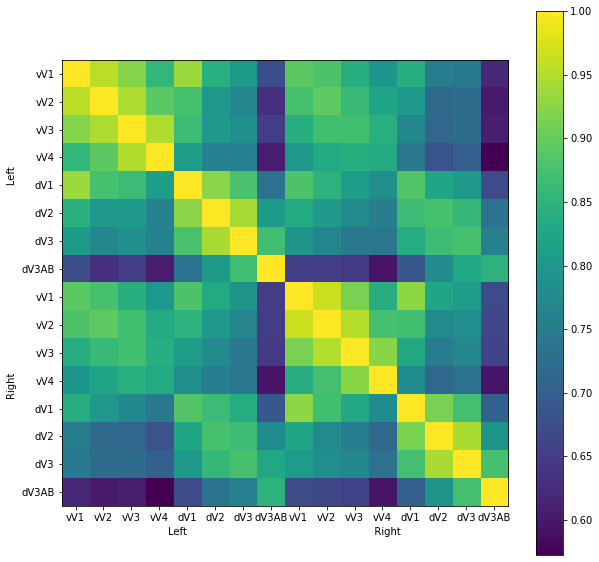

In [29]:
# Average the matrices across participants
sf_median_split = 0
av_corr_mat = np.tanh(np.nanmean(corr_mats, 2))

# Get the overall plot
plt.figure(figsize=(10,10))
plt.imshow(av_corr_mat)
plt.yticks(np.arange(0, len(rois) * 2 * (sf_median_split + 1), (sf_median_split + 1)), rois + rois)
plt.ylabel('Right                                                            Left')
plt.xticks(np.arange(0, len(rois) * 2 * (sf_median_split + 1), (sf_median_split + 1)), rois + rois)
plt.xlabel('Left                                                            Right')
plt.colorbar()

/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


Within stream > Between stream: 0.37, p=0.000
Correlation between age and difference in streams: 0.27, p=0.222
Correlation between movie length and difference in streams: -0.18, p=0.496


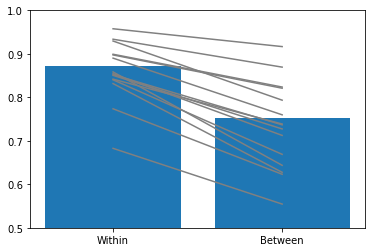

In [30]:
# Get the homotopy mat
homotopy_mats = corr_mats[len(rois):, :len(rois), :]

similarity_vals = np.zeros((homotopy_mats.shape[2], 2))

for ppt_counter in range(homotopy_mats.shape[2]):
    
    homotopy_mat = homotopy_mats[:, :, ppt_counter]
    
    within_stream = np.diag(homotopy_mat, 0)

    between_stream = np.concatenate((np.diag(homotopy_mat, 4), np.diag(homotopy_mat, -4)))

    similarity_vals[ppt_counter, :] = [np.nanmean(within_stream), np.nanmean(between_stream)]
    
plt.figure()
plt.bar(np.arange(2), np.tanh(np.nanmean(similarity_vals, 0)), Zorder=0)
plt.plot(np.tanh(similarity_vals.T), color = [0.5, 0.5, 0.5])
plt.xticks([0, 1], ['Within', 'Between'])
plt.ylim([0.5, 1])
plt.savefig(plot_dir + '/homotopy_within_between_stream_bar_Wang.svg')

diff_vals = similarity_vals[:, 0] - similarity_vals[:, 1]
diff_vals = diff_vals[np.isnan(diff_vals) == 0]
[p_val, _, _] = randomise_diff(diff_vals)
print('Within stream > Between stream: %0.2f, p=%0.3f' % (np.mean(diff_vals), p_val))   

# Compute correlations of various things
x = ages_ordered
y = diff_vals
print('Correlation between age and difference in streams: %0.2f, p=%0.3f' % (np.corrcoef(x, y)[0, 1], randomise_corr(x, y))) 

x = movie_length_ordered
y = diff_vals
print('Correlation between movie length and difference in streams: %0.2f, p=%0.3f' % (np.corrcoef(x, y)[0, 1], randomise_corr(x, y))) 


/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


Homotope > Adjacent: 0.09, p=0.000
Correlation between age and difference: 0.11, p=0.633
Correlation between movie length and difference: -0.15, p=0.493
Adjacent > Distal: 0.18, p=0.000
Correlation between age and difference: 0.08, p=0.680
Correlation between movie length and difference: -0.49, p=0.028
Homotope > Distal: 0.27, p=0.000
Correlation between age and difference: 0.11, p=0.617
Correlation between movie length and difference: -0.41, p=0.052


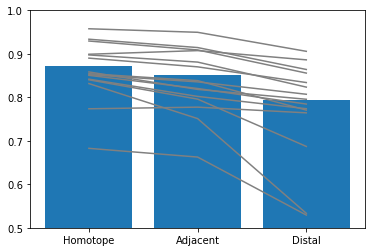

In [31]:
# Compare the similarity bilaterally for identical, adjacent, and distal ROIs
homotopy_mats = corr_mats[len(rois):, :len(rois), :]

# Preset
similarity_vals = np.zeros((homotopy_mats.shape[2], 3))

for ppt_counter in range(homotopy_mats.shape[2]):
    homotopy_mat = homotopy_mats[:, :, ppt_counter]

    # Get all of the diagonal
    identical_vals = list(np.diag(homotopy_mat, 0))

    # Get the first off diagonal but ignore values that are between ventral and dorsal
    adjacent_vals = []
    for sign in [-1, 1]:
        tmp_adjacent_vals = np.diag(homotopy_mat, 1 * sign)
        if homotopy_mats.shape[0] == 8:
            included_idxs = [0, 1, 2, 4, 5, 6] # HARD CODING 
        else:
            included_idxs = []
        adjacent_vals += list(tmp_adjacent_vals[included_idxs])

    # Get the other off diagonals but ignore values that are between ventral and dorsal
    distal_vals = []
    for sign in [-1, 1]:
        tmp_distal_vals = np.diag(homotopy_mat, 2 * sign)
        if homotopy_mats.shape[0] == 8:
            included_idxs = [0, 1, 4, 5] # HARD CODING 
        else:
            included_idxs = []
        distal_vals += list(tmp_distal_vals[included_idxs])

        tmp_distal_vals = np.diag(homotopy_mat, 3 * sign)
        if homotopy_mats.shape[0] == 8:
            included_idxs = [0, 4] # HARD CODING 
        else:
            included_idxs = []
        distal_vals += list(tmp_distal_vals[included_idxs])

    similarity_vals[ppt_counter, :] = [np.nanmean(identical_vals), np.nanmean(adjacent_vals), np.nanmean(distal_vals)]
    
plt.figure()
plt.bar(np.arange(3), np.tanh(np.nanmean(similarity_vals, 0)), Zorder=0)
plt.plot(np.tanh(similarity_vals.T), color = [0.5, 0.5, 0.5])
plt.xticks([0, 1, 2], ['Homotope', 'Adjacent', 'Distal'])
plt.ylim([0.5, 1])
plt.savefig(plot_dir + '/homotopy_distance_bar_Wang.svg')

diff_vals = similarity_vals[:, 0] - similarity_vals[:, 1]
diff_vals = diff_vals[np.isnan(diff_vals) == 0]
[p_val, _, _] = randomise_diff(diff_vals)
print('Homotope > Adjacent: %0.2f, p=%0.3f' % (np.mean(diff_vals), p_val))

# Compute correlations of various things
x = ages_ordered
y = diff_vals
print('Correlation between age and difference: %0.2f, p=%0.3f' % (np.corrcoef(x, y)[0, 1], randomise_corr(x, y))) 

x = movie_length_ordered
y = diff_vals
print('Correlation between movie length and difference: %0.2f, p=%0.3f' % (np.corrcoef(x, y)[0, 1], randomise_corr(x, y))) 

diff_vals = similarity_vals[:, 1] - similarity_vals[:, 2]
diff_vals = diff_vals[np.isnan(diff_vals) == 0]
[p_val, _, _] = randomise_diff(diff_vals)
print('Adjacent > Distal: %0.2f, p=%0.3f' % (np.mean(diff_vals), p_val))

# Compute correlations of various things
x = ages_ordered
y = diff_vals
print('Correlation between age and difference: %0.2f, p=%0.3f' % (np.corrcoef(x, y)[0, 1], randomise_corr(x, y))) 

x = movie_length_ordered
y = diff_vals
print('Correlation between movie length and difference: %0.2f, p=%0.3f' % (np.corrcoef(x, y)[0, 1], randomise_corr(x, y))) 

diff_vals = similarity_vals[:, 0] - similarity_vals[:, 2]
diff_vals = diff_vals[np.isnan(diff_vals) == 0]
[p_val, _, _] = randomise_diff(diff_vals)
print('Homotope > Distal: %0.2f, p=%0.3f' % (np.mean(diff_vals), p_val))

# Compute correlations of various things
x = ages_ordered
y = diff_vals
print('Correlation between age and difference: %0.2f, p=%0.3f' % (np.corrcoef(x, y)[0, 1], randomise_corr(x, y))) 

x = movie_length_ordered
y = diff_vals
print('Correlation between movie length and difference: %0.2f, p=%0.3f' % (np.corrcoef(x, y)[0, 1], randomise_corr(x, y))) 


Make an MDS of the data. This is not shown in the manuscript but is included here for reference

2d stress: 0.0040421701836685685


/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/sklearn/manifold/_mds.py:441: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


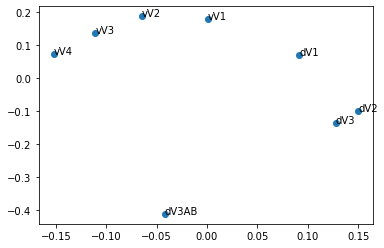

In [32]:
# Create the 2d MDS
embedding = mds(n_components=2)

# Crop ROIs
av_corr_mat = av_corr_mat[len(rois):, :len(rois)]

mds_fit = embedding.fit(av_corr_mat)
print('2d stress:', mds_fit.stress_)

plt.figure()
plt.scatter(mds_fit.embedding_[:, 0], mds_fit.embedding_[:, 1])
for i in range(len(rois)):
    plt.text(mds_fit.embedding_[i, 0], mds_fit.embedding_[i, 1], rois[i])

## Evaluate ICA components against real retinotopy maps <a id='ica'></a>

Take in the ICA results from MELODIC, convert them into surface space and then find the values of the components along the gradient lines we traced. Compare the ICs with the real data to get a sense of how well ICA can recover retinotopic maps

The command to run the ICA was: `melodic -i analysis/secondlevel_${MOVIE}/default/NIFTI/func2highres_${MOVIE}_Z.nii.gz -o analysis/secondlevel_${MOVIE}/default/func2highres_${MOVIE}_Z.ica -v --nobet --bgthreshold=1 --tr=2 -d 0 --mmthresh=0.5 --report --guireport=analysis/secondlevel_${MOVIE}/default/func2highres_${MOVIE}_Z.ica/report.html`. This was run in each participant's directory with `${MOVIE}` set to either `MM` or `ChildPlay`. The `melodic_IC.nii.gz` output was taken from this directory and used for these analyses.

Take in the lines drawn for each participant. Must use the original ROI files since they are ordered posterior to anterior. File has the name `??h.lines.niml.roi` where the first letter is either d(orsal) or v(entral) and the second is either l(eft) or r(ight). This file cannot be converted into a 1D file because otherwise it will collapse all of the labels with the same name. These files are then used to index functional values on the surface and the values are averaged across the redundant lines drawn within or across regions.

To make this work, the functional data must be converted to 1d.dset files. This step is done in the following loop, taking all the ICA and SRM files that are available for each participant and running the conversion.

In [33]:
# Run for ICs that were selected
if skip_surf_generation == 0:
    print('### THIS WILL TAKE A WHILE TO RUN THE FIRST TIME BUT ONLY NEEDS TO RUN ONCE ###\n\n')
    for movie_type in ['MM', 'Child_Play']:

        for ppt in ppts_ordered:

            # Where is the SUMA file
            SUMA_folder = '%s/iBEAT/%s/SUMA/' % (retinotopy_dir, ppt)

            # Load the IC data of interest
            melodic_name = '%s/IC_vols/%s_%s.nii.gz' % (predict_dir, ppt, movie_type)

            # Check this file exists before trying to load it
            if os.path.exists(melodic_name):

                # Compute the total ICs
                total_ICs = nib.load(melodic_name).shape[3]

                # Cycle through ICs
                for IC in range(total_ICs):

                    # Get the IC used
                    out_file_root = 'IC_%d' % (IC)

                    if (os.path.exists('%s/IC_surfs/%s/lh.%s.1d.dset' % (predict_dir, ppt, out_file_root)) == 0) or (os.path.exists('%s/predictions/rh.%s.1d.dset' % (SUMA_folder, out_file_root)) == 0):

                        # Cycle through the hemispheres
                        for hemi in ['lh', 'rh']:

                            out_file = '%s/IC_surfs/%s/%s.%s.1d.dset' % (predict_dir, ppt, hemi, out_file_root)
                            spec_file = '%s/iBEAT_%s.spec' % (SUMA_folder, hemi)

                            if os.path.exists(out_file) == 0:

                                # If this file doesnt exist then make the temp file
                                if hemi == 'lh':
                                    func = 'temp_%s.nii.gz' % out_file_root
                                    os.system('fslroi %s %s %d 1' % (melodic_name, func, IC))

                                # Run the output
                                os.system('3dVol2Surf -spec %s -sv %s -out_1D %s -surf_A smoothwm -grid_parent %s -map_func mask' % (spec_file, func, out_file, func))

                                # Only take the last column, the data you care about
                                os.system('1dcat -sel ''[6]'' %s > temp_%s.txt' % (out_file, out_file_root))

                                # Rename (doesn't work to store with this name if it already exists)
                                os.system('mv temp_%s.txt %s' % (out_file_root, out_file))

                                print('Created', out_file)

                        if os.path.exists('temp_%s.nii.gz' % out_file_root) == 0:
                            os.system('rm -f temp_%s.nii.gz' % out_file_root)
            print('Finished', ppt)

else:
    print('############################################\n### Skipping the generation of surfaces! ###\n############################################')

### THIS WILL TAKE A WHILE TO RUN THE FIRST TIME BUT ONLY NEEDS TO RUN ONCE ###


Finished s2077_1_1
Finished s2097_1_1
Finished s4047_1_1
Finished s7017_1_3
Finished s7047_1_1
Finished s7067_1_4
Finished s8037_1_2
Finished s4607_1_4
Finished s1607_1_4
Finished s6687_1_4
Finished s8687_1_5
Finished s6687_1_5
Finished s4607_1_7
Finished s6687_1_6
Finished s8687_1_8
Finished s2077_1_1
Finished s2097_1_1
Finished s4047_1_1
Finished s7017_1_3
Finished s7047_1_1
Finished s7067_1_4
Finished s8037_1_2
Finished s4607_1_4
Finished s1607_1_4
Finished s6687_1_4
Finished s8687_1_5
Finished s6687_1_5
Finished s4607_1_7
Finished s6687_1_6
Finished s8687_1_8


Make files that contain the line gradients for all of the IC components, not just the ones selected

In [34]:
file_identifier = 'IC_all'
mask_type = 'occipital'
adults_or_infants = -1

for GLM_condition in GLM_conditions:
    for ppt in ppts_ordered:
        # Find the expected pickle name
        pkl_file = '%s/func_summaries_line/%s_%s_%s_%s.pkl' % (predict_dir, ppt, GLM_condition, file_identifier, mask_type)

        # If this file doesn't exist, store that here
        if os.path.exists(pkl_file) == 0:
            print('Creating', pkl_file)
            generate_data_vals(ppt, GLM_condition, file_identifier, pkl_file, adults_or_infants, mask_type, is_line_output=1)


Creating /gpfs/milgram/project/turk-browne/projects/dev_neuropipe/data/predict_retinotopy//func_summaries_line/s2097_1_1_meridian_IC_all_occipital.pkl
No IC data found for s2097_1_1, skipping
Creating /gpfs/milgram/project/turk-browne/projects/dev_neuropipe/data/predict_retinotopy//func_summaries_line/s2097_1_1_sf_IC_all_occipital.pkl
No IC data found for s2097_1_1, skipping


### Plot the oscillations
Plot the chosen components as, separately for SF and meridian. These should look like the real data/the ideal pattern

/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice


Creating /gpfs/milgram/project/turk-browne/projects/dev_neuropipe/data/predict_retinotopy//func_summaries_line/s2097_1_1_sf_IC_occipital.pkl
No IC data found for s2097_1_1, skipping
Creating /gpfs/milgram/project/turk-browne/projects/dev_neuropipe/data/predict_retinotopy//func_summaries_line/s4047_1_1_sf_IC_occipital.pkl
No IC data found for s4047_1_1, skipping


/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:358: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice


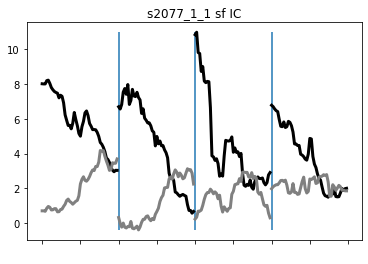

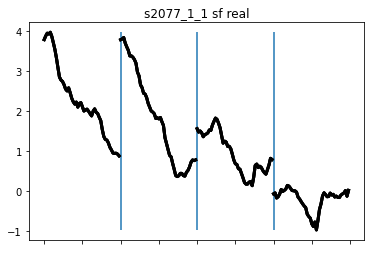

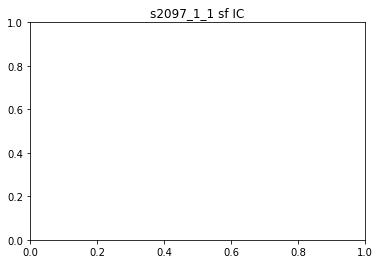

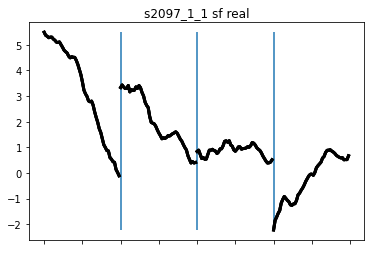

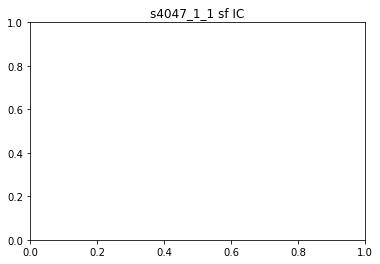

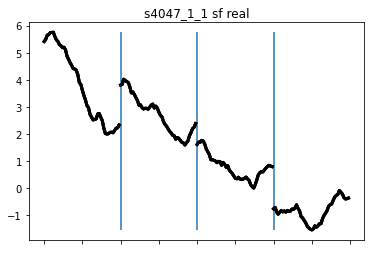

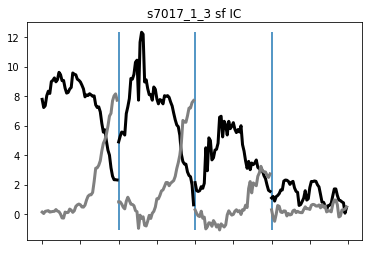

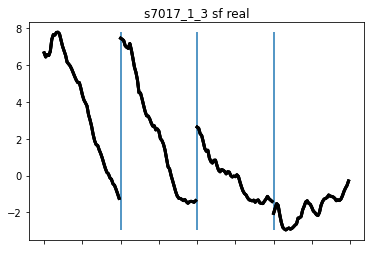

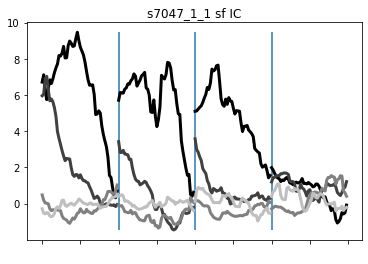

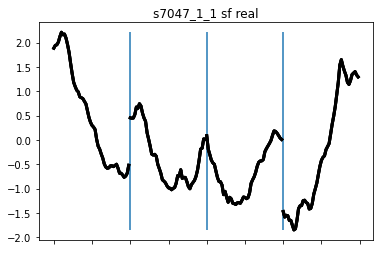

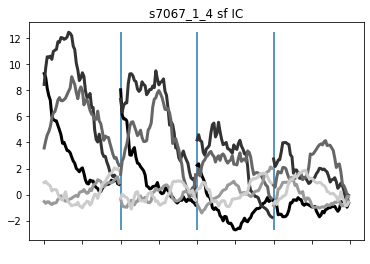

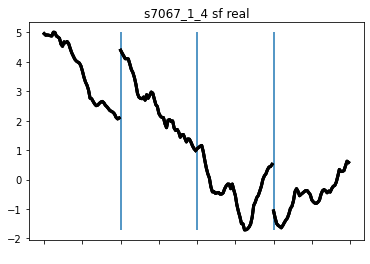

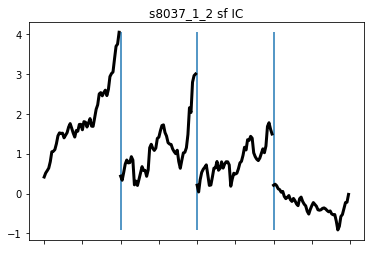

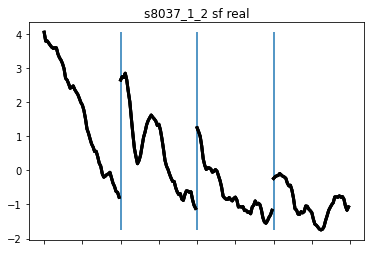

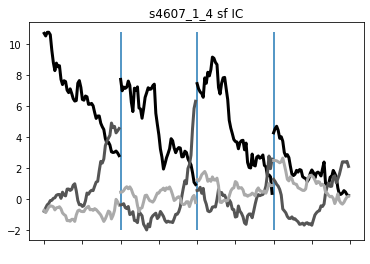

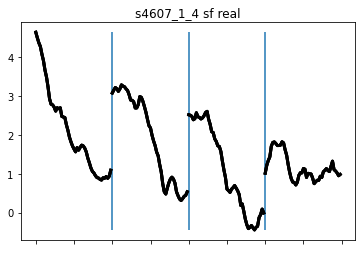

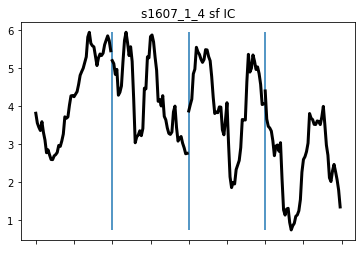

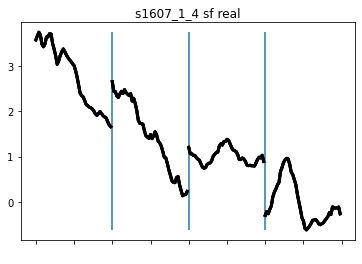

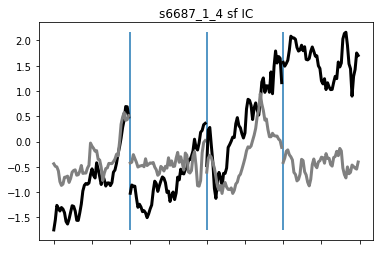

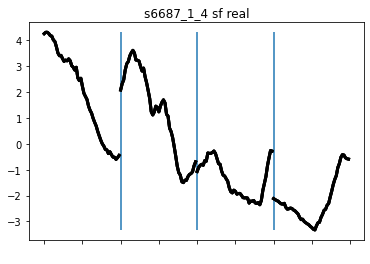

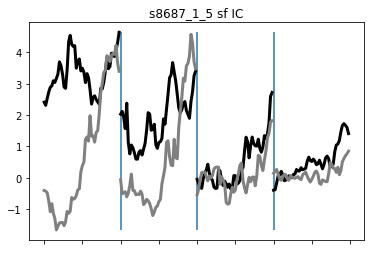

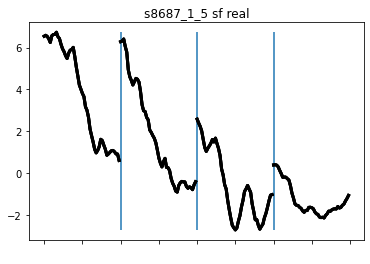

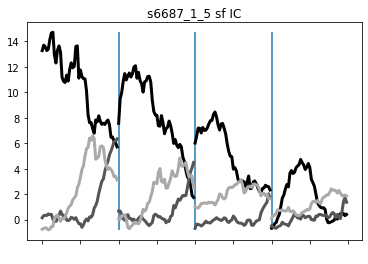

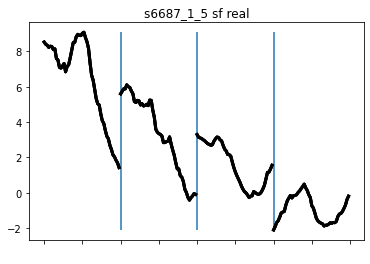

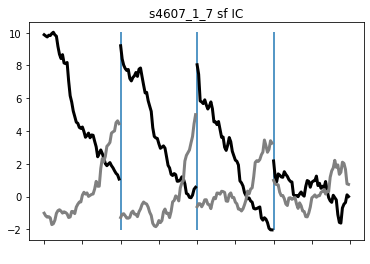

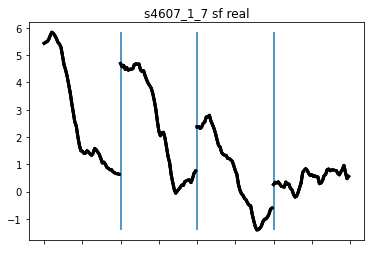

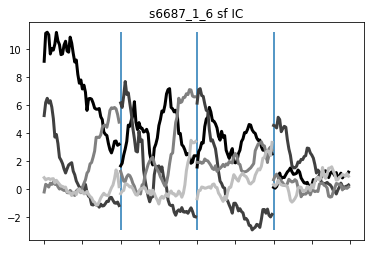

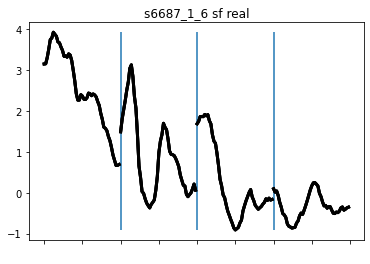

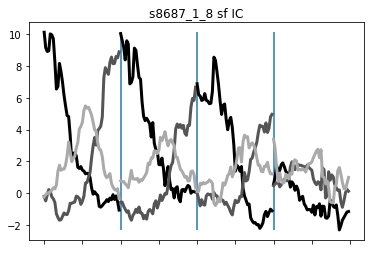

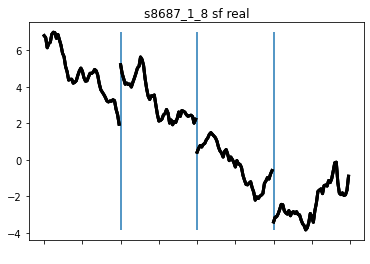

In [35]:
# Plot SF IC
GLM_condition = 'sf'
file_identifier = 'IC'

for ppt in ppts_ordered:
    output_name = '%s/plots/%s_%s_%s.svg' % (predict_dir, ppt, GLM_condition, file_identifier)
    plot_line_oscillations(ppt, GLM_condition, file_identifier, output_name)
    plot_line_oscillations(ppt, GLM_condition, 'real', output_name[:-4] + '_real.svg')

Creating /gpfs/milgram/project/turk-browne/projects/dev_neuropipe/data/predict_retinotopy//func_summaries_line/s2077_1_1_meridian_IC_occipital.pkl
No IC data found for s2077_1_1, skipping


/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice


Creating /gpfs/milgram/project/turk-browne/projects/dev_neuropipe/data/predict_retinotopy//func_summaries_line/s2097_1_1_meridian_IC_occipital.pkl
No IC data found for s2097_1_1, skipping
Creating /gpfs/milgram/project/turk-browne/projects/dev_neuropipe/data/predict_retinotopy//func_summaries_line/s7017_1_3_meridian_IC_occipital.pkl
No IC data found for s7017_1_3, skipping
Creating /gpfs/milgram/project/turk-browne/projects/dev_neuropipe/data/predict_retinotopy//func_summaries_line/s4607_1_4_meridian_IC_occipital.pkl
No IC data found for s4607_1_4, skipping
Creating /gpfs/milgram/project/turk-browne/projects/dev_neuropipe/data/predict_retinotopy//func_summaries_line/s1607_1_4_meridian_IC_occipital.pkl
No IC data found for s1607_1_4, skipping


/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:358: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Creating /gpfs/milgram/project/turk-browne/projects/dev_neuropipe/data/predict_retinotopy//func_summaries_line/s6687_1_6_meridian_IC_occipital.pkl
No IC data found for s6687_1_6, skipping


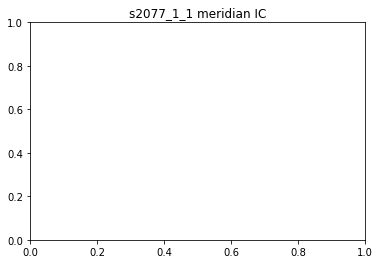

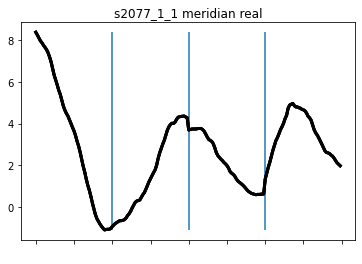

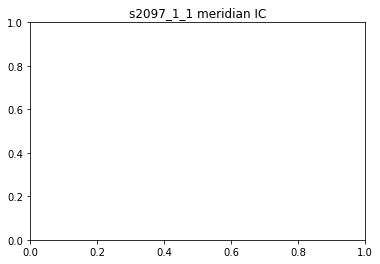

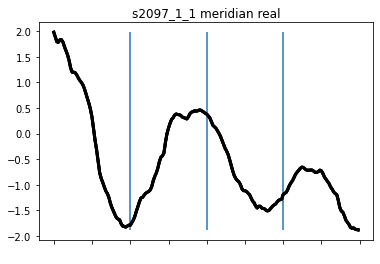

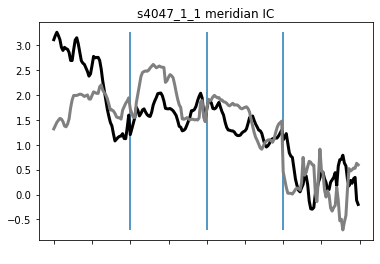

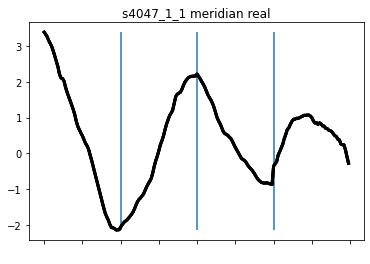

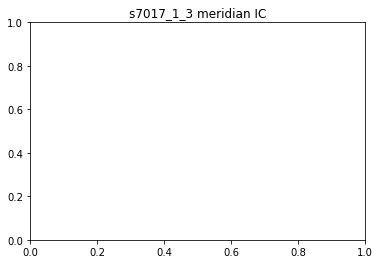

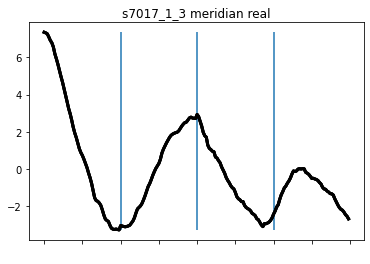

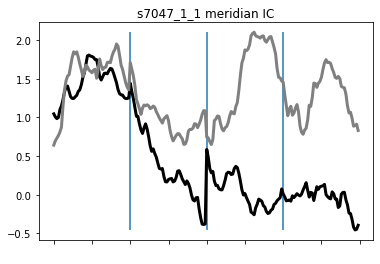

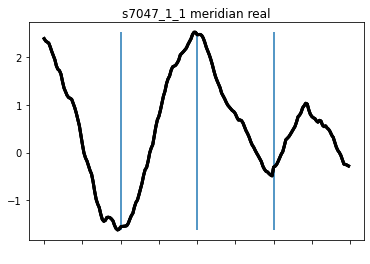

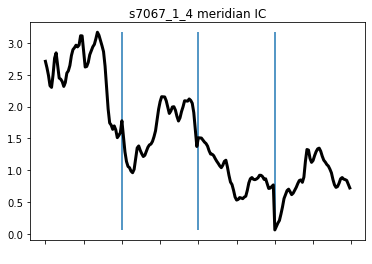

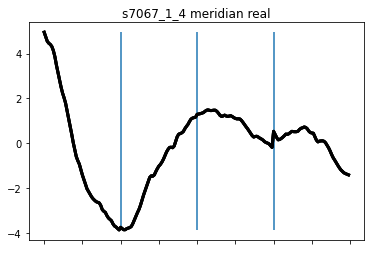

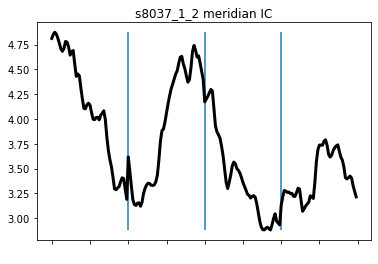

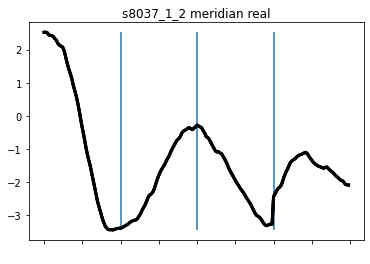

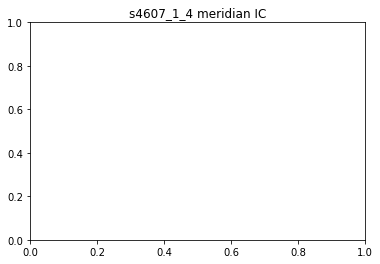

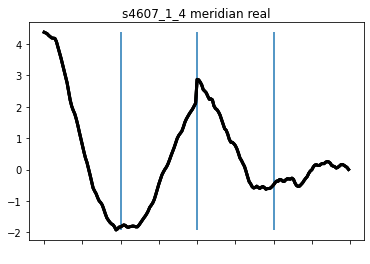

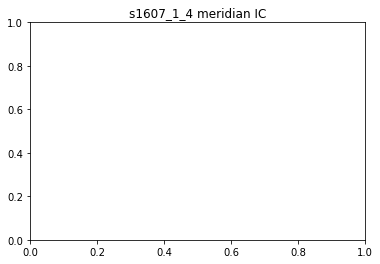

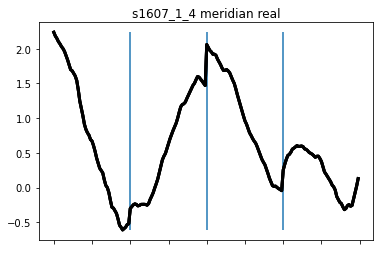

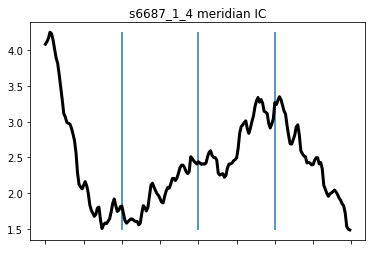

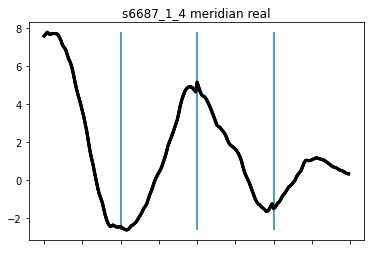

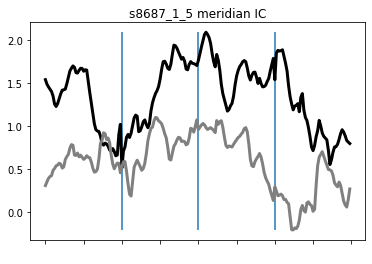

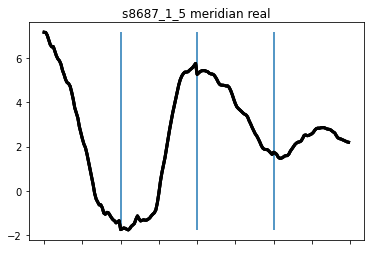

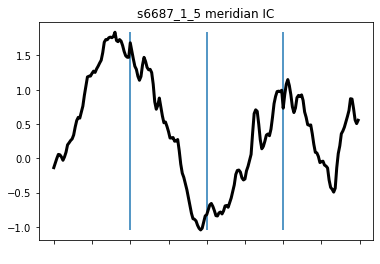

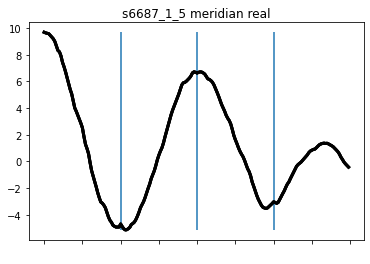

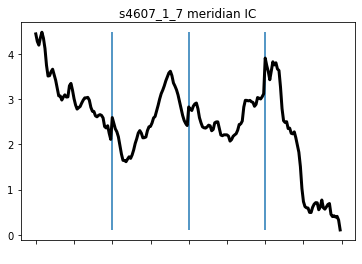

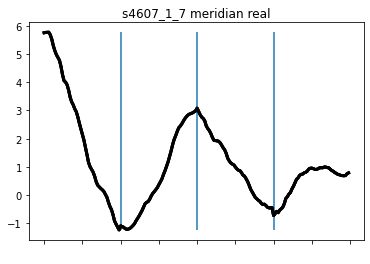

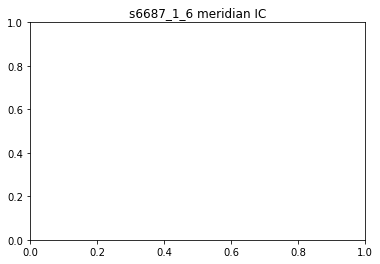

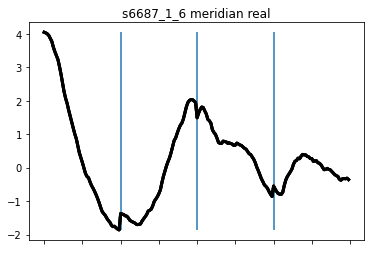

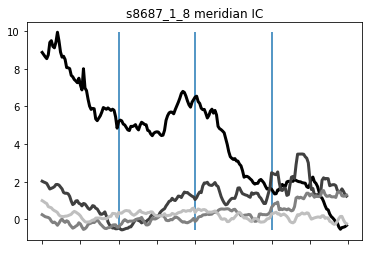

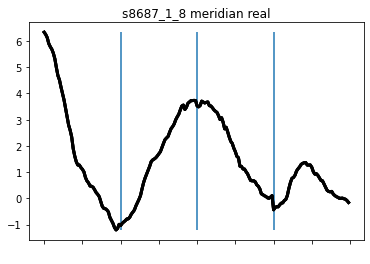

In [36]:
# Plot meridian ICs
GLM_condition = 'meridian'
file_identifier = 'IC'

for ppt in ppts_ordered:
    output_name = '%s/plots/%s_%s_%s.svg' % (predict_dir, ppt, GLM_condition, file_identifier)
    plot_line_oscillations(ppt, GLM_condition, file_identifier, output_name)
    plot_line_oscillations(ppt, GLM_condition, 'real', output_name[:-4] + '_real.svg')

Plot a specific component. Used in the manuscript

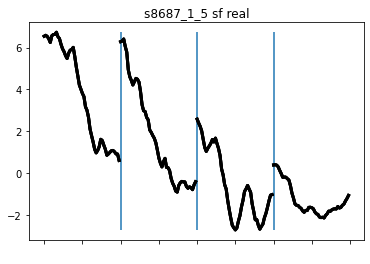

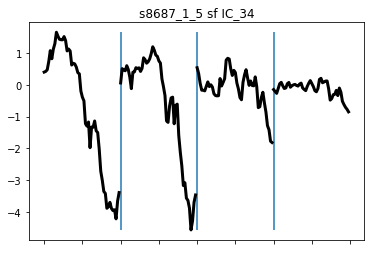

In [37]:
# Use this to plot a specific individual participant's data and specify specific ICs
GLM_condition = 'sf'
mask_type = 'occipital'
ppt = 's8687_1_5'

plot_line_oscillations(ppt, GLM_condition, 'real')
plt.savefig('%s/plots/example_%s_real.svg' % (predict_dir, GLM_condition))
plot_line_oscillations(ppt, GLM_condition, 'IC_34', flip_sign=True)
plt.savefig('%s/plots/example_%s_IC.svg' % (predict_dir, GLM_condition))


### Compute the similarity of the components to the gradients
First load in all of the gradients for each component and the real data, then correlates them. Highlight the correlations for just the components thatwere manually selected. The results are stored in a dictionary that will be called on at the end of the notebook. The figures replot the data from above, reporting the real data in black, the best fit in red and the other chosen items in grey


s2077_1_1
All
All
IC 11, r=0.66: 0.90 (55 / 61)
IC 40, r=-0.60: 0.83 (51 / 61)

s2097_1_1

s4047_1_1
All
IC 10, r=0.27: 0.78 (29 / 37)
IC 23, r=-0.15: 0.39 (15 / 37)
All


/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice



s7017_1_3
All
All
IC 4, r=0.76: 0.97 (72 / 74)
IC 23, r=-0.26: 0.44 (33 / 74)

s7047_1_1
All
IC 22, r=-0.29: 0.62 (46 / 74)
IC 62, r=-0.44: 0.93 (69 / 74)
All
IC 4, r=0.12: 0.34 (26 / 74)
IC 46, r=0.62: 0.99 (73 / 74)
IC 45, r=0.41: 0.85 (63 / 74)
IC 52, r=-0.50: 0.90 (67 / 74)

s7067_1_4
All
IC 131, r=-0.03: 0.03 (6 / 167)
All
IC 2, r=0.87: 1.00 (167 / 167)
IC 4, r=0.79: 0.98 (164 / 167)
IC 52, r=0.69: 0.95 (158 / 167)
IC 81, r=-0.17: 0.35 (59 / 167)
IC 89, r=-0.23: 0.46 (77 / 167)

s8037_1_2
All
IC 1, r=0.81: 1.00 (31 / 31)
All
IC 24, r=0.23: 0.27 (9 / 31)

s4607_1_4
All
All
IC 1, r=0.82: 1.00 (86 / 86)
IC 17, r=-0.28: 0.62 (54 / 86)
IC 45, r=-0.16: 0.33 (29 / 86)

s1607_1_4
All
All
IC 14, r=0.28: 0.55 (34 / 61)

s6687_1_4
All
IC 9, r=0.49: 0.68 (22 / 32)
All
IC 3, r=-0.85: 1.00 (32 / 32)
IC 18, r=-0.25: 0.35 (12 / 32)

s8687_1_5
All
IC 18, r=0.55: 0.86 (31 / 36)
IC 33, r=0.19: 0.37 (14 / 36)
All
IC 21, r=0.50: 0.54 (20 / 36)
IC 34, r=-0.30: 0.23 (9 / 36)

s6687_1_5
All
IC 16, r=-0.

/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


All
IC 3, r=0.95: 1.00 (78 / 78)
IC 17, r=-0.57: 0.96 (75 / 78)

s6687_1_6
All
All
IC 16, r=0.85: 1.00 (132 / 132)
IC 39, r=0.42: 0.83 (110 / 132)
IC 62, r=-0.13: 0.40 (53 / 132)
IC 116, r=-0.30: 0.72 (95 / 132)

s8687_1_8
All
IC 1, r=0.61: 0.94 (108 / 115)
IC 20, r=0.34: 0.68 (79 / 115)
IC 44, r=-0.15: 0.34 (40 / 115)
IC 84, r=0.56: 0.89 (103 / 115)
All
IC 9, r=0.60: 0.96 (111 / 115)
IC 39, r=-0.12: 0.29 (34 / 115)
IC 91, r=0.07: 0.17 (20 / 115)


/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice


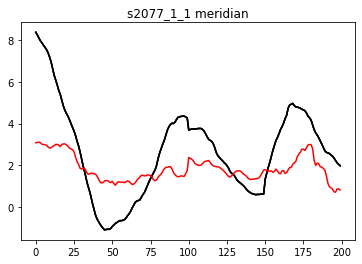

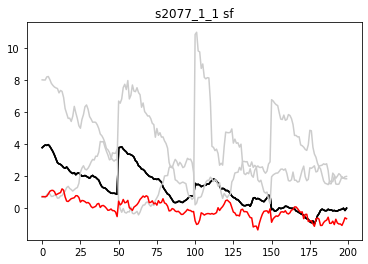

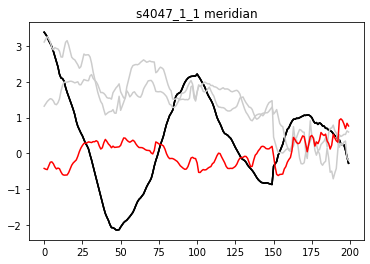

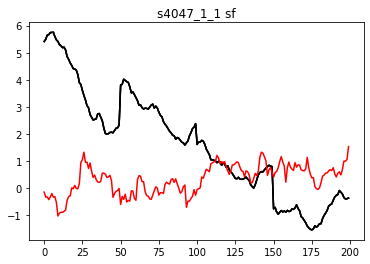

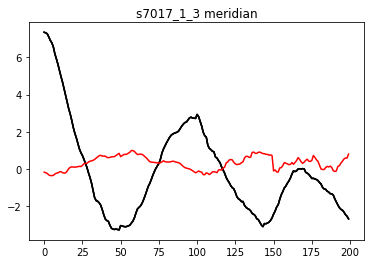

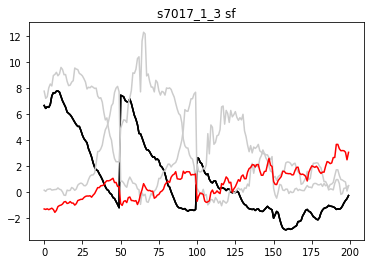

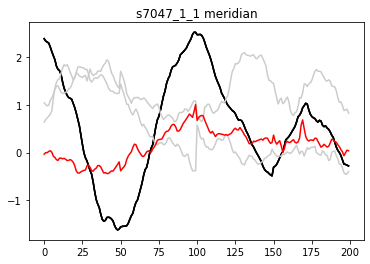

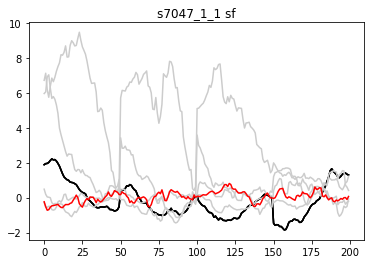

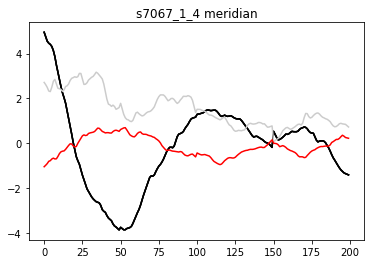

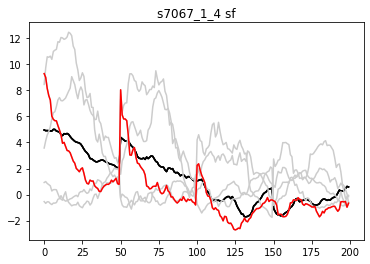

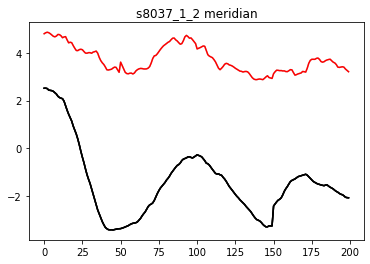

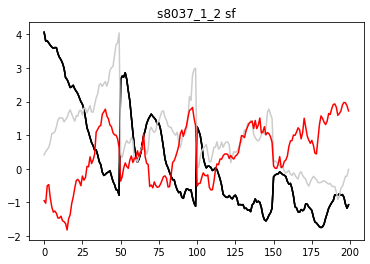

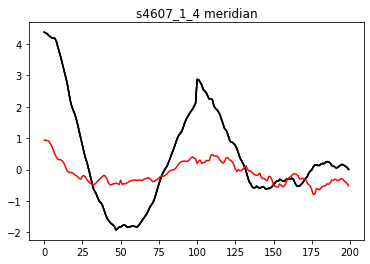

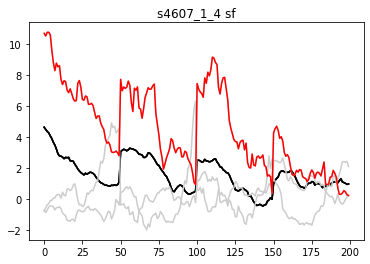

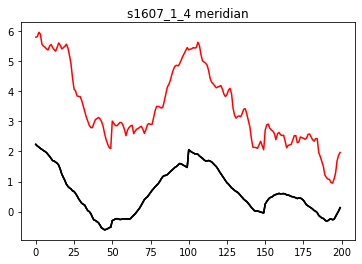

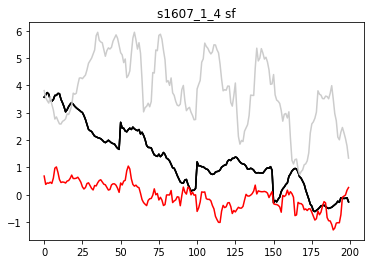

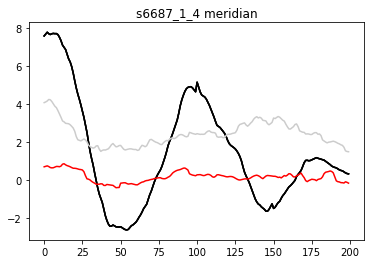

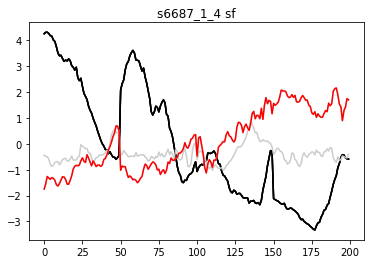

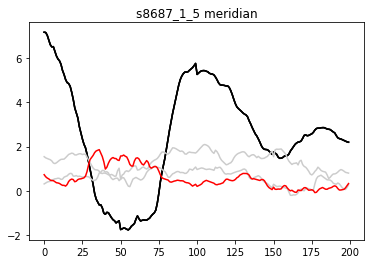

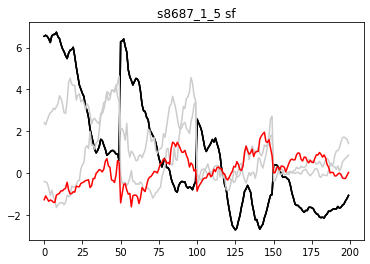

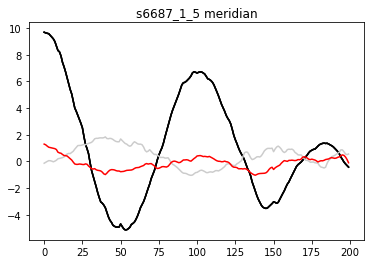

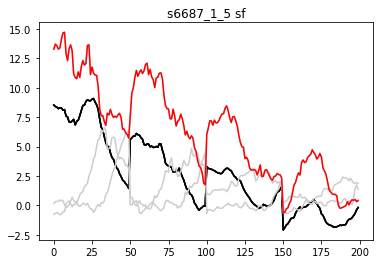

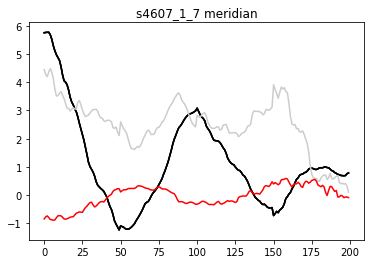

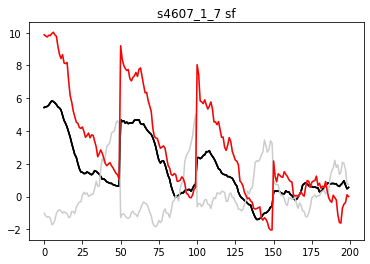

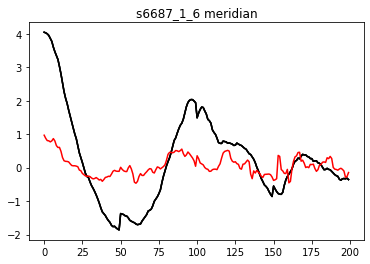

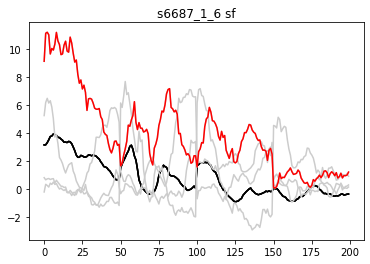

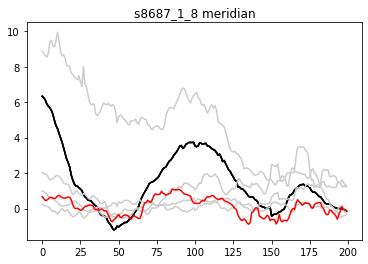

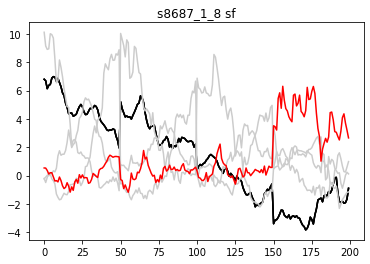

In [38]:
# Compute correlation of chosen ICs with all possible ICs
IC_rank_props_dict = {'ID': ppts_ordered, 'Age': ages_ordered, 'meridian': [np.nan] * len(ppts_ordered), 'sf': [np.nan] * len(ppts_ordered)}
IC_corr_vals_dict  = {'ID': ppts_ordered, 'Age': ages_ordered, 'meridian': [np.nan] * len(ppts_ordered), 'sf': [np.nan] * len(ppts_ordered)}
IC_corr_all_dict  = {'ID': ppts_ordered, 'Age': ages_ordered, 'meridian': [np.nan] * len(ppts_ordered), 'sf': [np.nan] * len(ppts_ordered)}

for ppt_counter, ppt in enumerate(IC_rank_props_dict['ID']):
    
    print('\n' + ppt)
    
    # Get the ICs for the condition         
    for condition_counter, GLM_condition in enumerate(['meridian', 'sf']):        
        
        # Get all the file names
        all_file = '%s/func_summaries_line/%s_%s_IC_all_%s.pkl' % (predict_dir, ppt, GLM_condition, mask_type)
        real_file = '%s/func_summaries_line/%s_%s_real_%s.pkl' % (predict_dir, ppt, GLM_condition, mask_type)
        
        # Load the list of labelled ICs if there are any (using 0 indexing)
        labeled_ICs_file = glob.glob('%s/IC_codes/%s*.txt' % (predict_dir, ppt))

        # Get the ICs from this file
        if len(labeled_ICs_file) == 1:
            labeled_ICs = np.loadtxt(labeled_ICs_file[0])

            # If it is only one IC then fix it
            if len(labeled_ICs.shape) == 1:
                labeled_ICs = labeled_ICs.reshape((1, 2))

        elif len(labeled_ICs_file) == 0:
            
            #Skip this
            labeled_ICs = np.zeros((0, 0))
            continue
        else:
            print('Multiple IC_codes files detected for %s, investigate' % ppt)
        
        # Get the condition ICs
        condition_ICs = labeled_ICs[labeled_ICs[:, 1] == (condition_counter + 1), 0] 
        
        if os.path.exists(all_file) == 0:
            print('%s does not exist, skipping' % all_file)
            continue
            
        # Load all the IC values
        fid = open(all_file, 'rb')
        pkl_dict = pickle.load(fid)
        fid.close()
        all_IC_lines_ = pkl_dict['data_vals_all'] 
        all_IC_files = pkl_dict['files'] 

        # Get the real lines (or maybe the ideal lines)
        if use_ideal_lines is False:
            fid = open(real_file, 'rb')
            pkl_dict = pickle.load(fid)
            fid.close()
            real_lines_ = pkl_dict['data_vals_all']
        else:
            if GLM_condition == 'sf':
                real_lines_ = sf_ideal
            else:
                real_lines_ = meridian_ideal

        for area_counter, area in enumerate(['All']): #['V1', 'V2', 'V3', 'V4', 'V3A/B', 'All']):

            # Report the area
            print(area)

            # Pull the backup
            all_IC_lines = np.copy(all_IC_lines_)
            real_lines = np.copy(real_lines_)

            # Compute the averages (do it differently if it is just V4 or V3A/B being considered)
            if area is 'V4':
                all_IC_lines = np.nanmean(all_IC_lines[:, :, :, 0], 2)
                real_lines = np.nanmean(real_lines[:, :, :, 0], 2)
                area_counter = 3 # Override
            elif area is 'V3A/B':
                all_IC_lines = np.nanmean(all_IC_lines[:, :, :, 1], 2)
                real_lines = np.nanmean(real_lines[:, :, :, 1], 2)
                area_counter = 3 # Override
            else:
                all_IC_lines = np.nanmean(np.nanmean(all_IC_lines, 3), 2)
                real_lines = np.nanmean(np.nanmean(real_lines, 3), 2)

            # trim the lines if necessary
            if area is not 'All':
                all_IC_lines = all_IC_lines[:, int(area_counter * (max_len / 4)):int((area_counter + 1) * (max_len / 4))]
                real_lines = real_lines[:, int(area_counter * (max_len / 4)):int((area_counter + 1) * (max_len / 4))]

            # Cross correlate the data
            corr_vals = []
            for IC_counter in range(all_IC_lines.shape[0]):
                corr_vals += [np.corrcoef(all_IC_lines[IC_counter, :], real_lines)[0, 1]]

            sorted_corr_vals = np.argsort(np.abs(corr_vals))
            
            # Stire the values in a dictionary
            IC_corr_all_dict[GLM_condition][ppt_counter] = corr_vals
            
            # Where in the list are the chosen ICs (extreme values are good, high values mean positive)
            rank_props = []
            chosen_corr_vals = []
            for condition_IC in condition_ICs:
                rank = np.where(sorted_corr_vals == condition_IC)[0][0]
                rank_prop = rank / (len(sorted_corr_vals) - 1)
                rank_props += [rank_prop]
                chosen_corr_vals += [corr_vals[int(condition_IC)]]

                print('IC %d, r=%0.2f: %0.2f (%d / %d)' % (condition_IC, corr_vals[int(condition_IC)], rank_prop, rank + 1, len(sorted_corr_vals)))

            # Plot the real, choosen and best ICs
            if area is 'All':
                plt.figure()
                plt.title('%s %s' % (ppt, GLM_condition))
                plt.plot(real_lines.T, 'k')
                for condition_IC in condition_ICs:
                    plt.plot(all_IC_lines[int(condition_IC), :], color=[0.8, 0.8, 0.8]) 
                plt.plot(all_IC_lines[sorted_corr_vals[-1], :], 'r')

                # Store the participant data
                if len(rank_props) > 0:
                    IC_rank_props_dict[GLM_condition][ppt_counter] = rank_props
                    IC_corr_vals_dict[GLM_condition][ppt_counter] = chosen_corr_vals
    

## Plot the IC similarity
Show the similarity of the chosen IC components to the ground truth maps, both for the raw correlations and the percentile of the component relative to all IC components. The cell also reports the descriptive statistics of the analysis, and correlates the effects with age and movie data.

meridian IC_corr: mean corr. M=0.46 (range:0.03--0.81)
sf IC_corr: mean corr. M=0.52 (range:0.23--0.85)
Correlation between age and similarity: -0.06, p=0.810
Correlation between movie length and similarity: 0.31, p=0.133

meridian IC_rank_props: mean prop. M=67.6 (range:3.0--100.0)
sf IC_rank_props: mean prop. M=63.8 (range:26.7--98.1)
Correlation between age and similarity: -0.29, p=0.283
Correlation between movie length and similarity: 0.37, p=0.165



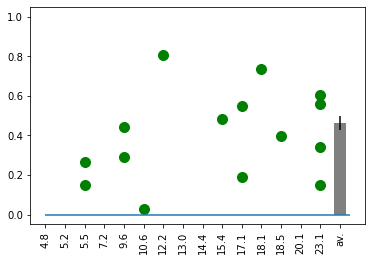

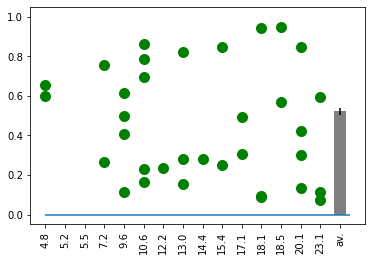

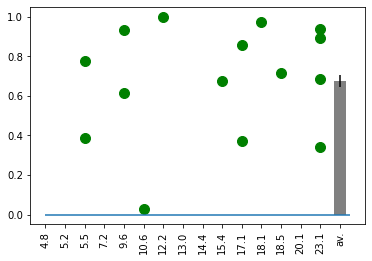

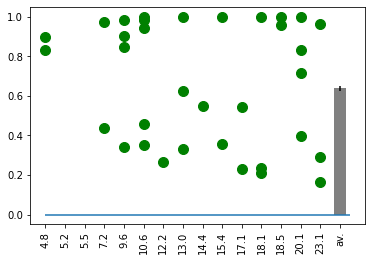

In [39]:
# Make the figure    
np.random.seed(0)
dict_names = ['IC_corr', 'IC_rank_props']
for dict_counter, temp_dict in enumerate([IC_corr_vals_dict, IC_rank_props_dict]):

    for GLM_condition in ['meridian', 'sf']:
        plt.figure()
        plot_counter = 0
        temp_age = []
        summary_val = []
        included_ppts =[]
        for ppt_counter, ppt in enumerate(temp_dict['ID']):

            # Add this participant to the list if appropriate
            if np.any(np.isnan(temp_dict[GLM_condition][ppt_counter])) == 0:
                plt.scatter([plot_counter] * len(temp_dict[GLM_condition][ppt_counter]), np.abs(temp_dict[GLM_condition][ppt_counter]), color= 'g', s=100)
                
                # Take the arctanh of the correlation values but just keep the percentiles (but multiply by 100)
                if dict_counter == 0:
                    vals = np.abs(np.arctanh(temp_dict[GLM_condition][ppt_counter]))
                else:
                    vals = temp_dict[GLM_condition][ppt_counter]
                    
                summary_val += [stat_func(vals)]
                included_ppts += [ppt_counter]
    
            temp_age += [temp_dict['Age'][ppt_counter]]
            plot_counter += 1
        
        # Do you want to plot a bar as the average at the end?
        if add_bar_plot == 1:
            mean_val = np.mean(summary_val)
            se_val = np.std(summary_val) / len(summary_val)

            # If this is Fisher values, convert back to correlation
            if dict_counter == 0:
                mean_val = np.tanh(mean_val)
                se_val = np.tanh(se_val)

            plt.bar([plot_counter], mean_val, yerr=se_val, width=0.6, color='gray')

            plt.hlines(0, 0, plot_counter + 0.5)    
            plt.xticks(np.arange(plot_counter + 1), temp_age + ['av.'], rotation=90);    

        else:
            # If not then skip
            plt.hlines(0, 0, plot_counter - 1)    
            plt.xticks(np.arange(plot_counter), temp_age, rotation=90);    

        
        # Set the lim
        plt.ylim([-0.05, 1.05])

        plt.savefig('%s/plots/%s_vals_%s_%s.svg' % (predict_dir, dict_names[dict_counter], GLM_condition, real_lines_name[use_ideal_lines]))
        
        # Print summary information
        if dict_counter == 0:
            print('%s %s: %s corr. M=%0.2f (range:%0.2f--%0.2f)' % (GLM_condition, dict_names[dict_counter], stat_type, np.tanh(np.mean(summary_val)), np.tanh(np.min(summary_val)), np.tanh(np.max(summary_val))))
            
        else:
            summary_val = np.asarray(summary_val) * 100
            print('%s %s: %s prop. M=%0.1f (range:%0.1f--%0.1f)' % (GLM_condition, dict_names[dict_counter], stat_type, np.mean(summary_val), np.min(summary_val), np.max(summary_val)))
            
    # Compute correlations of various things
    x = np.asarray(temp_age)[np.asarray(included_ppts)]
    y = summary_val
    print('Correlation between age and similarity: %0.2f, p=%0.3f' % (np.corrcoef(x, y)[0, 1], randomise_corr(x, y))) 

    x = np.asarray(movie_length_ordered)[np.asarray(included_ppts)]
    y = summary_val
    print('Correlation between movie length and similarity: %0.2f, p=%0.3f\n' % (np.corrcoef(x, y)[0, 1], randomise_corr(x, y))) 

## Plot the similarity with violin plots
Show the similarity of the chosen IC components to the ground truth maps, on top of a violin plot of the distribution of all components. The cell als reports the descriptive statistics of the analysis, and correlates the effects with age and movie data. The dots at zero are filler points for participants with no chosen ICs, which is needed to make seaborn work.

meridian: mean corr. M=0.46 (range:0.03--0.81)
Correlation between age and similarity: 0.29, p=0.285


/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Correlation between movie length and similarity: -0.20, p=0.646

sf: mean corr. M=0.52 (range:0.23--0.85)
Correlation between age and similarity: -0.06, p=0.787
Correlation between movie length and similarity: 0.31, p=0.135



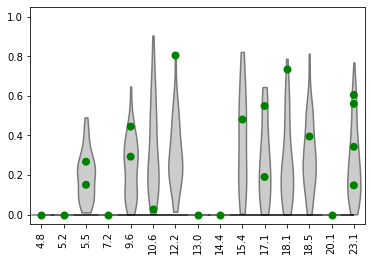

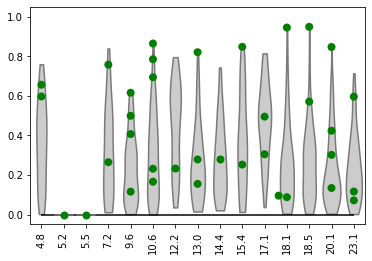

In [40]:
# Make the figure    
np.random.seed(0)

for GLM_condition in ['meridian', 'sf']:
    plt.figure()
    plot_counter = 0
    temp_age = []
    summary_val = []
    violin_x = []
    violin_y = []
    swarm_x = []
    swarm_y = []
    included_ppts =[]
    for ppt_counter, ppt in enumerate(IC_corr_all_dict['ID']):

        # Add this participant to the list if appropriate
        if np.any(np.isnan(IC_corr_vals_dict[GLM_condition][ppt_counter])) == 0:
            
            # Pull out the correlation values 
            all_vals = np.abs(IC_corr_all_dict[GLM_condition][ppt_counter])
            chosen_vals = np.abs(IC_corr_vals_dict[GLM_condition][ppt_counter])
            
            # Store all the data you need for the plot
            violin_x += [plot_counter] * len(all_vals)
            violin_y += list(all_vals)
            swarm_x += [plot_counter] * len(chosen_vals)
            swarm_y += list(chosen_vals)
            
            # Convert summary value into Fisher
            summary_val += [stat_func(np.arctanh(chosen_vals))]
            included_ppts += [ppt_counter]
        else:
            
            #Set place holders
            violin_x += [plot_counter]
            violin_y += [0]
            swarm_x += [plot_counter]
            swarm_y += [0]
            
        temp_age += [IC_corr_all_dict['Age'][ppt_counter]]
        plot_counter += 1
    
    # Make the plot now that you have all the data
    sns.violinplot(x=violin_x, y=violin_y, color=[0.8,0.8,0.8], inner=None, orient="v", width=0.8, cut=0)
    sns.swarmplot(x=swarm_x, y=swarm_y, color="g", size=8, orient="v")

    plt.hlines(0, 0, plot_counter - 1, 'k')    
    plt.xticks(np.arange(plot_counter), temp_age, rotation=90);    

    # Set the lim
    plt.ylim([-0.05, 1.05])

    plt.savefig('%s/plots/IC_violin_vals_%s_%s.svg' % (predict_dir, GLM_condition, real_lines_name[use_ideal_lines]))

    # Print summary information
    print('%s: %s corr. M=%0.2f (range:%0.2f--%0.2f)' % (GLM_condition, stat_type, np.tanh(np.mean(summary_val)), np.tanh(np.min(summary_val)), np.tanh(np.max(summary_val))))

    # Compute correlations of various things
    x = np.asarray(temp_age)[np.asarray(included_ppts)]
    y = summary_val
    print('Correlation between age and similarity: %0.2f, p=%0.3f' % (np.corrcoef(x, y)[0, 1], randomise_corr(x, y))) 

    x = np.asarray(movie_length_ordered)[np.asarray(included_ppts)]
    y = summary_val
    print('Correlation between movie length and similarity: %0.2f, p=%0.3f\n' % (np.corrcoef(x, y)[0, 1], randomise_corr(x, y))) 

# Evaluate SRM against real retinotopy maps <a id='srm'></a>

First identify what is the appropriate number of features to use for the SRM by doing time segment matching. Then run the pipeline to create a prediction of retinotopic maps from other participants. Like ICA, find the gradients along these maps and compare it to the real retinotopic maps to discern the fit. 

### Run SRM on the infant and adults to find the optimal number of features 
This procedure uses time segment matching to find the optimal number of features for the SRM. Time segment matching takes a pattern of activity for a time point and then uses the data from all other participants to predict what time point that comes from in the movie. Accuracy is then the number of time points that are matched.

The code below creates a series of jobs to be submitted that perform this time segment matching. You can either submit them using something like dsq (as this is set up to do) or you can run them separately by changing the line to sbatch.

The output of this script is a line printed to `data/predict_retinotopy/time_segment_matching/` in which it reports the details about the analysis, the time segment matching accuracy and the chance level 

In [41]:
# Get the participant information
out_file = '%s/logs/joblist-tsm.txt' % proj_dir
fid = open(out_file, 'w')
ref_groups = ['adult', 'infant']
for is_infant_ref in [0]: # Set to 1 if the infant is the reference
    
    # What group is being used as reference to build the SRM?
    ref_group = ref_groups[is_infant_ref]
    
    for is_infant_loo in [0]: # What group is being left out of the analysis to fit
        
        # What participants are you using as the target of the analysis to fit the SRM to?
        if is_infant_loo == 0:
            temp_df = adult_df
        else:
            temp_df = infant_df
        
        for ID in temp_df['ID']:
            for i in features_list:
                
                # Make the expected output line
                out_file = '%s/data/predict_retinotopy/time_segment_matching/time_segment_matching_results_%s_f-%d.txt' % (proj_dir, mask_type, i)
                if os.path.exists(out_file):
                    results = open(out_file, 'r').readlines()

                    # Check whether this exists or not
                    first_line = 0
                    if ID in retinotopy_ppt_movies:
                        for movie in retinotopy_ppt_movies[ID]:

                            # Preset
                            already_made = -1

                            # Find the short format name of the movie
                            short_name = ''
                            for SRM_movie_name in SRM_movie_names:
                                if movie.find('Full_' + SRM_movie_name) > -1:
                                    short_name = SRM_movie_name

                                    # If it should exist then set here
                                    already_made = 0

                            # Check if this file is in there 
                            out_line = '%s %s %s:' % (ID, ref_group, short_name)

                            for line in results:
                                if line.find(out_line) == 0:
                                    already_made = 1

                            # If the file still doesn't exist then make it here
                            if (already_made == 0) and (first_line == 0):

                                # Write to the job script
                                fid.write('scripts/predict_retinotopy/run_time_segment_matching_features.sh %s %d %d %s\n' % (ID, i, is_infant_ref, mask_type))
                                first_line = 1

                else:
                    
                    # If the file doesn't exist yet, just save the file
                    fid.write('scripts/predict_retinotopy/run_time_segment_matching_features.sh %s %d %d %s\n' % (ID, i, is_infant_ref, mask_type))

fid.close()        
    

Plot the time segment matching accuracy for different numbers of features with the adult and infant participants, looking only at specific movies. Different line colors are different movies. The thick black line is the average across participants and movies. The black vertical line is the chosen features. The grey horizontal line is the average chance level


LOO group: adults
Ref group: adult
Max feature: 23 (M=0.82). This might not be the best since more features lead to overfitting
Chosen feature: 10 (M=0.80)

Legend:
Child_Play r
Catepillar g
Meerkats b
Mouseforsale m
Aeronaut y


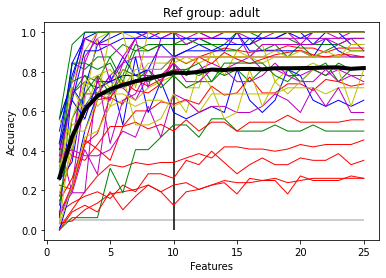

In [42]:
metric = 'time_segment_matching'
movie = '' # Specify the movie you want to see

# What is the file template
file_name_fmt = proj_dir + '/data/predict_retinotopy/time_segment_matching/' + metric + '_results_' + mask_type + '_f-%d.txt'

print('\nLOO group: adults')
plot_CV_results(list(adult_df['ID']), file_name_fmt, features_list, movie, 'adult')
if movie != '':
    plt.savefig('%s/data/predict_retinotopy/plots/%s_ref_adults_loo_adults_%s.svg' % (proj_dir, movie, metric))
else:
    plt.savefig('%s/data/predict_retinotopy/plots/all_ref_adults_loo_adults_%s.svg' % (proj_dir, metric))

# Plot the chosen feature line
plt.vlines(chosen_features, 0, 1, 'k')    

### Predict retinotopy using SRM

Specify a number of features and a held out participant, and then the movies that are available for the participant will be found and different SRMs will be created for each kind. We use all of the participants that have seen that movie to train the SRM, the held out participant is then transformed into that space (without altering the space). The retinotopic maps from the reference participants who saw this movie are then transformed into SRM space and in to this participant space.

Like above, this uses dsq to submit the jobs. Change as needed.

This will also do a control analysis. The idea for the control analysis is that the fitting of the left out participant's data to SRM is jumbled so that the fit to the shared space is noise. The retinotopy data uses that fit so it should be bad too.

In [43]:
# Make the joblist file that can be run with dsq
out_file = '%s/logs/joblist-srm.txt' % proj_dir
fid = open(out_file, 'w+')
optimal_features = [chosen_features, chosen_features] # Get the features for predicting retinotopy in infants. First element is when using adults for ref, second element is when using infants
control_name = ['', '_control']
infant_ref_name = ['adult_avg', 'infant_avg']
for ID in infant_df['ID']: 
    
    # Get the number of SRM movies this participant saw
    if ID in SRM_retinotopy_infant:
        SRM_movies = len(SRM_retinotopy_infant[ID])
    else:
        SRM_movies = 0
        
    if SRM_movies > 0:
        for mask in ['occipital']: 
            for is_control in [0, 1]:
                for is_infant_ref, features in enumerate(optimal_features):

                        # Get all the possible output files
                        file_fmt = '%s/SRM_prediction/%s/*_f-%d_%s_*_%s%s.nii.gz' % (predict_dir, ID, features, infant_ref_name[is_infant_ref], mask, control_name[is_control])
                        output_files = glob.glob(file_fmt)

                        # Report all of the files
                        if len(output_files) == 0:
                            fid.write('scripts/predict_retinotopy/run_SRM_predict_retinotopy.sh %s %d %d %s %d\n' % (ID, features, is_infant_ref, mask, is_control))
                        else:
                            if len(output_files) != (SRM_movies * 2):
                                print('Some missing files for %s' % (file_fmt[len(predict_dir) + 1:]))
    else:
        print('Skipping %s because no SRM data' % ID)
fid.close()        


Skipping s8687_1_8 because no SRM data
Skipping s4607_1_7 because no SRM data
Skipping s8047_1_1 because no SRM data
Skipping s2097_1_2 because no SRM data


### Transform the predictions into surface space
This populates the SRM_surfs directory. This takes a while but once the files are created this block will be nearly instantaneous

In [44]:
if skip_surf_generation == 0:
    print('### THIS WILL TAKE A WHILE TO RUN THE FIRST TIME BUT ONLY NEEDS TO RUN ONCE ###\n\n')
    # Run for SRM
    for control_name in ['', '_control']:
        for ppt in infant_df['ID']:

            SUMA_folder = '%s/iBEAT/%s/SUMA/' % (retinotopy_dir, ppt)

            output_dir = '%s/SRM_surfs/%s/' % (predict_dir, ppt)

            for GLM_condition in GLM_conditions:

                # Get all the file names (individual participants and average predictions)
                file_names = glob.glob('%s/SRM_prediction/%s/%s_f-%d_*%s%s.nii.gz' % (predict_dir, ppt, GLM_condition, optimal_features[1], mask_type, control_name))

                # Loop through these file names
                for func in file_names:

                    # Make the out put directory (do it here so that only participants with files have a folder)
                    if os.path.exists(output_dir) == 0:
                        os.mkdir(output_dir)

                    # What is the root name of the file to be outputted
                    out_file_root = func[func.find('/' + GLM_condition) + 1:func.find('.nii.gz')]

                    # Cycle through the hemispheres
                    for hemi in ['lh', 'rh']:

                        out_file = '%s/%s.%s.1d.dset' % (output_dir, hemi, out_file_root)
                        spec_file = '%s/iBEAT_%s.spec' % (SUMA_folder, hemi)
                        if os.path.exists(out_file) == 0:

                            # Run the output
                            os.system('3dVol2Surf -spec %s -sv %s -out_1D %s -surf_A smoothwm -grid_parent %s -map_func mask' % (spec_file, func, out_file, func))

                            # Only take the last column, the data you care about
                            os.system('1dcat -sel ''[6]'' %s > temp_%s.txt' % (out_file, out_file_root))

                            # Rename (doesn't work to store with this name if it already exists)
                            os.system('mv temp_%s.txt %s' % (out_file_root, out_file))

                            print('Created', out_file)
else:
    print('############################################\n### Skipping the generation of surfaces! ###\n############################################')

### THIS WILL TAKE A WHILE TO RUN THE FIRST TIME BUT ONLY NEEDS TO RUN ONCE ###




### Plot the gradients of the SRM results
Do this separately for meridian or sf, as well using infants or adults to make the SRM

/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice


Creating /gpfs/milgram/project/turk-browne/projects/dev_neuropipe/data/predict_retinotopy//func_summaries_line/s4607_1_7_meridian_f-10_infant_avg_occipital.pkl
No IC data found for s4607_1_7, skipping
Creating /gpfs/milgram/project/turk-browne/projects/dev_neuropipe/data/predict_retinotopy//func_summaries_line/s8687_1_8_meridian_f-10_infant_avg_occipital.pkl
No IC data found for s8687_1_8, skipping


/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:358: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see th

Creating /gpfs/milgram/project/turk-browne/projects/dev_neuropipe/data/predict_retinotopy//func_summaries_line/s4607_1_7_sf_f-10_infant_avg_occipital.pkl
No IC data found for s4607_1_7, skipping


/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice


Creating /gpfs/milgram/project/turk-browne/projects/dev_neuropipe/data/predict_retinotopy//func_summaries_line/s8687_1_8_sf_f-10_infant_avg_occipital.pkl
No IC data found for s8687_1_8, skipping


/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice


Creating /gpfs/milgram/project/turk-browne/projects/dev_neuropipe/data/predict_retinotopy//func_summaries_line/s4607_1_7_meridian_f-10_adult_avg_occipital.pkl
No IC data found for s4607_1_7, skipping
Creating /gpfs/milgram/project/turk-browne/projects/dev_neuropipe/data/predict_retinotopy//func_summaries_line/s8687_1_8_meridian_f-10_adult_avg_occipital.pkl
No IC data found for s8687_1_8, skipping


/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/

Creating /gpfs/milgram/project/turk-browne/projects/dev_neuropipe/data/predict_retinotopy//func_summaries_line/s4607_1_7_sf_f-10_adult_avg_occipital.pkl
No IC data found for s4607_1_7, skipping


/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice


Creating /gpfs/milgram/project/turk-browne/projects/dev_neuropipe/data/predict_retinotopy//func_summaries_line/s8687_1_8_sf_f-10_adult_avg_occipital.pkl
No IC data found for s8687_1_8, skipping


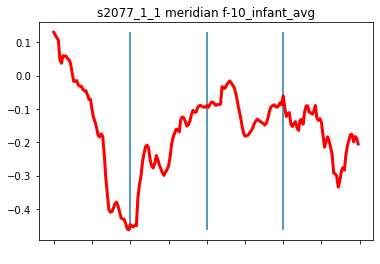

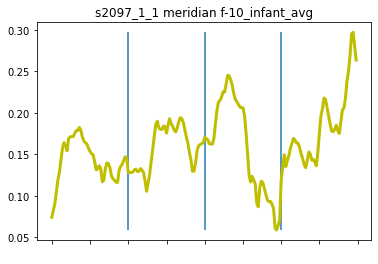

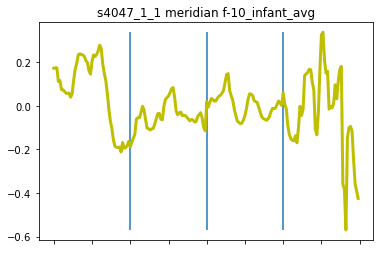

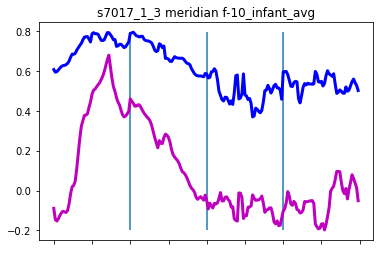

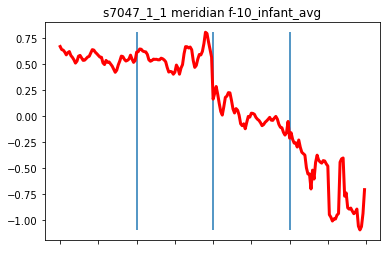

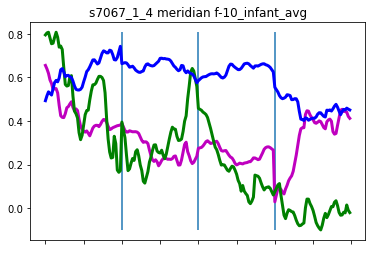

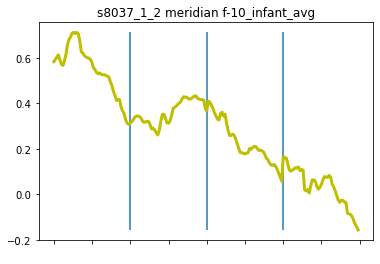

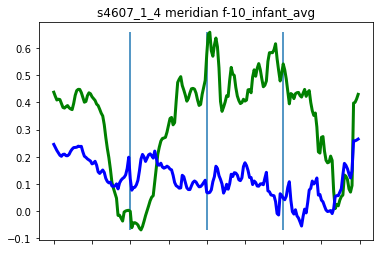

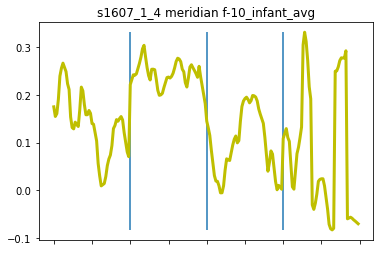

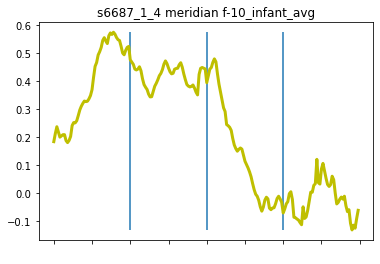

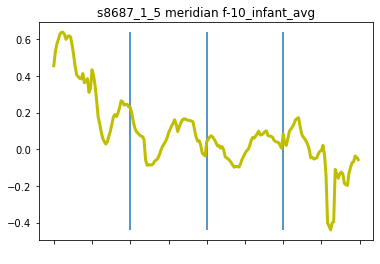

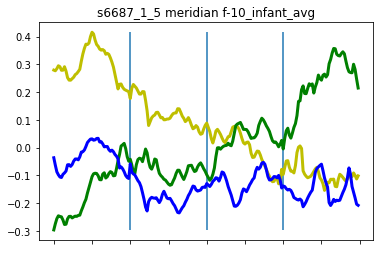

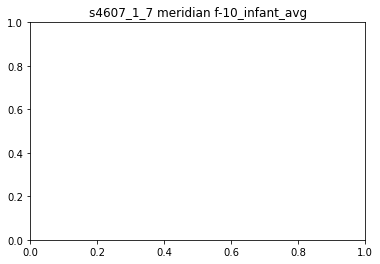

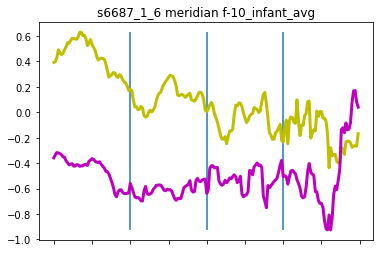

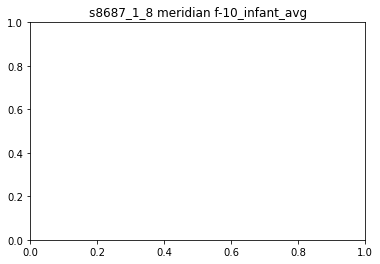

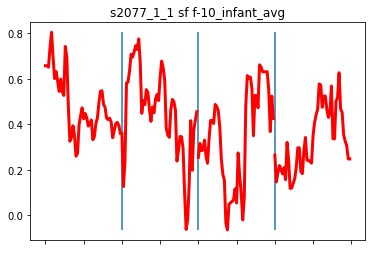

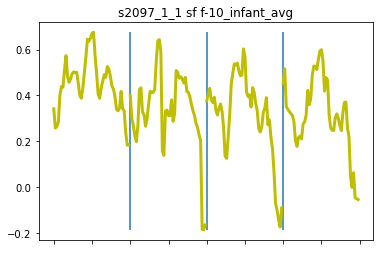

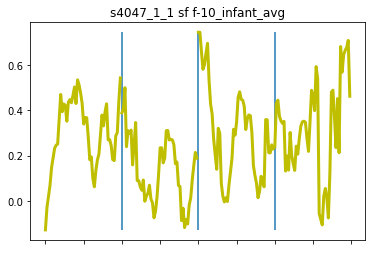

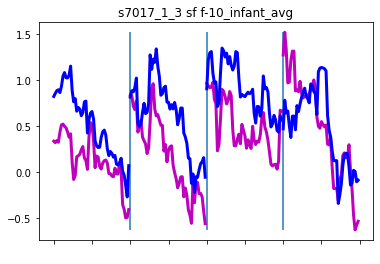

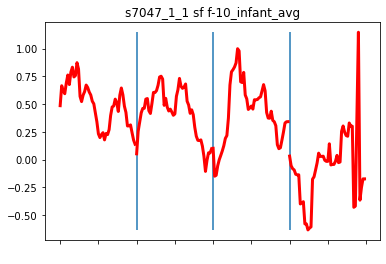

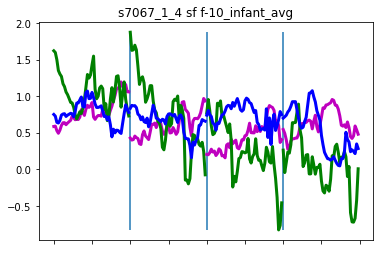

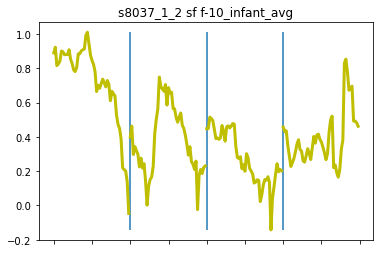

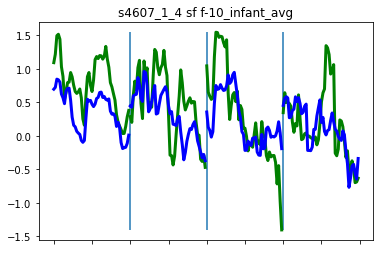

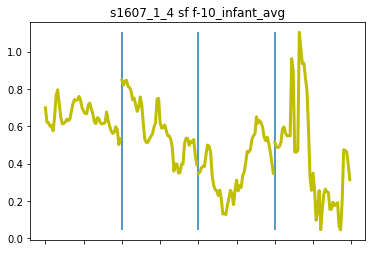

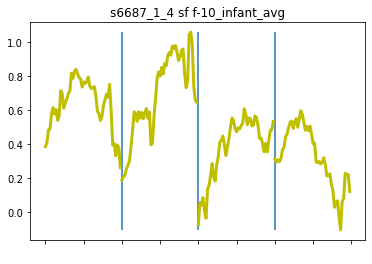

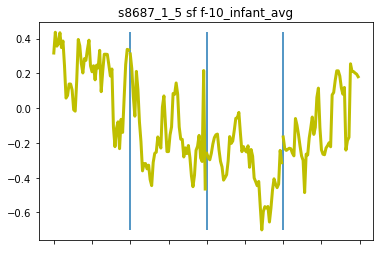

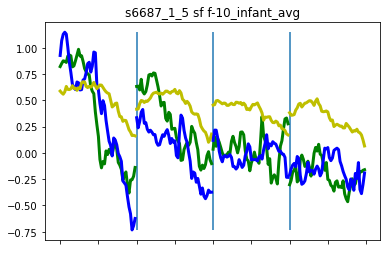

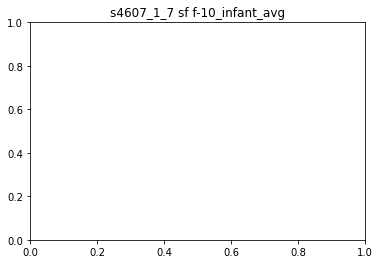

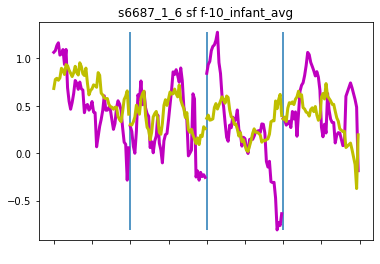

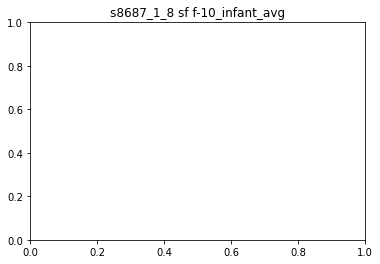

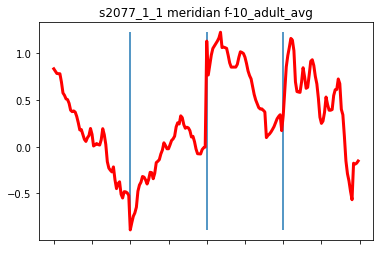

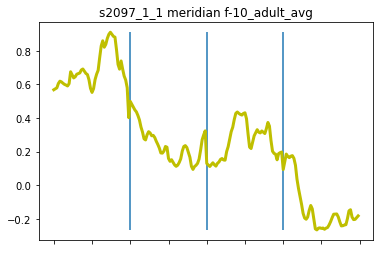

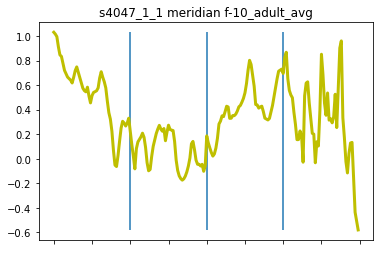

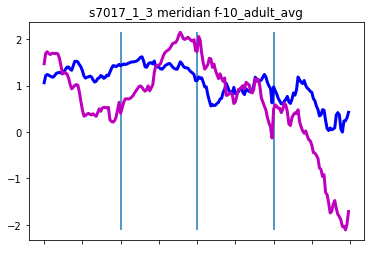

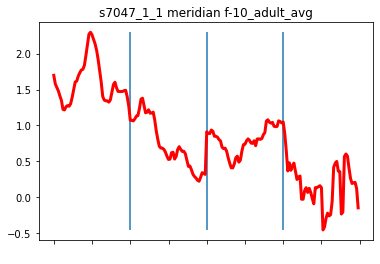

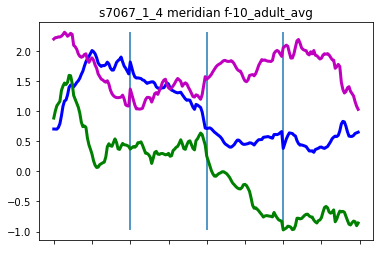

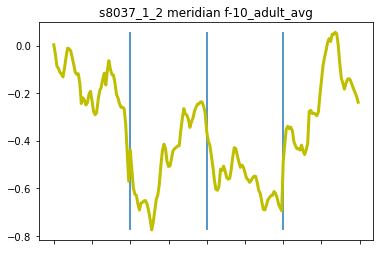

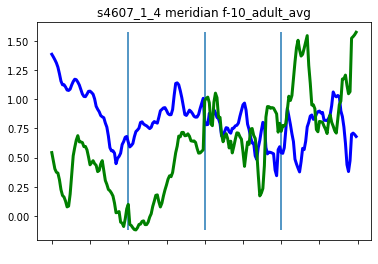

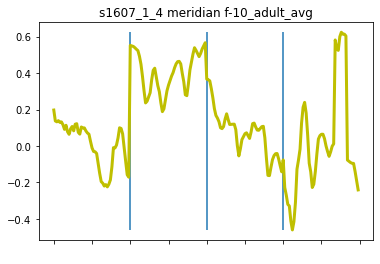

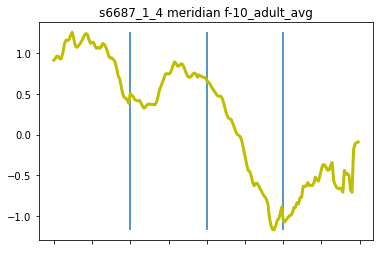

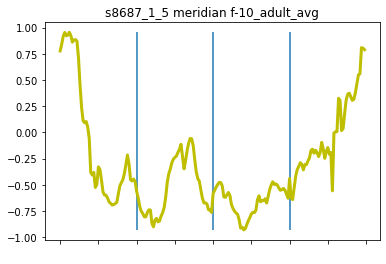

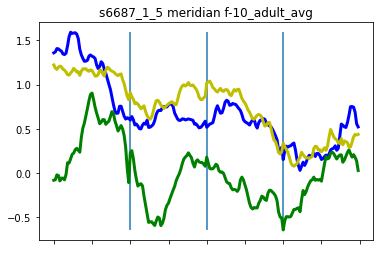

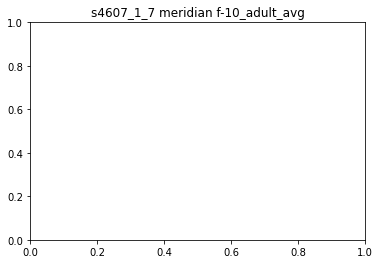

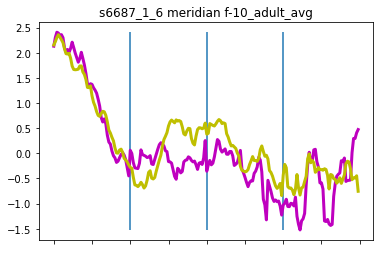

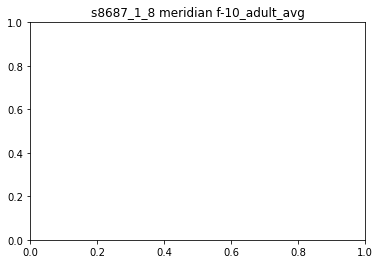

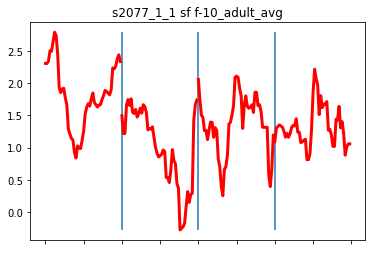

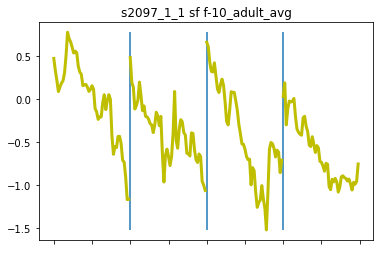

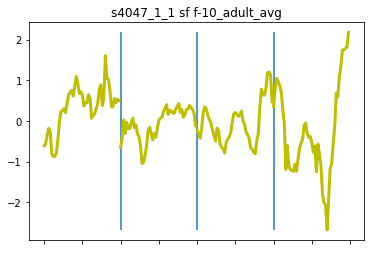

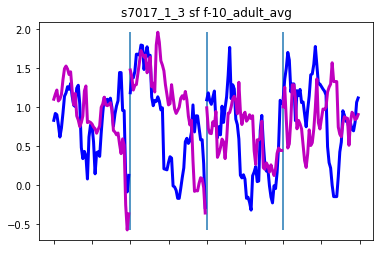

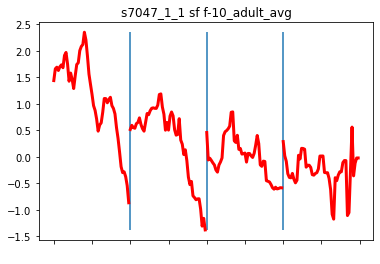

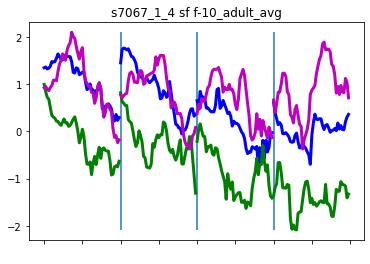

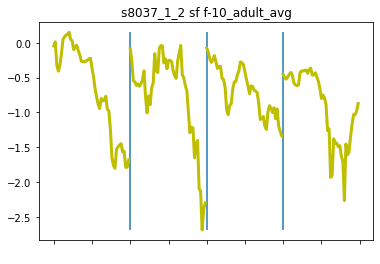

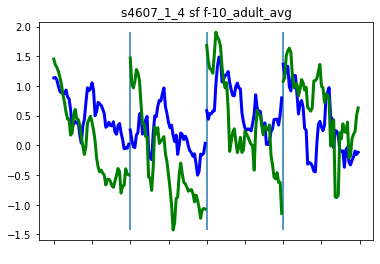

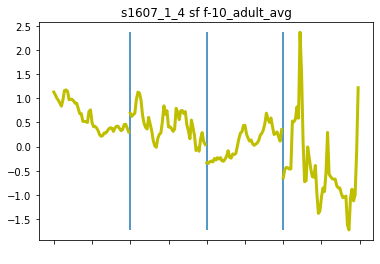

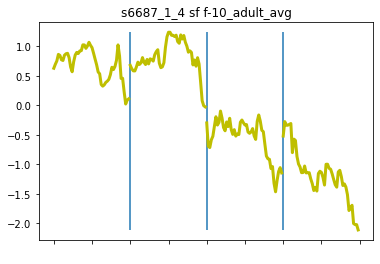

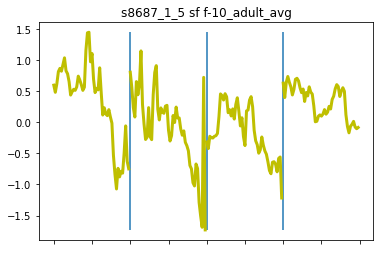

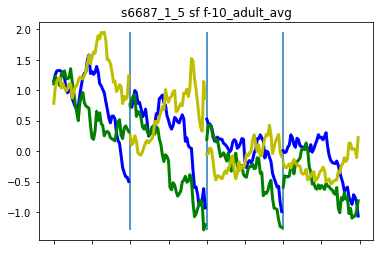

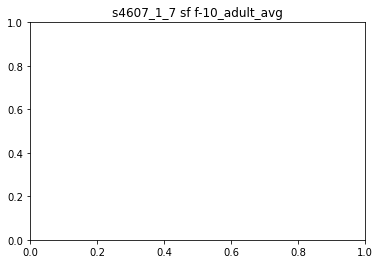

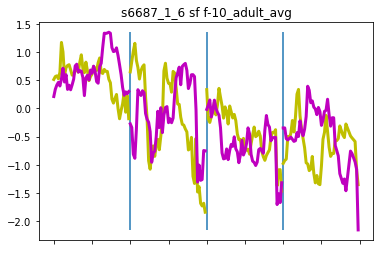

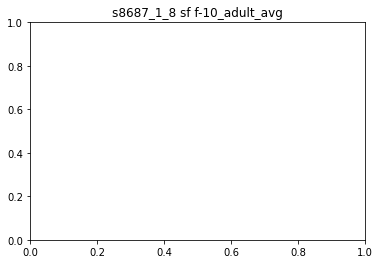

In [45]:
# Plot SRM lines. This will generate the func_line_summaries if they don't exist yet
adults_or_infants = -1
for file_identifier in ['f-%d_infant_avg' % chosen_features, 'f-%d_adult_avg' % chosen_features]:
    for GLM_condition in ['meridian', 'sf']:

        for ppt in ppts_ordered:
            output_name = '%s/plots/%s_%s_%s_%s.svg' % (predict_dir, ppt, GLM_condition, file_identifier, mask_type)
            plot_line_oscillations(ppt, GLM_condition, file_identifier, output_name, plot_mean=0, adults_or_infants=adults_or_infants)
    

Generate the line summaries for the control conditions

/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice


Creating /gpfs/milgram/project/turk-browne/projects/dev_neuropipe/data/predict_retinotopy//func_summaries_line/s4607_1_7_meridian_f-10_infant_avg_occipital_control.pkl
No IC data found for s4607_1_7, skipping
Creating /gpfs/milgram/project/turk-browne/projects/dev_neuropipe/data/predict_retinotopy//func_summaries_line/s8687_1_8_meridian_f-10_infant_avg_occipital_control.pkl
No IC data found for s8687_1_8, skipping


/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:358: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399

Creating /gpfs/milgram/project/turk-browne/projects/dev_neuropipe/data/predict_retinotopy//func_summaries_line/s4607_1_7_meridian_f-10_adult_avg_occipital_control.pkl
No IC data found for s4607_1_7, skipping
Creating /gpfs/milgram/project/turk-browne/projects/dev_neuropipe/data/predict_retinotopy//func_summaries_line/s8687_1_8_meridian_f-10_adult_avg_occipital_control.pkl
No IC data found for s8687_1_8, skipping


/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/

Creating /gpfs/milgram/project/turk-browne/projects/dev_neuropipe/data/predict_retinotopy//func_summaries_line/s4607_1_7_sf_f-10_infant_avg_occipital_control.pkl
No IC data found for s4607_1_7, skipping


/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice


Creating /gpfs/milgram/project/turk-browne/projects/dev_neuropipe/data/predict_retinotopy//func_summaries_line/s8687_1_8_sf_f-10_infant_avg_occipital_control.pkl
No IC data found for s8687_1_8, skipping


/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/

Creating /gpfs/milgram/project/turk-browne/projects/dev_neuropipe/data/predict_retinotopy//func_summaries_line/s4607_1_7_sf_f-10_adult_avg_occipital_control.pkl
No IC data found for s4607_1_7, skipping


/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:399: RuntimeWarning: Mean of empty slice


Creating /gpfs/milgram/project/turk-browne/projects/dev_neuropipe/data/predict_retinotopy//func_summaries_line/s8687_1_8_sf_f-10_adult_avg_occipital_control.pkl
No IC data found for s8687_1_8, skipping


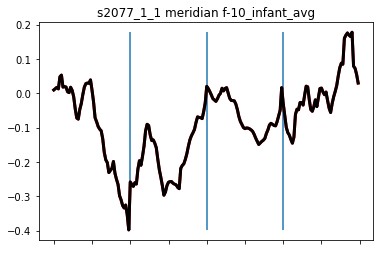

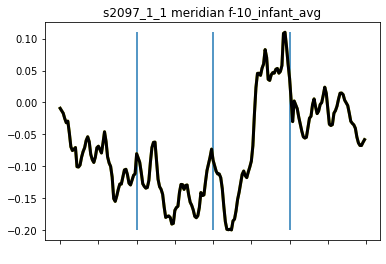

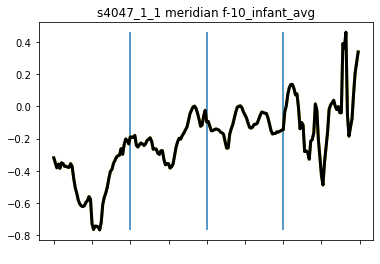

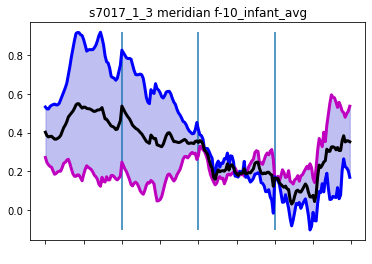

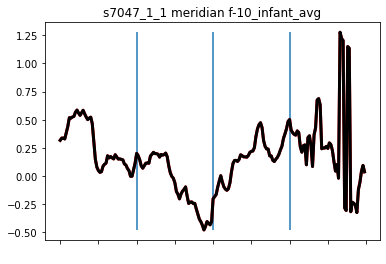

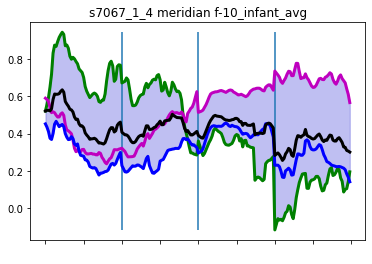

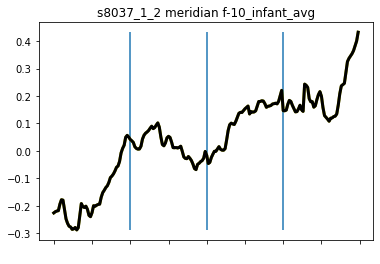

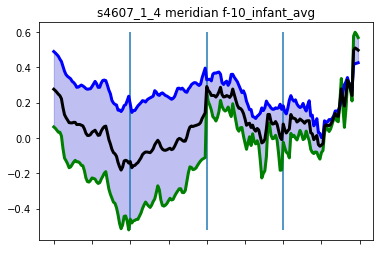

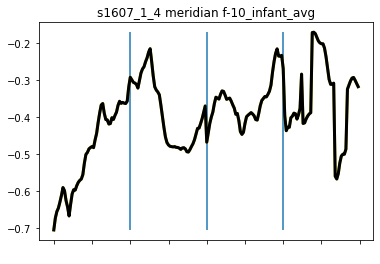

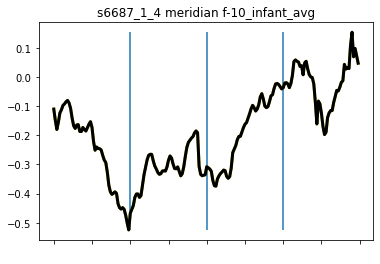

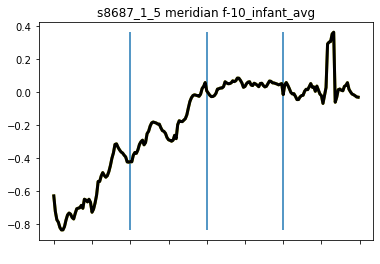

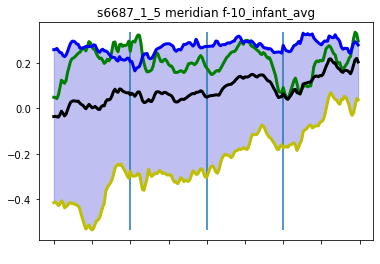

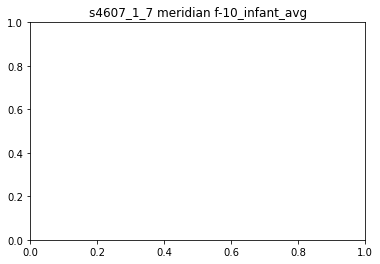

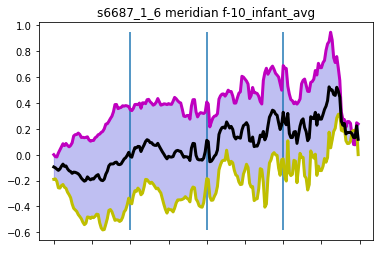

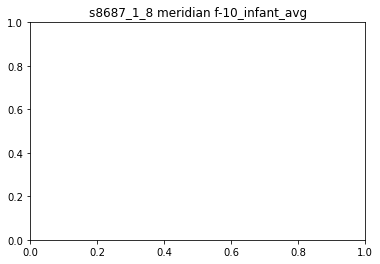

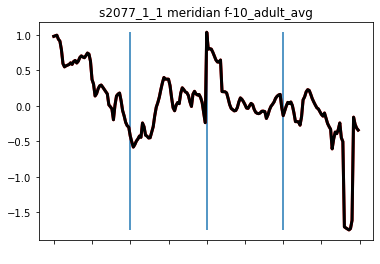

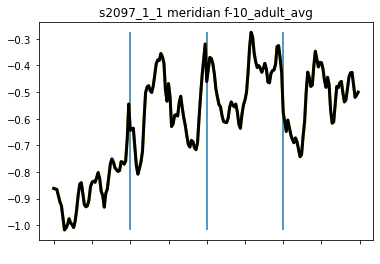

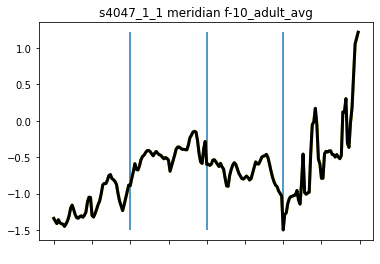

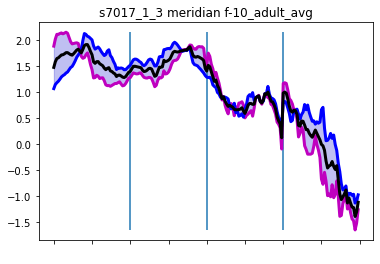

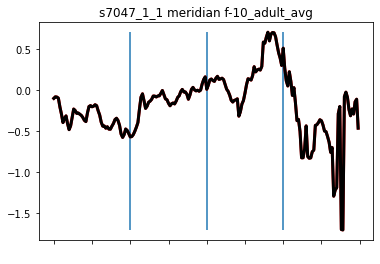

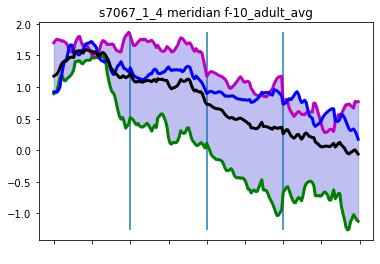

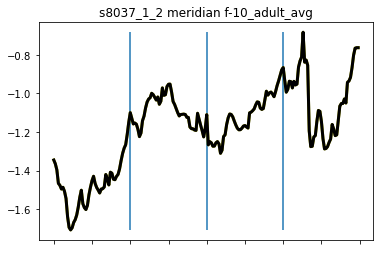

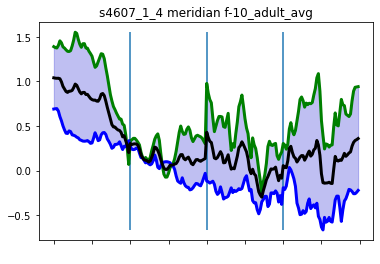

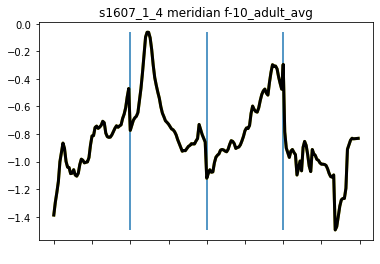

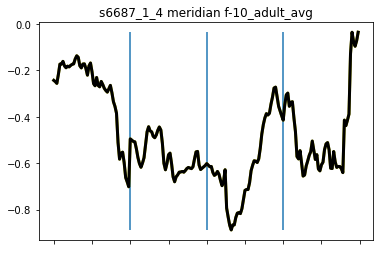

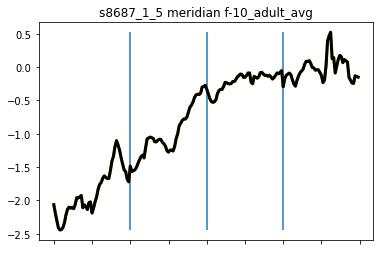

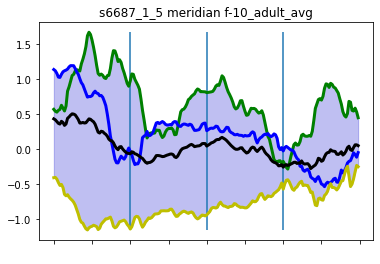

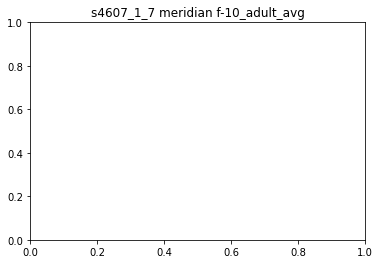

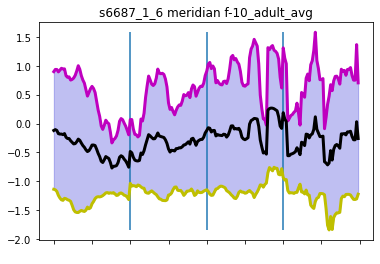

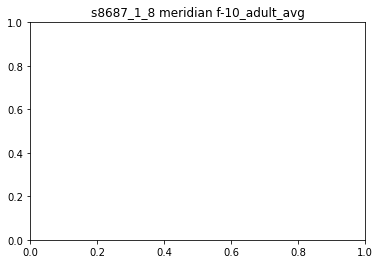

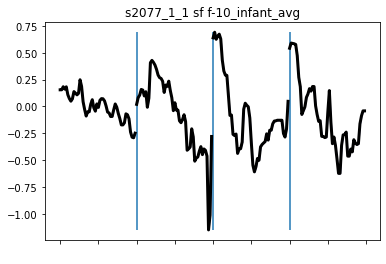

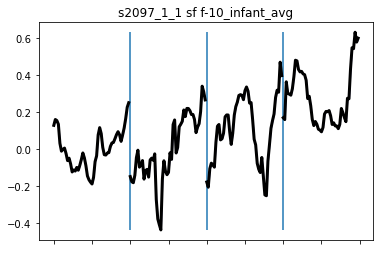

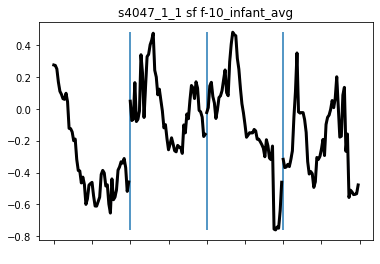

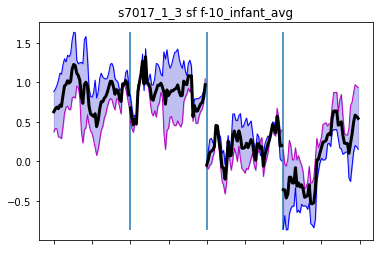

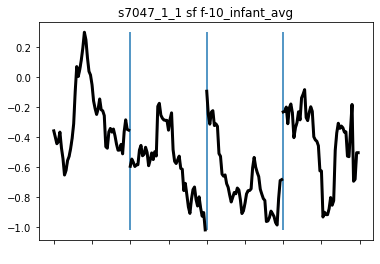

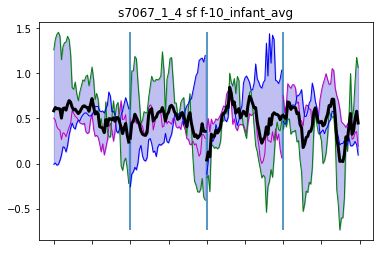

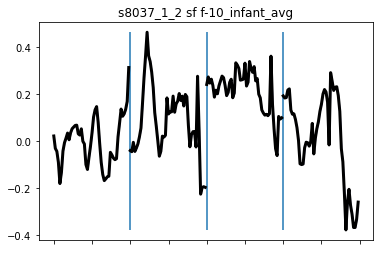

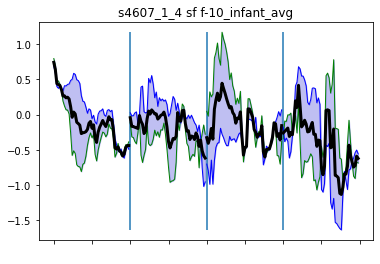

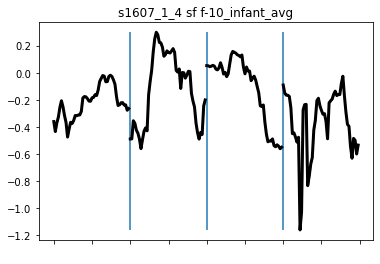

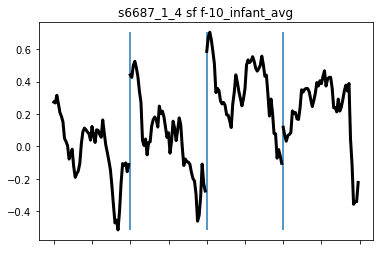

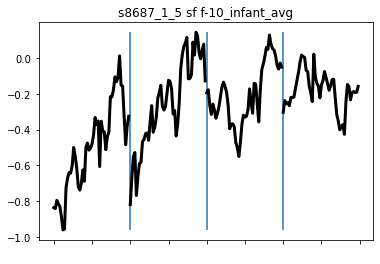

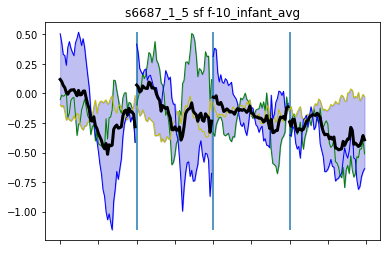

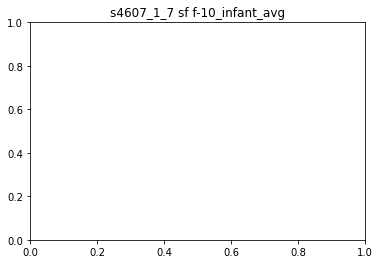

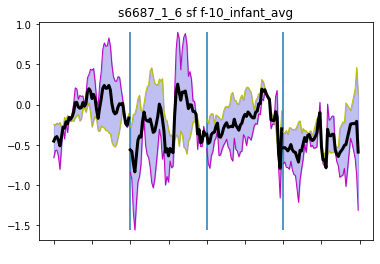

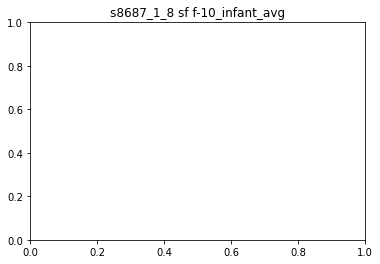

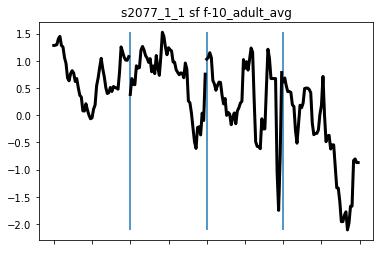

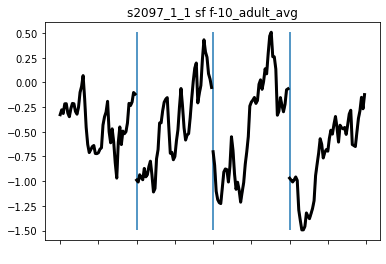

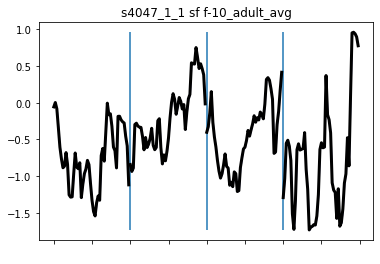

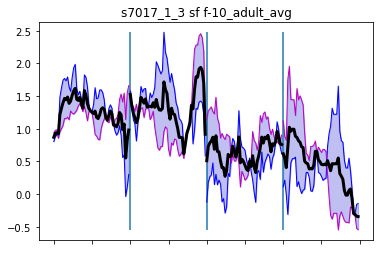

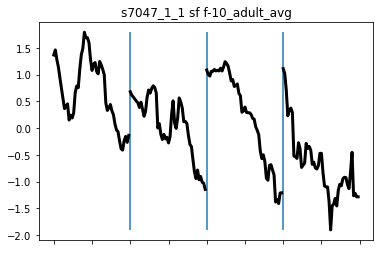

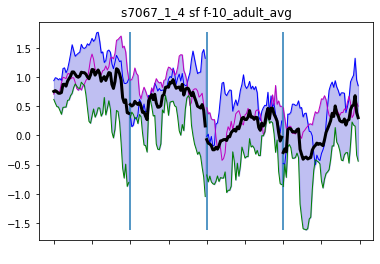

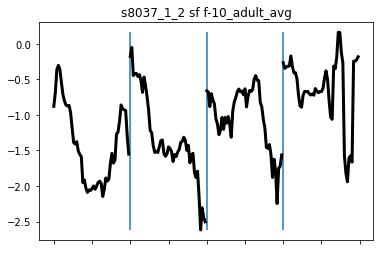

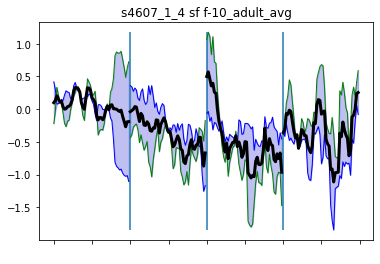

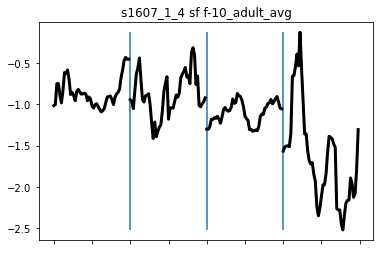

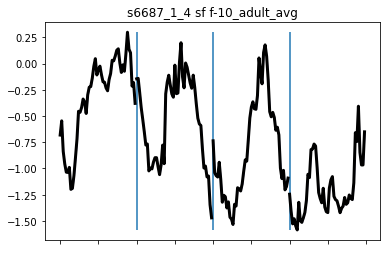

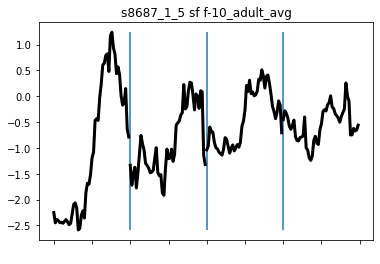

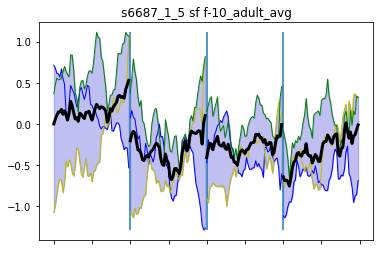

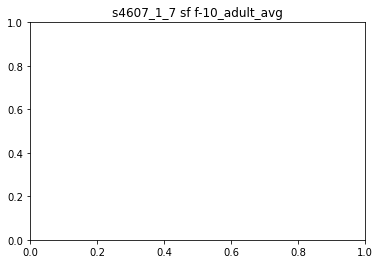

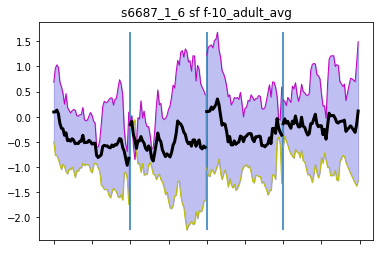

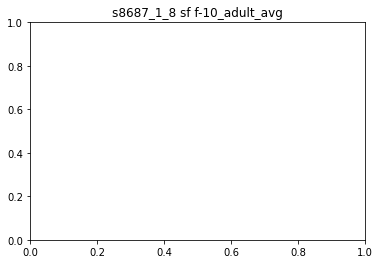

In [46]:
# Plot the patterns across
adults_or_infants = -1 # Means include all files that meet this criteria

for GLM_condition in ['meridian', 'sf']:
    for file_identifier in ['f-%d_infant_avg' % chosen_features, 'f-%d_adult_avg' % chosen_features]:
        for ppt in ppts_ordered:
            plot_line_oscillations(ppt, GLM_condition, file_identifier, '', mask_type='occipital_control', plot_mean=1, adults_or_infants=adults_or_infants)


Make a plot for an individual to highlight them

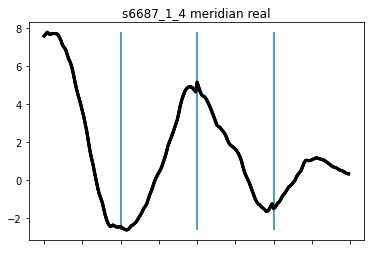

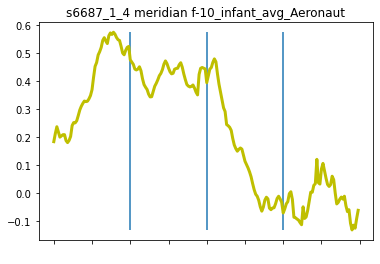

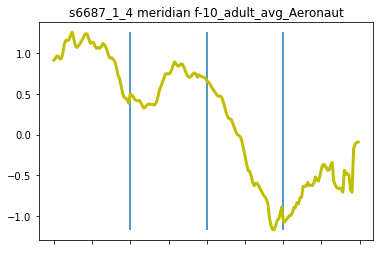

In [47]:
# Highlight this
GLM_condition = 'meridian'
ppt = 's6687_1_4'

plot_line_oscillations(ppt, GLM_condition, 'real')
plot_line_oscillations(ppt, GLM_condition, 'f-%d_infant_avg_Aeronaut' % chosen_features, mask_type=mask_type)

plot_line_oscillations(ppt, GLM_condition, 'f-%d_adult_avg_Aeronaut' % chosen_features, mask_type=mask_type)



Generate the dictionaries in preparation for comparisons between SRM models or ICA.


s2077_1_1
meridian
All
Child_Play: r=0.78
sf
All
Child_Play: r=0.44

s2097_1_1
meridian
All
Aeronaut: r=0.03
sf
All
Aeronaut: r=0.31

s4047_1_1
meridian
All
Aeronaut: r=0.39
sf
All
Aeronaut: r=-0.06

s7017_1_3
meridian
All
Mouseforsale: r=-0.27
Meerkats: r=0.05
sf
All
Mouseforsale: r=0.05
Meerkats: r=0.31

s7047_1_1
meridian
All
Child_Play: r=0.06
sf
All
Child_Play: r=0.23

s7067_1_4
meridian
All
Mouseforsale: r=0.07
Catepillar: r=0.23
Meerkats: r=-0.33


/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:792: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:792: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/

sf
All
Mouseforsale: r=0.22
Catepillar: r=0.72
Meerkats: r=0.23

s8037_1_2
meridian
All
Aeronaut: r=0.53
sf
All
Aeronaut: r=0.70

s4607_1_4
meridian
All
Catepillar: r=0.55
Meerkats: r=0.28
sf
All
Catepillar: r=0.63
Meerkats: r=0.66

s1607_1_4
meridian
All
Aeronaut: r=0.12
sf
All
Aeronaut: r=0.58

s6687_1_4
meridian
All
Aeronaut: r=0.11
sf
All
Aeronaut: r=0.30

s8687_1_5
meridian
All
Aeronaut: r=0.24
sf
All
Aeronaut: r=0.49


/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/


s6687_1_5
meridian
All
Aeronaut: r=0.19
Catepillar: r=-0.35
Meerkats: r=0.04
sf
All
Catepillar: r=0.78
Meerkats: r=0.80
Aeronaut: r=0.77

s4607_1_7

s6687_1_6
meridian
All
Aeronaut: r=0.29
Mouseforsale: r=0.24
sf
All
Mouseforsale: r=0.45
Aeronaut: r=0.70

s8687_1_8

s2077_1_1
meridian
All
Child_Play: r=0.63
sf
All
Child_Play: r=0.41

s2097_1_1
meridian
All
Aeronaut: r=-0.28
sf
All
Aeronaut: r=-0.58

s4047_1_1
meridian
All
Aeronaut: r=-0.01
sf
All
Aeronaut: r=0.10

s7017_1_3
meridian
All
Mouseforsale: r=-0.06
Meerkats: r=0.17


/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:792: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:792: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/

sf
All
Mouseforsale: r=0.32
Meerkats: r=0.65

s7047_1_1
meridian
All
Child_Play: r=-0.17
sf
All
Child_Play: r=0.12

s7067_1_4
meridian
All
Catepillar: r=-0.19
Mouseforsale: r=0.60
Meerkats: r=0.72
sf
All
Mouseforsale: r=-0.29
Catepillar: r=0.59
Meerkats: r=-0.49

s8037_1_2
meridian
All
Aeronaut: r=-0.60
sf
All
Aeronaut: r=-0.20

s4607_1_4
meridian
All
Catepillar: r=0.44
Meerkats: r=0.66
sf
All
Catepillar: r=0.32
Meerkats: r=0.44

s1607_1_4
meridian
All
Aeronaut: r=-0.54
sf
All
Aeronaut: r=0.05


/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/


s6687_1_4
meridian
All
Aeronaut: r=0.07
sf
All
Aeronaut: r=-0.26

s8687_1_5
meridian
All
Aeronaut: r=0.04
sf
All
Aeronaut: r=-0.78

s6687_1_5
meridian
All
Catepillar: r=-0.19
Meerkats: r=0.43
Aeronaut: r=-0.30
sf
All
Catepillar: r=0.28
Aeronaut: r=-0.23
Meerkats: r=0.44

s4607_1_7

s6687_1_6
meridian
All
Mouseforsale: r=-0.37
Aeronaut: r=-0.01
sf
All
Mouseforsale: r=0.30
Aeronaut: r=-0.12

s8687_1_8

s2077_1_1
meridian
All
Child_Play: r=0.56
sf
All
Child_Play: r=0.30

s2097_1_1
meridian
All
Aeronaut: r=0.24


/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:792: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/

sf
All
Aeronaut: r=0.53

s4047_1_1
meridian
All
Aeronaut: r=0.19
sf
All
Aeronaut: r=0.17

s7017_1_3
meridian
All
Meerkats: r=0.22
Mouseforsale: r=0.55
sf
All
Meerkats: r=0.26
Mouseforsale: r=0.54

s7047_1_1
meridian
All
Child_Play: r=-0.27
sf
All
Child_Play: r=0.39

s7067_1_4
meridian
All
Meerkats: r=-0.60
Catepillar: r=0.06
Mouseforsale: r=0.73
sf
All
Meerkats: r=0.86
Catepillar: r=0.82
Mouseforsale: r=0.30

s8037_1_2
meridian
All
Aeronaut: r=0.53
sf
All
Aeronaut: r=0.58


/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice



s4607_1_4
meridian
All
Meerkats: r=0.63
Catepillar: r=0.19
sf
All
Meerkats: r=0.41
Catepillar: r=0.45

s1607_1_4
meridian
All
Aeronaut: r=0.16
sf
All
Aeronaut: r=0.70

s6687_1_4
meridian
All
Aeronaut: r=0.52
sf
All
Aeronaut: r=0.74

s8687_1_5
meridian
All
Aeronaut: r=0.36


/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice


sf
All
Aeronaut: r=0.44

s6687_1_5
meridian
All
Meerkats: r=0.48
Catepillar: r=0.21
Aeronaut: r=0.45
sf
All
Meerkats: r=0.85
Catepillar: r=0.83
Aeronaut: r=0.66

s4607_1_7

s6687_1_6
meridian
All
Mouseforsale: r=0.54
Aeronaut: r=0.71
sf
All
Aeronaut: r=0.79
Mouseforsale: r=0.64

s8687_1_8

s2077_1_1
meridian
All
Child_Play: r=0.46
sf
All
Child_Play: r=0.56

s2097_1_1
meridian
All
Aeronaut: r=-0.48
sf
All
Aeronaut: r=0.21

s4047_1_1
meridian
All
Aeronaut: r=-0.09
sf
All
Aeronaut: r=0.03


/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:792: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:792: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/


s7017_1_3
meridian
All
Mouseforsale: r=0.51
Meerkats: r=0.30
sf
All
Meerkats: r=0.63
Mouseforsale: r=0.23

s7047_1_1
meridian
All
Child_Play: r=0.15
sf
All
Child_Play: r=-0.01

s7067_1_4
meridian
All
Catepillar: r=-0.14
Mouseforsale: r=-0.25
Meerkats: r=-0.22
sf
All
Meerkats: r=0.53
Mouseforsale: r=0.72
Catepillar: r=0.69

s8037_1_2
meridian
All
Aeronaut: r=-0.55
sf
All
Aeronaut: r=-0.07

s4607_1_4
meridian
All
Catepillar: r=0.56
Meerkats: r=0.19
sf
All
Meerkats: r=0.60
Catepillar: r=0.27

s1607_1_4
meridian
All
Aeronaut: r=-0.42


/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/

sf
All
Aeronaut: r=0.56

s6687_1_4
meridian
All
Aeronaut: r=0.20
sf
All
Aeronaut: r=0.33

s8687_1_5
meridian
All
Aeronaut: r=0.11
sf
All
Aeronaut: r=-0.71

s6687_1_5
meridian
All
Catepillar: r=0.28
Meerkats: r=0.57
Aeronaut: r=0.10
sf
All
Meerkats: r=0.81
Aeronaut: r=-0.42
Catepillar: r=0.45

s4607_1_7

s6687_1_6
meridian
All
Mouseforsale: r=0.44
Aeronaut: r=-0.19
sf
All
Mouseforsale: r=-0.17
Aeronaut: r=0.09

s8687_1_8


/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:791: RuntimeWarning: Mean of empty slice


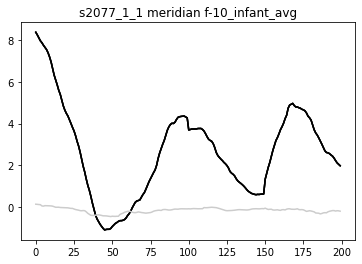

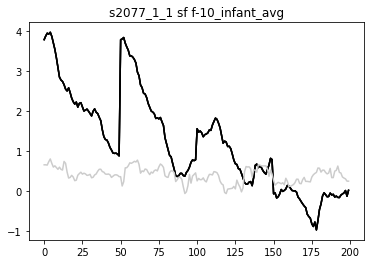

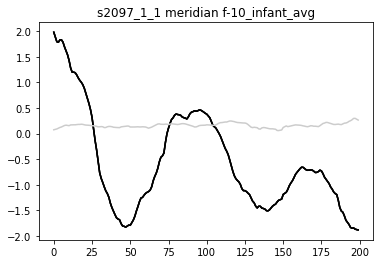

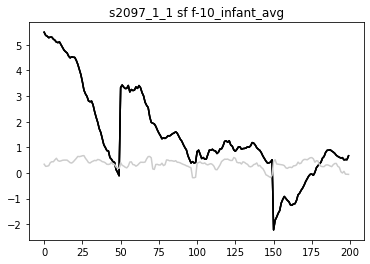

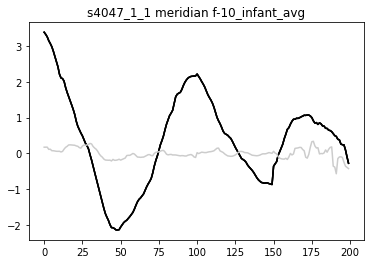

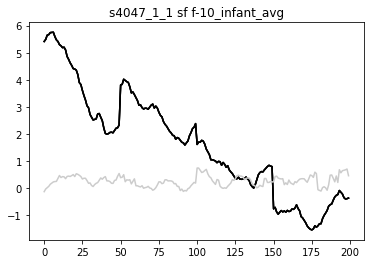

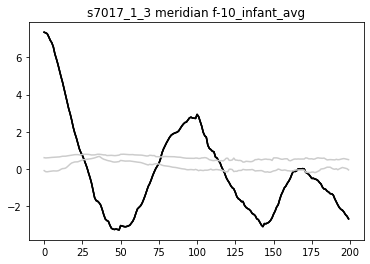

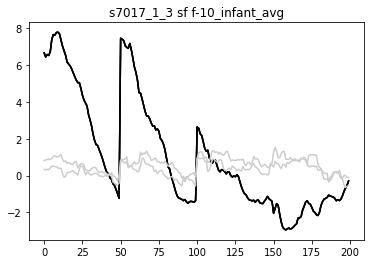

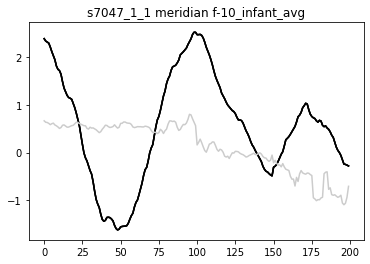

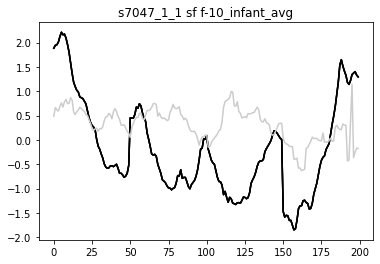

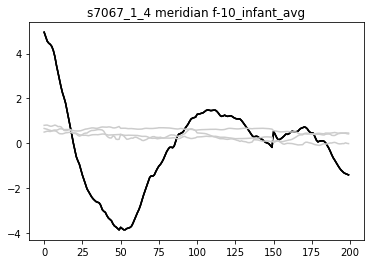

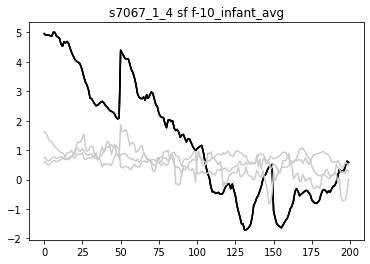

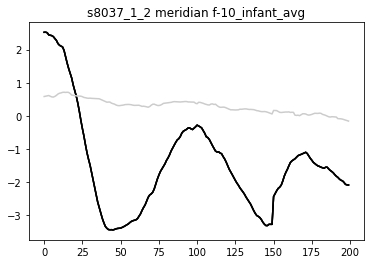

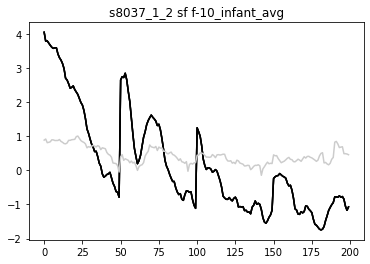

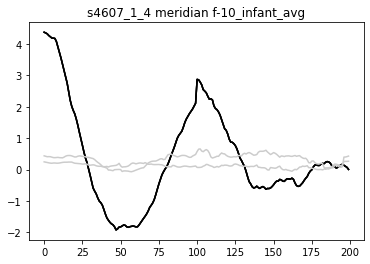

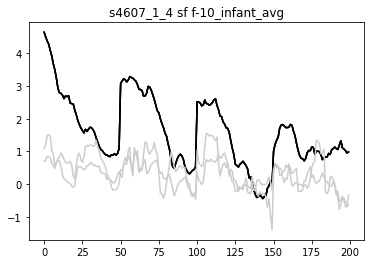

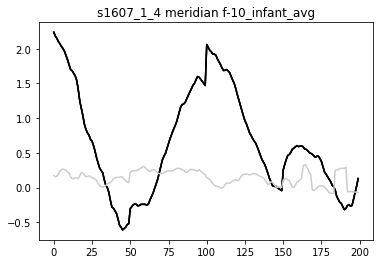

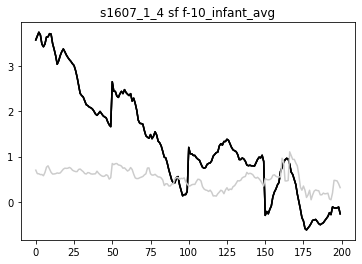

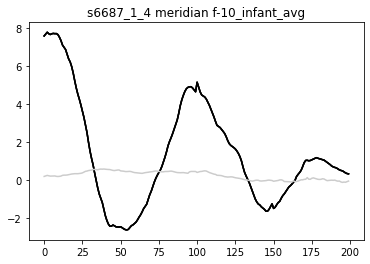

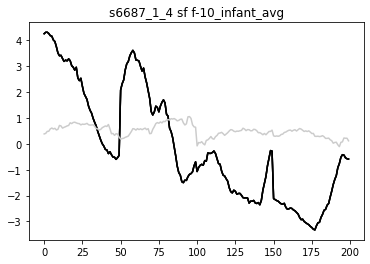

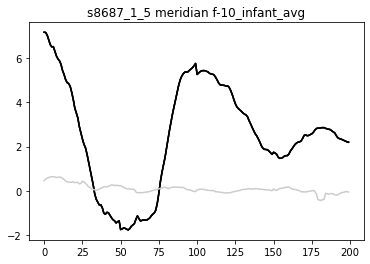

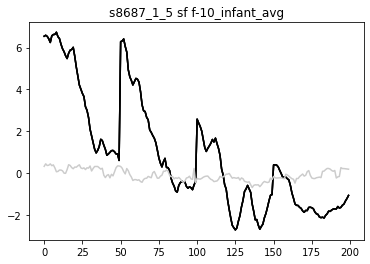

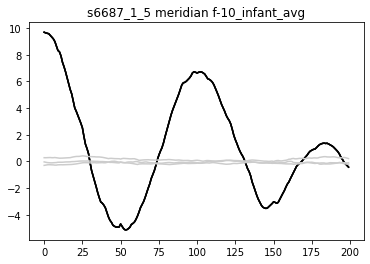

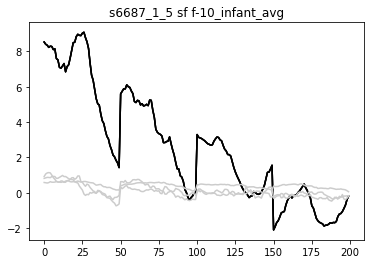

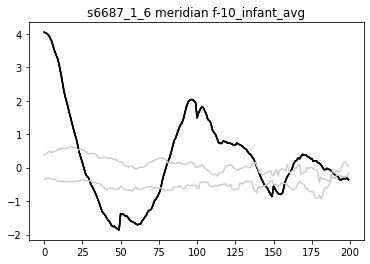

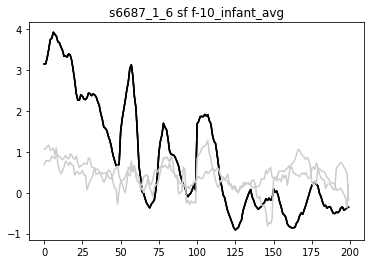

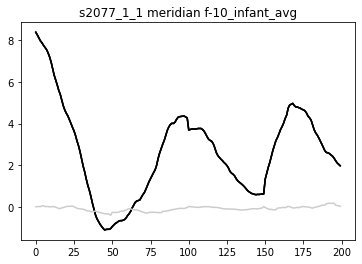

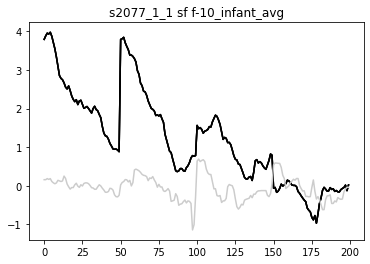

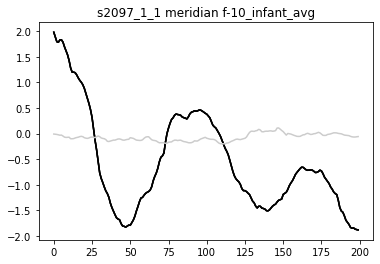

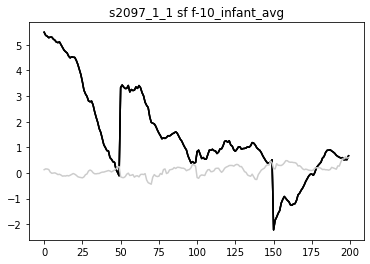

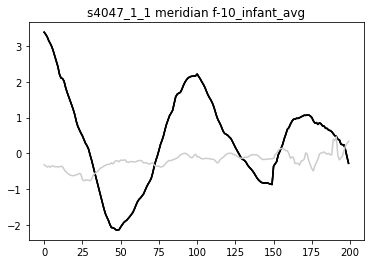

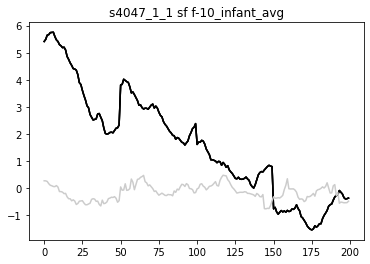

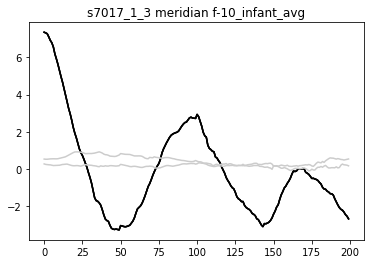

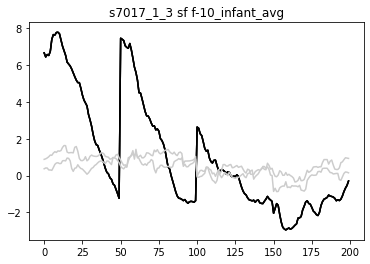

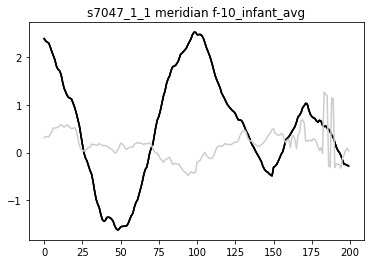

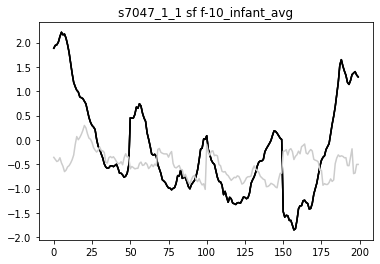

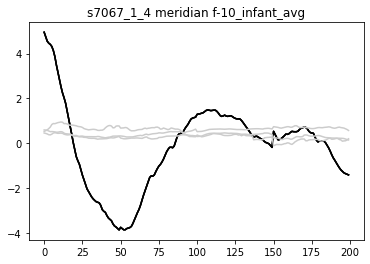

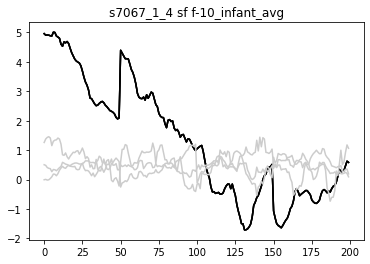

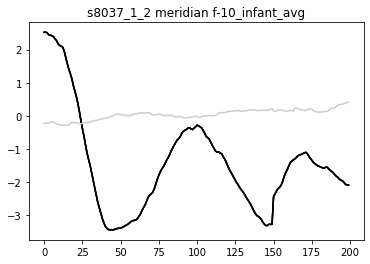

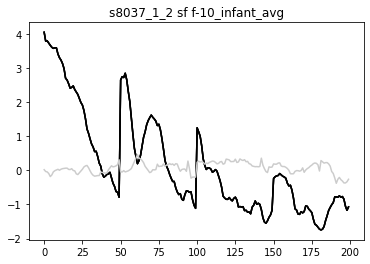

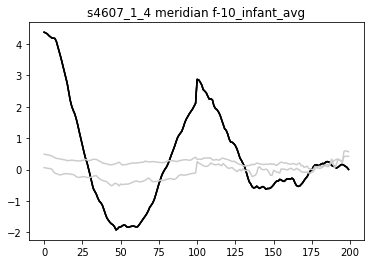

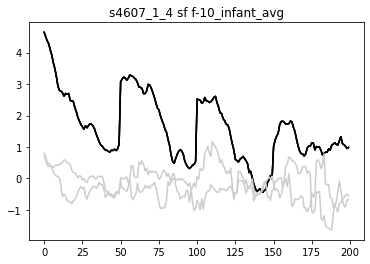

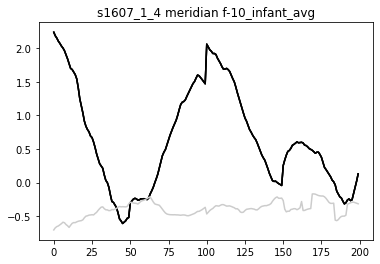

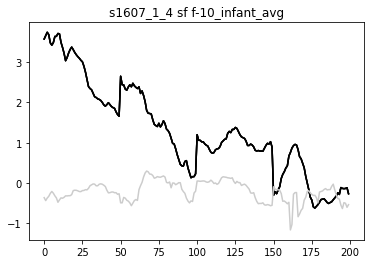

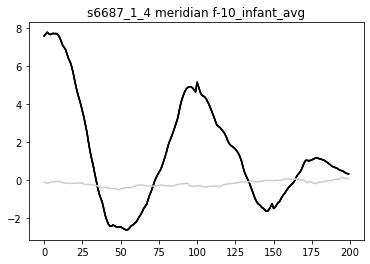

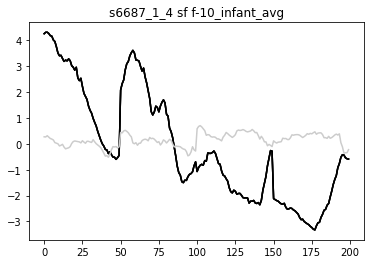

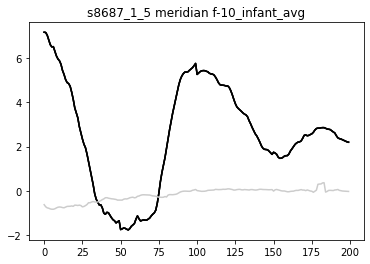

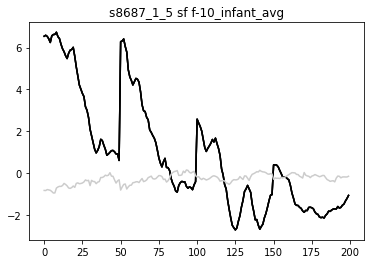

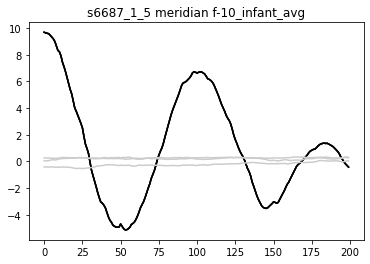

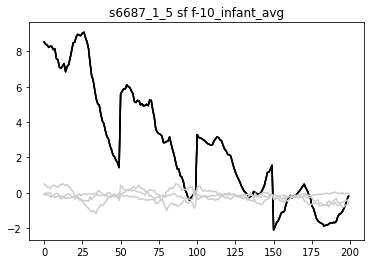

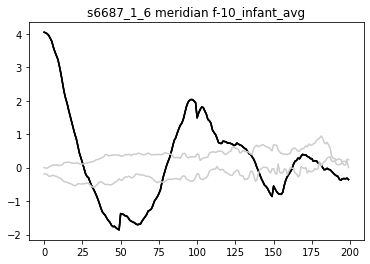

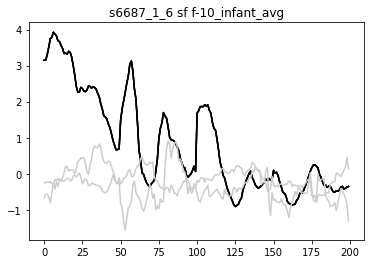

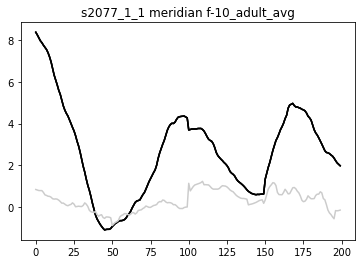

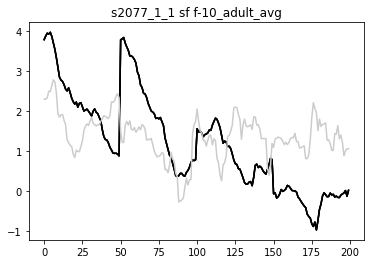

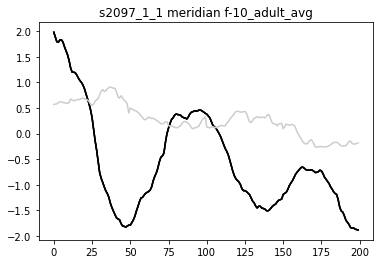

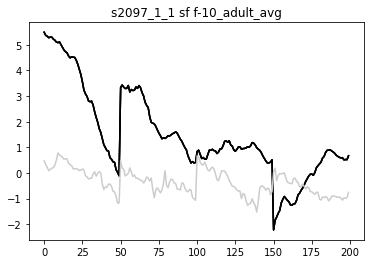

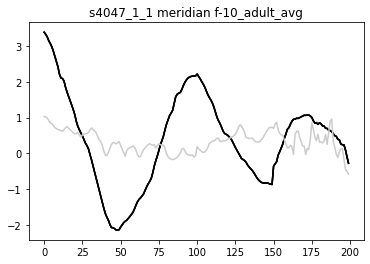

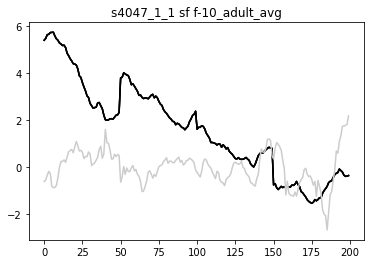

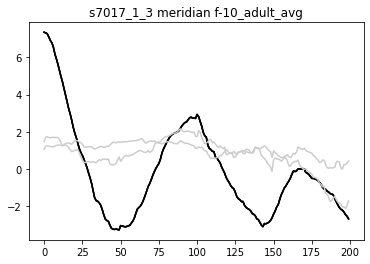

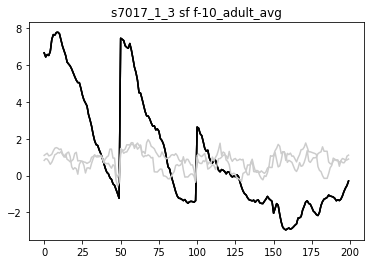

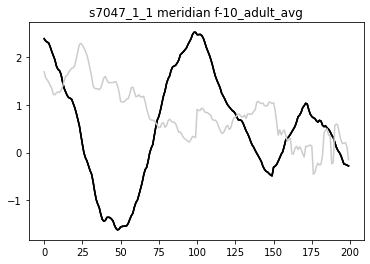

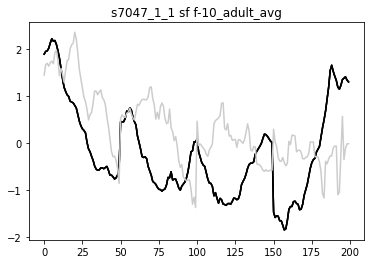

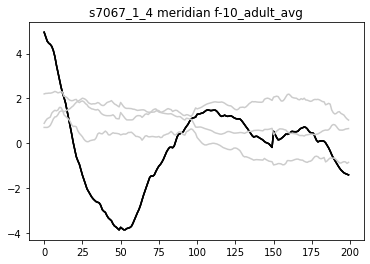

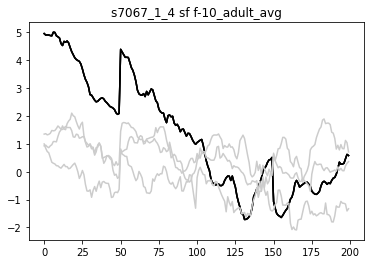

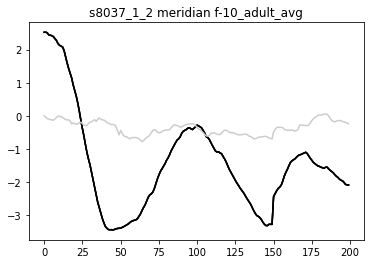

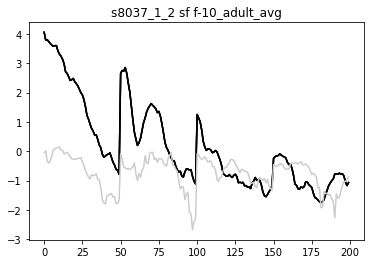

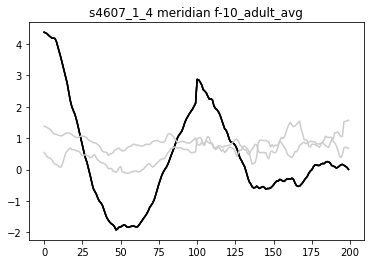

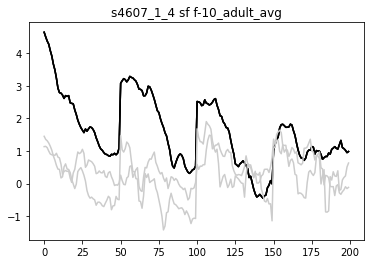

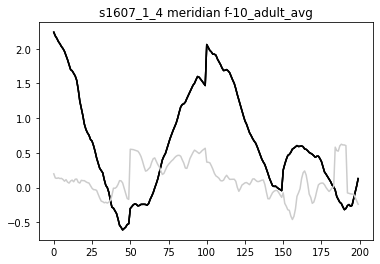

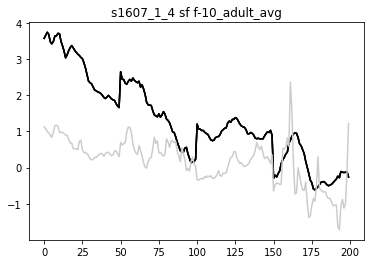

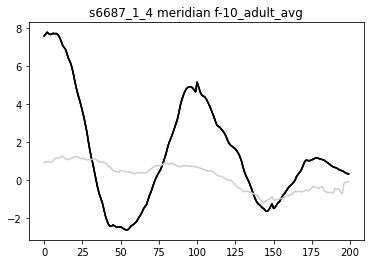

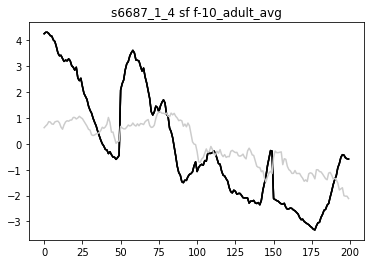

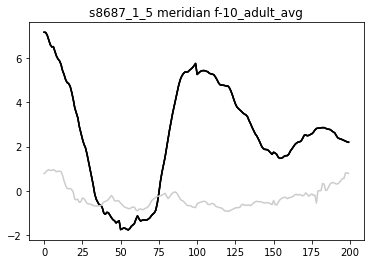

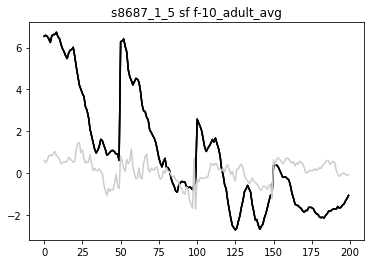

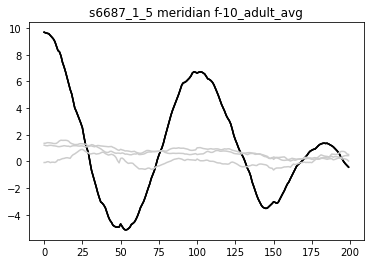

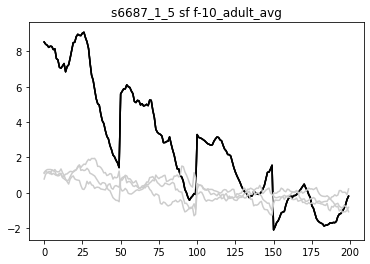

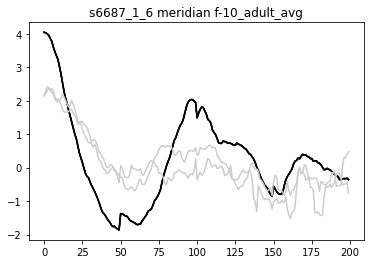

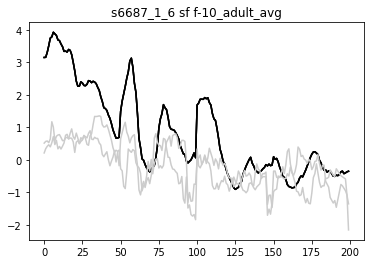

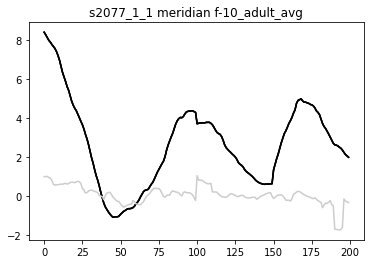

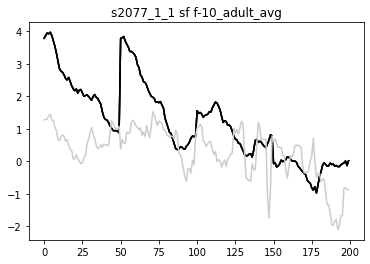

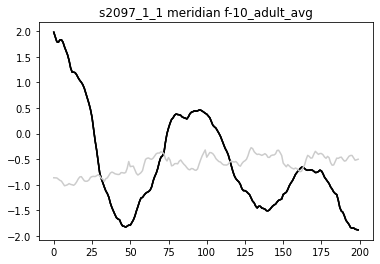

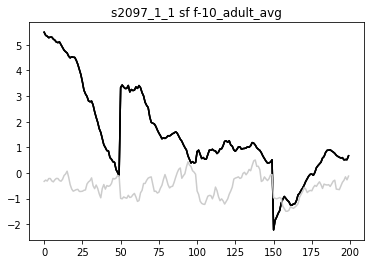

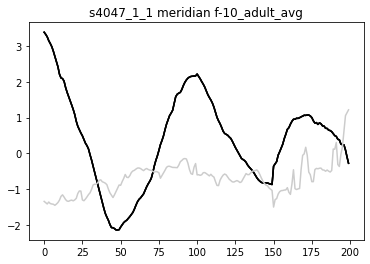

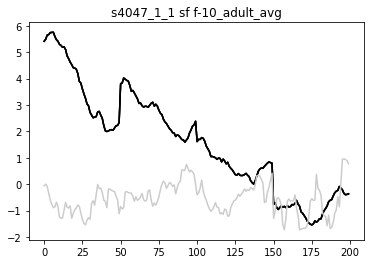

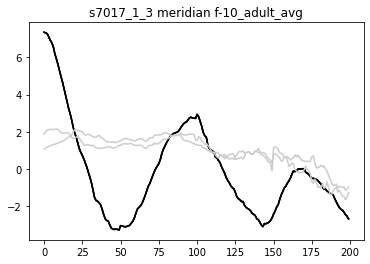

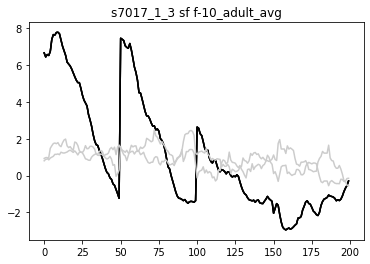

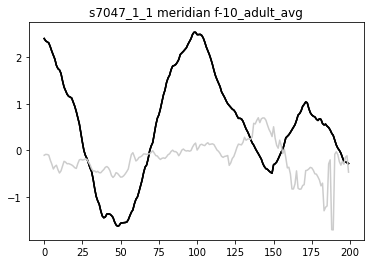

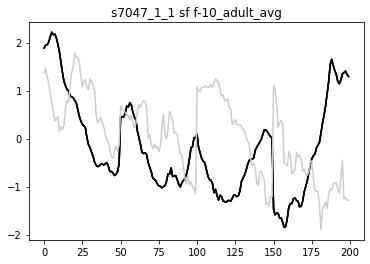

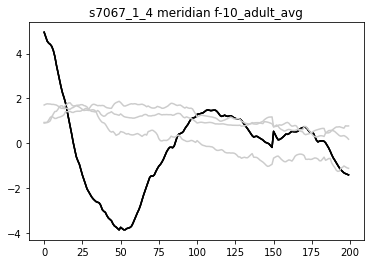

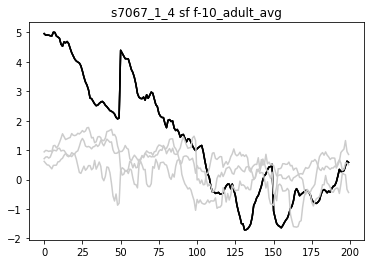

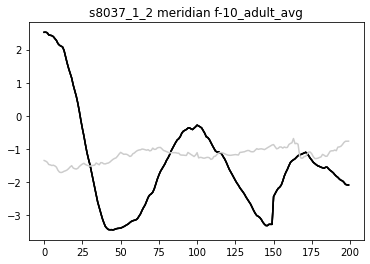

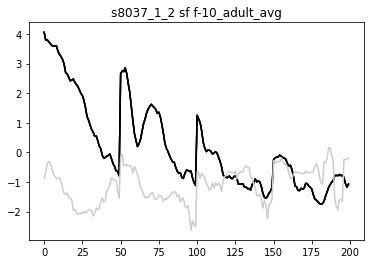

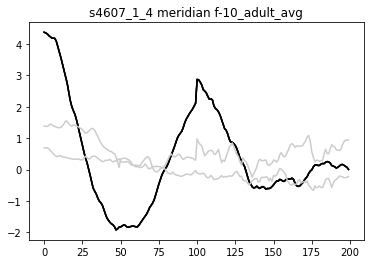

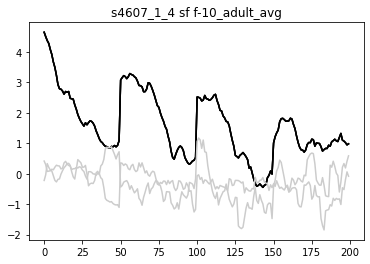

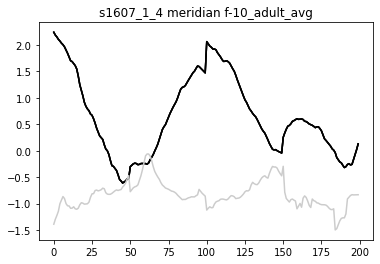

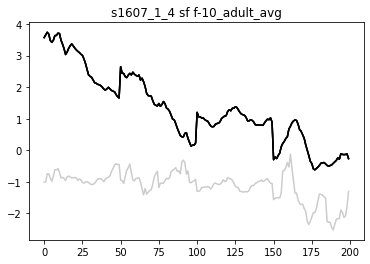

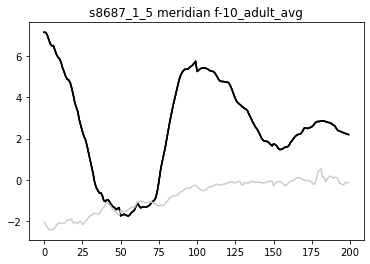

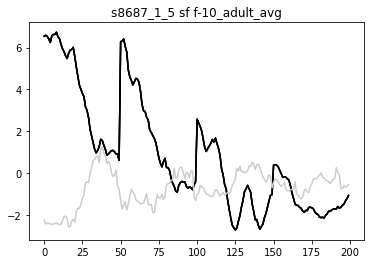

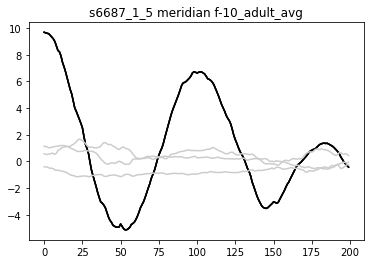

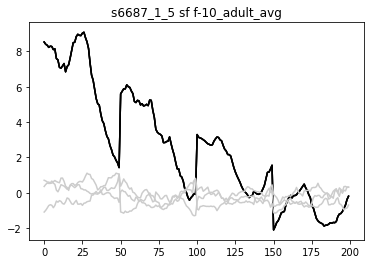

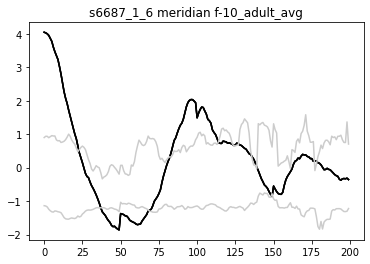

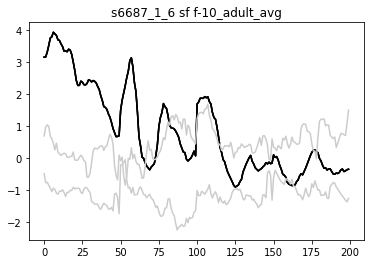

In [48]:
# What is the correlation between the real and predicted lines
file_identifier = 'f-%d_infant_avg' % chosen_features
infant_SRM_corr_vals_dict = create_corr_vals_dict(file_identifier, use_ideal_lines=use_ideal_lines)

# Get the control information, use it for the plot
infant_SRM_corr_vals_control_dict = create_corr_vals_dict(file_identifier, is_control=1, use_ideal_lines=use_ideal_lines)

# What is the correlation between the real and predicted lines
file_identifier = 'f-%d_adult_avg' % chosen_features
adult_SRM_corr_vals_dict = create_corr_vals_dict(file_identifier, use_ideal_lines=use_ideal_lines)

# Get the control information, use it for the plot
adult_SRM_corr_vals_control_dict = create_corr_vals_dict(file_identifier, is_control=1, use_ideal_lines=use_ideal_lines)

Plot the summary results

/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:863: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


meridian: mean corr. M=0.24 (range:-0.12--0.78)
Correlation between age and similarity: -0.25, p=0.511
sf: mean corr. M=0.46 (range:-0.06--0.78)
Correlation between age and similarity: 0.66, p=0.002


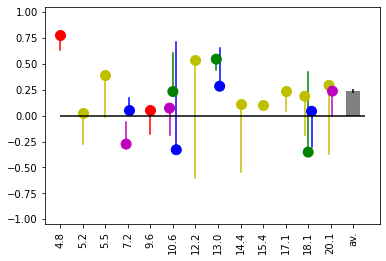

<Figure size 432x288 with 0 Axes>

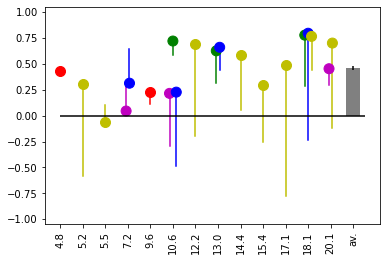

<Figure size 432x288 with 0 Axes>

In [49]:
file_identifier = 'f-%d_infant_avg' % chosen_features
plot_SRM_corr_vals(infant_SRM_corr_vals_dict, infant_SRM_corr_vals_control_dict, file_identifier, 1)


/gpfs/milgram/project/turk-browne/users/ce325/conda_envs/dev_brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:863: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


meridian: mean corr. M=0.34 (range:-0.27--0.64)
Correlation between age and similarity: 0.33, p=0.201
sf: mean corr. M=0.56 (range:0.17--0.79)
Correlation between age and similarity: 0.70, p=0.003


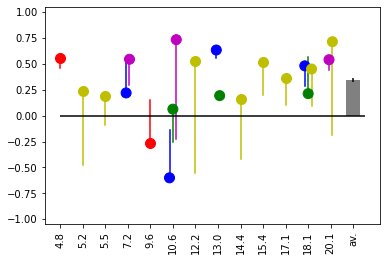

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [50]:
file_identifier = 'f-%d_adult_avg' % chosen_features
plot_SRM_corr_vals(adult_SRM_corr_vals_dict, adult_SRM_corr_vals_control_dict, file_identifier, 1)

## Run statistical tests on the ICA and SRM data<a id='stats'></a>
Take the summaries of the fits between ICA/SRM and the real data, then compare it here. For instance, compare the ICA to the SRM or the infant and adult SRMs to each other. This script needs all of the above cells to be run, especially the ones that create the dictionaries summarizing fit to participants.  

In [51]:
np.random.seed(0)

print('\ninfant SRM > control SRM')
compare_dict(infant_SRM_corr_vals_dict, infant_SRM_corr_vals_control_dict, is_between=0)

print('\nadult SRM > control SRM')
compare_dict(adult_SRM_corr_vals_dict, adult_SRM_corr_vals_control_dict, is_between=0)

print('\nadult SRM > infant SRM')
compare_dict(adult_SRM_corr_vals_dict, infant_SRM_corr_vals_dict, is_between=0)

print('\nIC > infant SRM')
compare_dict(IC_corr_vals_dict, infant_SRM_corr_vals_dict, is_between=1)

print('\nIC > adult SRM')
compare_dict(IC_corr_vals_dict, adult_SRM_corr_vals_dict, is_between=1)


infant SRM > control SRM
Diff within for meridian: 0.24, N=13, CI=[0.02--0.49], p=0.034
Diff within for sf: 0.52, N=13, CI=[0.24--0.80], p=0.000

adult SRM > control SRM
Diff within for meridian: 0.33, N=13, CI=[0.12--0.55], p=0.002
Diff within for sf: 0.40, N=13, CI=[0.17--0.65], p=0.000

adult SRM > infant SRM
Diff within for meridian: 0.11, N=13, CI=[-0.05--0.28], p=0.179
Diff within for sf: 0.14, N=13, CI=[-0.00--0.27], p=0.054

IC > infant SRM
Diff between for meridian: -0.07, N=9, CI=[-0.48--0.31], p=0.745
Diff between for sf: -0.27, N=13, CI=[-0.52---0.05], p=0.015

IC > adult SRM
Diff between for meridian: -0.19, N=9, CI=[-0.58--0.19], p=0.352
Diff between for sf: -0.41, N=13, CI=[-0.65---0.19], p=0.000


In [52]:
# For the ICA analyses, compare them to chance. Compute the descriptives and statistics using the percentiles
for GLM_condition in ['meridian', 'sf']:
    summary_val = []
    diff_chance = []
    for ppt_counter, ppt in enumerate(IC_rank_props_dict['ID']):
        if np.any(np.isnan(IC_rank_props_dict[GLM_condition][ppt_counter])) == 0:
            percentile = stat_func(IC_rank_props_dict[GLM_condition][ppt_counter]) * 100
            summary_val += [percentile]
            
            # Compute the difference from chance. Chance varies based on whether you are using the mean or the max 
            # If mean, it is just 50%
            # If max, it is n/n+1 where n is the number of components chosen
            if stat_type == 'mean':
                chance = 50
            elif stat_type == 'max':
                chance = len(IC_rank_props_dict[GLM_condition][ppt_counter]) / (len(IC_rank_props_dict[GLM_condition][ppt_counter]) + 1)
            
            diff_chance += [percentile - chance]

    # Same result as reported with the plots
    print('%s: %s percentile. M=%0.1f (range:%0.1f--%0.1f)' % (GLM_condition, stat_type, np.mean(summary_val), np.min(summary_val), np.max(summary_val)))
    
    p_val, _, CI = randomise_diff(np.asarray(diff_chance))
    print('Diff from chance M=%0.1f, CI=[%0.1f--%0.1f], p=%0.3f' % (np.mean(diff_chance), CI[0], CI[1], p_val))

meridian: mean percentile. M=67.6 (range:3.0--100.0)
Diff from chance M=17.6, CI=[-1.8--33.0], p=0.074
sf: mean percentile. M=63.8 (range:26.7--98.1)
Diff from chance M=13.8, CI=[3.3--24.0], p=0.011
